### TODO:
1. Make gif plots dist / joint
2. ~~Make 4x1 plot for accuracy - mean - precision - mixprop~~
3. Restructure into external scripts
- Alpha-beta tampering? -- can argparse and run multiple experiments for results
4. Poster - add pics - lots of 'em

5. KD switch to layer-by-layer

In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

import IPython.display as ipd
import imageio
#import os
#model_dir = "/".join(os.getcwd().split("/")[:-1] + ['models/'])
model_dir = "./models/"
import models
from utils import show_sws_weights, test_accuracy, train_epoch, retrain_sws_epoch, show_weights, model_prune, print_dims, get_weight_penalty, prune_plot, draw_sws_graphs, trueAfterN, logsumexp
import copy
from tensorboardX import SummaryWriter

writeTensorboard = False
if(writeTensorboard):
    writer = SummaryWriter('tensorboard/run1/')

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("whitegrid")


#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
train_data_full = Variable(train_dataset.train_data.float()/255.0).cuda()
test_data_full = Variable(test_dataset.test_data.float()/255.0).cuda()
train_labels_full = Variable(train_dataset.train_labels).cuda()
test_labels_full = Variable(test_dataset.test_labels).cuda()
use_cuda = torch.cuda.is_available()

#arguments
model_name = 'LeNet_300_100'
training_epochs=20
retraining_epochs=50
temp_list = [1, 5, 10, 15, 20, 25, 30]

## LeNet 300-100

### 1. Train Model

In [3]:
class GaussianMixturePrior(Module):
    def __init__(self, nb_components, network_weights, pi_zero, init_var = 0.25, zero_ab = (5e3,2), ab = (2.5e4,1), **kwargs):
        super(GaussianMixturePrior, self).__init__()
        
        self.nb_components = nb_components 
        self.network_weights = [p.view(-1) for p in network_weights]
        self.pi_zero = pi_zero
        
        #Build
        J = self.nb_components
        pi_zero = self.pi_zero
        
        #    ... means
        init_means = torch.linspace(-0.6, 0.6, J - 1)
        self.means = Variable(init_means.cuda(), requires_grad=True)
        
        #precision
        init_stds = torch.FloatTensor(np.tile(init_var, J) )
        self.gammas = Variable( (- torch.log(torch.pow(init_stds, 2))).cuda(), requires_grad=True)
        
        #mixing proportions
        init_mixing_proportions = torch.ones((J - 1))
        init_mixing_proportions *= (1. - pi_zero) / (J - 1)
        self.rhos = Variable((init_mixing_proportions).cuda(), requires_grad=True)
        self.print_batch=True
        
        self.zero_ab = zero_ab
        self.ab = ab
        print ("0-component Mean: {} Variance: {}".format(zero_ab[0]/zero_ab[1], zero_ab[0]/(zero_ab[1]**2)))
        print ("Non-zero component Mean: {} Variance: {}".format(ab[0]/ab[1], ab[0]/(ab[1]**2)))
        #self.loss = Variable(torch.cuda.FloatTensor([0.]), requires_grad=True)
        
    def call(self, mask=None):
        J=self.nb_components
        loss = Variable(torch.cuda.FloatTensor([0.]), requires_grad=True)
        means = torch.cat(( Variable(torch.cuda.FloatTensor([0.]), requires_grad=True) , self.means), 0)
        #mean=self.means
        precision = self.gammas.exp()
        
        min_rho = self.rhos.min()
        mixing_proportions = (self.rhos - min_rho).exp()
        mixing_proportions = (1 - self.pi_zero) * mixing_proportions/mixing_proportions.sum()
        mixing_proportions = torch.pow(mixing_proportions, 2)
        mixing_proportions = torch.cat(( Variable(torch.cuda.FloatTensor([self.pi_zero])) , mixing_proportions), 0)
        
        for weights in self.network_weights:
            weight_loss = self.compute_loss(weights, mixing_proportions, means, precision)
            if(gmp.print_batch):
                print ("Layer Loss: {:.3f}".format(float(weight_loss.data)))
            loss = loss + weight_loss
        
        
        # GAMMA PRIOR ON PRECISION
        # ... for the zero component
        #Replacing gather with indexing -- same calculation?
        (alpha, beta) = self.zero_ab
        #print (torch.gather(self.gammas, 0, Variable(torch.cuda.LongTensor([0,1,2]))))
        neglogprop = (1 - alpha) * self.gammas[0] + beta * precision[0]
        if(gmp.print_batch):
            print ("0-neglogprop Loss: {:.3f}".format(float(neglogprop.data)))
        loss = loss + neglogprop.sum()
        # ... and all other component
        alpha, beta = self.ab
        neglogprop = (1 - alpha) * self.gammas[1:J] + beta * precision[1:J]
        if(gmp.print_batch):
            print ("Remaining-neglogprop Loss: {:.3f}".format(float(neglogprop.sum().data)))
        loss = loss + neglogprop.sum()
        gmp.print_batch=False
        return loss
        
        
    def compute_loss(self, weights, mixing_proportions, means, precision):
        diff = weights.expand(means.size(0), -1) - means.expand(weights.size(0), -1).t()
        unnormalized_log_likelihood = (-(diff ** 2)/2).t() * precision
        #unnormalized_log_likelihood = (-1/2) * precision.matmul((diff ** 2))
        Z = precision.sqrt() / (2 * np.pi)
        #global myt
        #myt=unnormalized_log_likelihood
        log_likelihood = logsumexp(unnormalized_log_likelihood, w=(mixing_proportions * Z), axis=1)
        return -log_likelihood.sum()

**Epoch: 1**

Layer Loss: 147291.625
Layer Loss: 165.992
Layer Loss: 21380.977
Layer Loss: 63.684
Layer Loss: 998.946
Layer Loss: 5.666
0-neglogprop Loss: -13828.171
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -1039439.125
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 2**

Layer Loss: 104469.391
Layer Loss: 94.824
Layer Loss: 18326.756
Layer Loss: 47.348
Layer Loss: 1148.734
Layer Loss: 3.423
0-neglogprop Loss: -16962.201
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -1303519.375
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 3**

Layer Loss: 87306.164
Layer Loss: 59.600
Layer Loss: 18744.043
Layer Loss: 43.225
Layer Loss: 1374.742
Layer Loss: 2.396
0-neglogprop Loss: -18911.141
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -1567214.125
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 4**

Layer Loss: 80832.477
Layer Loss: 47.613
Layer Loss: 19424.840
Layer Loss: 43.166
Layer Loss: 1494.992
Layer Loss: 2.083
0-neglogprop Loss: -19709.584
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -1830087.125
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 5**

Layer Loss: 76479.258
Layer Loss: 43.190
Layer Loss: 19572.201
Layer Loss: 43.092
Layer Loss: 1545.320
Layer Loss: 1.973
0-neglogprop Loss: -19998.400
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -2091170.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 6**

Layer Loss: 72609.078
Layer Loss: 40.461
Layer Loss: 19535.867
Layer Loss: 42.871
Layer Loss: 1586.210
Layer Loss: 1.911
0-neglogprop Loss: -20155.008
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -2348814.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 7**

Layer Loss: 68851.289
Layer Loss: 38.086
Layer Loss: 19429.357
Layer Loss: 42.524
Layer Loss: 1635.692
Layer Loss: 1.856
0-neglogprop Loss: -20280.916
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -2599766.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 8**

Layer Loss: 65046.762
Layer Loss: 35.675
Layer Loss: 19308.297
Layer Loss: 42.114
Layer Loss: 1670.378
Layer Loss: 1.798
0-neglogprop Loss: -20409.154
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -2837734.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 9**

Layer Loss: 61144.969
Layer Loss: 33.138
Layer Loss: 19158.141
Layer Loss: 41.595
Layer Loss: 1701.676
Layer Loss: 1.732
0-neglogprop Loss: -20545.699
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3051572.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 10**

Layer Loss: 57145.102
Layer Loss: 30.539
Layer Loss: 18975.049
Layer Loss: 41.077
Layer Loss: 1732.482
Layer Loss: 1.666
0-neglogprop Loss: -20689.586
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3224920.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 10. Training Accuracy: 99.70. Test Accuracy: 98.16
Means: [-0.661, -0.57, -0.47, -0.371, -0.257, -0.157, -0.07, -0.008, 0.065, 0.151, 0.24, 0.331, 0.435, 0.577, 0.847]
Mixing Proportions: [4.18, -2.901, -3.945, -3.936, -3.856, -3.764, -3.703, -3.689, -3.727, -3.819, -3.934, -3.989, -4.004, -4.008, -1.455]
Precisions: [4.196, 9.374, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391]


**Epoch: 11**

Layer Loss: 53037.379
Layer Loss: 27.802
Layer Loss: 18770.496
Layer Loss: 40.487
Layer Loss: 1759.803
Layer Loss: 1.595
0-neglogprop Loss: -20841.279
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3341507.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 12**

Layer Loss: 48829.273
Layer Loss: 24.953
Layer Loss: 18550.561
Layer Loss: 39.811
Layer Loss: 1785.455
Layer Loss: 1.519
0-neglogprop Loss: -20998.244
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3399325.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 13**

Layer Loss: 44554.410
Layer Loss: 21.998
Layer Loss: 18319.340
Layer Loss: 39.005
Layer Loss: 1812.402
Layer Loss: 1.433
0-neglogprop Loss: -21159.211
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3418085.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 14**

Layer Loss: 40222.656
Layer Loss: 18.911
Layer Loss: 18075.680
Layer Loss: 38.084
Layer Loss: 1841.810
Layer Loss: 1.343
0-neglogprop Loss: -21324.205
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3421829.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 15**

Layer Loss: 35816.156
Layer Loss: 15.708
Layer Loss: 17816.191
Layer Loss: 37.015
Layer Loss: 1867.839
Layer Loss: 1.245
0-neglogprop Loss: -21493.594
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422296.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 16**

Layer Loss: 31334.578
Layer Loss: 12.427
Layer Loss: 17539.715
Layer Loss: 35.828
Layer Loss: 1899.573
Layer Loss: 1.139
0-neglogprop Loss: -21666.199
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 17**

Layer Loss: 26744.525
Layer Loss: 8.937
Layer Loss: 17243.271
Layer Loss: 34.516
Layer Loss: 1936.730
Layer Loss: 1.024
0-neglogprop Loss: -21845.135
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 18**

Layer Loss: 22011.133
Layer Loss: 5.257
Layer Loss: 16922.699
Layer Loss: 33.074
Layer Loss: 1977.976
Layer Loss: 0.900
0-neglogprop Loss: -22030.482
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 19**

Layer Loss: 17100.182
Layer Loss: 1.357
Layer Loss: 16589.852
Layer Loss: 31.498
Layer Loss: 2013.148
Layer Loss: 0.766
0-neglogprop Loss: -22223.342
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 20**

Layer Loss: 12054.655
Layer Loss: -2.670
Layer Loss: 16227.930
Layer Loss: 29.830
Layer Loss: 2046.564
Layer Loss: 0.637
0-neglogprop Loss: -22421.002
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 20. Training Accuracy: 99.70. Test Accuracy: 98.13
Means: [-0.673, -0.575, -0.472, -0.371, -0.257, -0.157, -0.07, -0.004, 0.065, 0.151, 0.24, 0.331, 0.436, 0.623, 0.847]
Mixing Proportions: [4.904, -3.728, -4.769, -4.76, -4.68, -4.59, -4.529, -4.515, -4.553, -4.644, -4.758, -4.812, -4.827, -4.825, -0.47]
Precisions: [4.563, 10.132, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127]


**Epoch: 21**

Layer Loss: 6905.867
Layer Loss: -6.825
Layer Loss: 15858.087
Layer Loss: 27.973
Layer Loss: 2090.537
Layer Loss: 0.492
0-neglogprop Loss: -22619.713
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 22**

Layer Loss: 1611.096
Layer Loss: -11.250
Layer Loss: 15430.099
Layer Loss: 26.090
Layer Loss: 2142.958
Layer Loss: 0.342
0-neglogprop Loss: -22828.959
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 23**

Layer Loss: -3856.802
Layer Loss: -15.952
Layer Loss: 15006.900
Layer Loss: 24.057
Layer Loss: 2200.808
Layer Loss: 0.181
0-neglogprop Loss: -23045.883
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 24**

Layer Loss: -9393.229
Layer Loss: -20.805
Layer Loss: 14535.007
Layer Loss: 21.936
Layer Loss: 2258.826
Layer Loss: 0.014
0-neglogprop Loss: -23260.301
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 25**

Layer Loss: -15027.423
Layer Loss: -25.762
Layer Loss: 14093.520
Layer Loss: 19.742
Layer Loss: 2318.165
Layer Loss: -0.155
0-neglogprop Loss: -23477.453
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 26**

Layer Loss: -20772.576
Layer Loss: -30.930
Layer Loss: 13655.107
Layer Loss: 17.428
Layer Loss: 2360.787
Layer Loss: -0.337
0-neglogprop Loss: -23699.289
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 27**

Layer Loss: -26546.084
Layer Loss: -36.075
Layer Loss: 13200.276
Layer Loss: 15.075
Layer Loss: 2411.639
Layer Loss: -0.518
0-neglogprop Loss: -23919.496
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 28**

Layer Loss: -32364.725
Layer Loss: -41.049
Layer Loss: 12786.523
Layer Loss: 12.988
Layer Loss: 2476.254
Layer Loss: -0.692
0-neglogprop Loss: -24144.283
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 29**

Layer Loss: -38274.227
Layer Loss: -45.977
Layer Loss: 12364.908
Layer Loss: 11.010
Layer Loss: 2532.369
Layer Loss: -0.854
0-neglogprop Loss: -24376.578
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 30**

Layer Loss: -44403.406
Layer Loss: -50.873
Layer Loss: 11914.752
Layer Loss: 8.953
Layer Loss: 2499.839
Layer Loss: -1.032
0-neglogprop Loss: -24641.859
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 30. Training Accuracy: 99.70. Test Accuracy: 98.09
Means: [-0.697, -0.508, -0.56, -0.416, -0.257, -0.157, -0.07, -0.002, 0.065, 0.151, 0.24, 0.333, 0.562, 0.7, 0.848]
Mixing Proportions: [1.527, -0.154, -3.879, -7.179, -7.111, -7.026, -6.969, -6.956, -6.992, -7.077, -7.183, -7.233, -3.22, -2.401, -3.857]
Precisions: [5.037, 10.133, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.126, 10.127, 10.127]


**Epoch: 31**

Layer Loss: -50309.949
Layer Loss: -55.460
Layer Loss: 11411.506
Layer Loss: 7.221
Layer Loss: 2547.955
Layer Loss: -1.162
0-neglogprop Loss: -24870.865
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 32**

Layer Loss: -56179.660
Layer Loss: -59.979
Layer Loss: 10929.455
Layer Loss: 5.301
Layer Loss: 2597.070
Layer Loss: -1.293
0-neglogprop Loss: -25095.434
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 33**

Layer Loss: -62126.637
Layer Loss: -64.220
Layer Loss: 10490.225
Layer Loss: 3.544
Layer Loss: 2662.862
Layer Loss: -1.405
0-neglogprop Loss: -25327.270
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 34**

Layer Loss: -68093.250
Layer Loss: -68.309
Layer Loss: 10023.148
Layer Loss: 1.833
Layer Loss: 2716.890
Layer Loss: -1.511
0-neglogprop Loss: -25549.338
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 35**

Layer Loss: -74086.922
Layer Loss: -72.350
Layer Loss: 9592.510
Layer Loss: 0.222
Layer Loss: 2766.751
Layer Loss: -1.605
0-neglogprop Loss: -25774.113
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 36**

Layer Loss: -79951.602
Layer Loss: -76.316
Layer Loss: 9149.196
Layer Loss: -1.535
Layer Loss: 2829.676
Layer Loss: -1.709
0-neglogprop Loss: -25985.957
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 37**

Layer Loss: -85752.312
Layer Loss: -80.054
Layer Loss: 8723.366
Layer Loss: -3.224
Layer Loss: 2903.757
Layer Loss: -1.797
0-neglogprop Loss: -26196.891
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 38**

Layer Loss: -91472.281
Layer Loss: -83.726
Layer Loss: 8313.841
Layer Loss: -4.706
Layer Loss: 2984.809
Layer Loss: -1.879
0-neglogprop Loss: -26404.236
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 39**

Layer Loss: -97118.062
Layer Loss: -87.167
Layer Loss: 7896.438
Layer Loss: -6.175
Layer Loss: 3071.588
Layer Loss: -1.959
0-neglogprop Loss: -26608.973
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 40**

Layer Loss: -102703.172
Layer Loss: -90.463
Layer Loss: 7496.504
Layer Loss: -7.596
Layer Loss: 3163.253
Layer Loss: -2.035
0-neglogprop Loss: -26810.273
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 40. Training Accuracy: 99.71. Test Accuracy: 98.18
Means: [-0.723, -0.509, -0.564, -0.417, -0.258, -0.157, -0.07, -0.002, 0.065, 0.151, 0.24, 0.338, 0.579, 0.7, 0.847]
Mixing Proportions: [1.247, -0.471, -4.185, -5.589, -9.424, -9.347, -9.294, -9.282, -9.315, -9.393, -9.489, -9.534, -1.973, -2.771, -4.182]
Precisions: [5.503, 10.131, 10.128, 10.127, 10.126, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127]


**Epoch: 41**

Layer Loss: -108281.172
Layer Loss: -93.529
Layer Loss: 7148.399
Layer Loss: -8.717
Layer Loss: 3260.322
Layer Loss: -2.088
0-neglogprop Loss: -27020.855
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 42**

Layer Loss: -115941.836
Layer Loss: -95.052
Layer Loss: 7035.801
Layer Loss: -8.549
Layer Loss: 3269.249
Layer Loss: -2.046
0-neglogprop Loss: -27416.947
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422330.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 43**

Layer Loss: -122428.562
Layer Loss: -97.142
Layer Loss: 6342.748
Layer Loss: -9.248
Layer Loss: 3315.939
Layer Loss: -2.063
0-neglogprop Loss: -27668.307
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 44**

Layer Loss: -128266.320
Layer Loss: -99.796
Layer Loss: 5792.865
Layer Loss: -10.327
Layer Loss: 3373.961
Layer Loss: -2.101
0-neglogprop Loss: -27868.227
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 45**

Layer Loss: -133852.016
Layer Loss: -101.985
Layer Loss: 5363.423
Layer Loss: -10.982
Layer Loss: 3444.748
Layer Loss: -2.101
0-neglogprop Loss: -28062.260
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 46**

Layer Loss: -139383.578
Layer Loss: -103.921
Layer Loss: 4997.806
Layer Loss: -11.681
Layer Loss: 3505.677
Layer Loss: -2.104
0-neglogprop Loss: -28260.258
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 47**

Layer Loss: -144746.109
Layer Loss: -105.945
Layer Loss: 4612.932
Layer Loss: -12.451
Layer Loss: 3575.420
Layer Loss: -2.122
0-neglogprop Loss: -28441.645
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 48**

Layer Loss: -150066.859
Layer Loss: -107.599
Layer Loss: 4280.728
Layer Loss: -12.877
Layer Loss: 3663.214
Layer Loss: -2.105
0-neglogprop Loss: -28625.602
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 49**

Layer Loss: -155235.391
Layer Loss: -109.088
Layer Loss: 3941.560
Layer Loss: -13.265
Layer Loss: 3752.004
Layer Loss: -2.083
0-neglogprop Loss: -28797.258
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 50**

Layer Loss: -160305.906
Layer Loss: -110.244
Layer Loss: 3627.832
Layer Loss: -13.538
Layer Loss: 3839.929
Layer Loss: -2.067
0-neglogprop Loss: -28967.465
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 50. Training Accuracy: 99.71. Test Accuracy: 98.19
Means: [-0.734, -0.51, -0.57, -0.384, -0.283, -0.157, -0.07, -0.001, 0.065, 0.151, 0.241, 0.451, 0.581, 0.699, 0.845]
Mixing Proportions: [-2.278, -4.069, -7.807, -2.547, -13.299, -13.24, -13.199, -13.189, -13.215, -13.277, -13.354, -4.672, -5.61, -6.421, -7.807]
Precisions: [5.987, 10.128, 10.128, 10.127, 10.133, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127]


**Epoch: 51**

Layer Loss: -165308.562
Layer Loss: -111.707
Layer Loss: 3316.327
Layer Loss: -13.851
Layer Loss: 3923.902
Layer Loss: -2.050
0-neglogprop Loss: -29131.793
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 52**

Layer Loss: -170199.750
Layer Loss: -112.761
Layer Loss: 3009.182
Layer Loss: -14.042
Layer Loss: 4020.667
Layer Loss: -2.009
0-neglogprop Loss: -29291.283
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 53**

Layer Loss: -175021.297
Layer Loss: -113.535
Layer Loss: 2724.457
Layer Loss: -14.079
Layer Loss: 4117.812
Layer Loss: -1.970
0-neglogprop Loss: -29449.809
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 54**

Layer Loss: -179755.391
Layer Loss: -114.447
Layer Loss: 2422.119
Layer Loss: -14.042
Layer Loss: 4219.459
Layer Loss: -1.922
0-neglogprop Loss: -29598.973
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 55**

Layer Loss: -184395.609
Layer Loss: -115.096
Layer Loss: 2132.707
Layer Loss: -14.009
Layer Loss: 4328.742
Layer Loss: -1.862
0-neglogprop Loss: -29745.566
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 56**

Layer Loss: -188921.266
Layer Loss: -115.772
Layer Loss: 1853.054
Layer Loss: -13.701
Layer Loss: 4442.647
Layer Loss: -1.795
0-neglogprop Loss: -29887.494
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 57**

Layer Loss: -193366.875
Layer Loss: -116.352
Layer Loss: 1570.313
Layer Loss: -13.490
Layer Loss: 4559.255
Layer Loss: -1.737
0-neglogprop Loss: -30024.793
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 58**

Layer Loss: -197760.328
Layer Loss: -116.590
Layer Loss: 1321.520
Layer Loss: -13.324
Layer Loss: 4677.450
Layer Loss: -1.681
0-neglogprop Loss: -30163.734
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 59**

Layer Loss: -203002.391
Layer Loss: -113.297
Layer Loss: 1482.403
Layer Loss: -10.924
Layer Loss: 4845.894
Layer Loss: -1.401
0-neglogprop Loss: -30406.742
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 60**

Layer Loss: -210831.984
Layer Loss: -104.378
Layer Loss: 1635.500
Layer Loss: -5.632
Layer Loss: 5080.019
Layer Loss: -0.845
0-neglogprop Loss: -30786.148
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422322.500
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 60. Training Accuracy: 99.71. Test Accuracy: 98.14
Means: [-0.742, -0.512, -0.579, -0.387, -0.253, -0.157, -0.07, -0.001, 0.065, 0.152, 0.32, 0.452, 0.584, 0.699, 0.844]
Mixing Proportions: [-5.577, -7.314, -11.009, -5.815, -5.315, -15.634, -15.606, -15.6, -15.617, -15.657, -10.456, -7.844, -8.808, -9.597, -11.006]
Precisions: [6.447, 10.128, 10.128, 10.127, 10.134, 10.114, 10.127, 10.127, 10.127, 10.127, 10.127, 10.119, 10.127, 10.127, 10.127, 10.127]


**Epoch: 61**

Layer Loss: -216414.812
Layer Loss: -101.891
Layer Loss: 1136.080
Layer Loss: -3.960
Layer Loss: 5164.892
Layer Loss: -0.635
0-neglogprop Loss: -30966.082
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 62**

Layer Loss: -221492.953
Layer Loss: -100.532
Layer Loss: 505.886
Layer Loss: -2.747
Layer Loss: 5223.578
Layer Loss: -0.463
0-neglogprop Loss: -31117.479
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 63**

Layer Loss: -226279.031
Layer Loss: -99.171
Layer Loss: -24.300
Layer Loss: -1.290
Layer Loss: 5287.268
Layer Loss: -0.269
0-neglogprop Loss: -31258.584
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 64**

Layer Loss: -230807.125
Layer Loss: -98.248
Layer Loss: -428.735
Layer Loss: -0.514
Layer Loss: 5359.660
Layer Loss: -0.148
0-neglogprop Loss: -31387.996
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 65**

Layer Loss: -235163.703
Layer Loss: -97.092
Layer Loss: -780.975
Layer Loss: 0.805
Layer Loss: 5439.682
Layer Loss: 0.023
0-neglogprop Loss: -31507.744
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 66**

Layer Loss: -239529.062
Layer Loss: -95.530
Layer Loss: -1051.306
Layer Loss: 2.325
Layer Loss: 5538.043
Layer Loss: 0.222
0-neglogprop Loss: -31630.316
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 67**

Layer Loss: -243753.391
Layer Loss: -94.419
Layer Loss: -1341.752
Layer Loss: 3.468
Layer Loss: 5630.064
Layer Loss: 0.379
0-neglogprop Loss: -31743.984
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 68**

Layer Loss: -247847.547
Layer Loss: -93.341
Layer Loss: -1632.226
Layer Loss: 4.843
Layer Loss: 5721.640
Layer Loss: 0.548
0-neglogprop Loss: -31851.502
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 69**

Layer Loss: -251839.312
Layer Loss: -92.155
Layer Loss: -1924.960
Layer Loss: 6.102
Layer Loss: 5818.578
Layer Loss: 0.706
0-neglogprop Loss: -31954.055
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 70**

Layer Loss: -255759.703
Layer Loss: -90.917
Layer Loss: -2206.065
Layer Loss: 7.335
Layer Loss: 5925.759
Layer Loss: 0.872
0-neglogprop Loss: -32054.131
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 70. Training Accuracy: 99.71. Test Accuracy: 98.05
Means: [-0.746, -0.514, -0.59, -0.39, -0.259, -0.157, -0.07, -0.001, 0.065, 0.152, 0.313, 0.455, 0.588, 0.7, 0.843]
Mixing Proportions: [-6.533, -8.331, -12.069, -6.806, -6.29, -18.386, -18.368, -18.364, -18.375, -18.403, -7.718, -8.933, -9.871, -10.682, -12.069]
Precisions: [6.786, 10.129, 10.128, 10.127, 10.134, 10.136, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127]


**Epoch: 71**

Layer Loss: -259589.234
Layer Loss: -89.413
Layer Loss: -2472.449
Layer Loss: 8.742
Layer Loss: 6041.018
Layer Loss: 1.050
0-neglogprop Loss: -32151.455
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 72**

Layer Loss: -263414.062
Layer Loss: -87.452
Layer Loss: -2687.793
Layer Loss: 10.479
Layer Loss: 6166.802
Layer Loss: 1.256
0-neglogprop Loss: -32252.105
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422331.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 73**

Layer Loss: -267188.938
Layer Loss: -85.792
Layer Loss: -2944.147
Layer Loss: 12.013
Layer Loss: 6280.502
Layer Loss: 1.436
0-neglogprop Loss: -32344.453
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 74**

Layer Loss: -270867.719
Layer Loss: -84.167
Layer Loss: -3213.917
Layer Loss: 13.548
Layer Loss: 6386.682
Layer Loss: 1.621
0-neglogprop Loss: -32431.748
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 75**

Layer Loss: -274469.000
Layer Loss: -82.734
Layer Loss: -3488.601
Layer Loss: 15.047
Layer Loss: 6498.266
Layer Loss: 1.809
0-neglogprop Loss: -32515.604
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 76**

Layer Loss: -278005.219
Layer Loss: -81.370
Layer Loss: -3747.918
Layer Loss: 16.591
Layer Loss: 6614.730
Layer Loss: 1.961
0-neglogprop Loss: -32597.672
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 77**

Layer Loss: -281449.594
Layer Loss: -79.592
Layer Loss: -4025.043
Layer Loss: 18.320
Layer Loss: 6726.042
Layer Loss: 2.178
0-neglogprop Loss: -32674.473
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 78**

Layer Loss: -284850.688
Layer Loss: -78.134
Layer Loss: -4296.055
Layer Loss: 20.044
Layer Loss: 6844.417
Layer Loss: 2.376
0-neglogprop Loss: -32749.584
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 79**

Layer Loss: -288199.562
Layer Loss: -76.001
Layer Loss: -4569.945
Layer Loss: 21.471
Layer Loss: 6968.162
Layer Loss: 2.533
0-neglogprop Loss: -32822.352
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 80**

Layer Loss: -291499.719
Layer Loss: -74.435
Layer Loss: -4841.734
Layer Loss: 23.230
Layer Loss: 7092.251
Layer Loss: 2.738
0-neglogprop Loss: -32892.488
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 80. Training Accuracy: 99.70. Test Accuracy: 98.01
Means: [-0.75, -0.516, -0.601, -0.394, -0.263, -0.157, -0.07, -0.001, 0.065, 0.152, 0.318, 0.458, 0.593, 0.702, 0.843]
Mixing Proportions: [-6.539, -8.339, -12.076, -6.814, -6.294, -19.342, -19.329, -19.326, -19.334, -19.348, -7.701, -8.941, -9.879, -10.69, -12.076]
Precisions: [7.059, 10.128, 10.128, 10.127, 10.133, 10.137, 10.127, 10.127, 10.127, 10.127, 10.127, 10.125, 10.127, 10.127, 10.127, 10.127]


**Epoch: 81**

Layer Loss: -294778.625
Layer Loss: -72.680
Layer Loss: -5110.390
Layer Loss: 24.883
Layer Loss: 7217.428
Layer Loss: 2.915
0-neglogprop Loss: -32961.492
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 82**

Layer Loss: -297980.844
Layer Loss: -71.219
Layer Loss: -5391.605
Layer Loss: 26.486
Layer Loss: 7342.750
Layer Loss: 3.097
0-neglogprop Loss: -33026.539
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 83**

Layer Loss: -301137.625
Layer Loss: -69.217
Layer Loss: -5668.160
Layer Loss: 28.199
Layer Loss: 7472.771
Layer Loss: 3.282
0-neglogprop Loss: -33089.551
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 84**

Layer Loss: -304244.312
Layer Loss: -67.354
Layer Loss: -5952.371
Layer Loss: 29.991
Layer Loss: 7603.411
Layer Loss: 3.458
0-neglogprop Loss: -33149.551
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 85**

Layer Loss: -307310.250
Layer Loss: -65.618
Layer Loss: -6232.342
Layer Loss: 31.843
Layer Loss: 7739.043
Layer Loss: 3.661
0-neglogprop Loss: -33208.008
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 86**

Layer Loss: -310344.219
Layer Loss: -63.951
Layer Loss: -6511.204
Layer Loss: 33.165
Layer Loss: 7877.416
Layer Loss: 3.811
0-neglogprop Loss: -33264.492
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 87**

Layer Loss: -313327.719
Layer Loss: -61.959
Layer Loss: -6798.455
Layer Loss: 35.194
Layer Loss: 8016.325
Layer Loss: 4.001
0-neglogprop Loss: -33318.168
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 88**

Layer Loss: -316267.500
Layer Loss: -60.519
Layer Loss: -7084.051
Layer Loss: 36.811
Layer Loss: 8157.662
Layer Loss: 4.169
0-neglogprop Loss: -33370.180
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 89**

Layer Loss: -319181.500
Layer Loss: -58.491
Layer Loss: -7367.158
Layer Loss: 38.631
Layer Loss: 8302.002
Layer Loss: 4.337
0-neglogprop Loss: -33420.445
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 90**

Layer Loss: -322029.188
Layer Loss: -56.911
Layer Loss: -7666.989
Layer Loss: 40.259
Layer Loss: 8443.493
Layer Loss: 4.495
0-neglogprop Loss: -33467.207
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 90. Training Accuracy: 99.68. Test Accuracy: 98.05
Means: [-0.753, -0.519, -0.613, -0.397, -0.266, -0.158, -0.07, -0.001, 0.066, 0.153, 0.322, 0.462, 0.599, 0.707, 0.844]
Mixing Proportions: [-6.537, -8.336, -12.074, -6.811, -6.292, -19.929, -19.923, -19.921, -19.927, -19.929, -7.698, -8.939, -9.877, -10.688, -12.074]
Precisions: [7.291, 10.133, 10.128, 10.127, 10.133, 10.138, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127]


**Epoch: 91**

Layer Loss: -324866.188
Layer Loss: -54.625
Layer Loss: -7944.972
Layer Loss: 42.285
Layer Loss: 8592.857
Layer Loss: 4.711
0-neglogprop Loss: -33513.758
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 92**

Layer Loss: -327650.469
Layer Loss: -52.699
Layer Loss: -8236.583
Layer Loss: 43.883
Layer Loss: 8740.683
Layer Loss: 4.873
0-neglogprop Loss: -33557.527
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 93**

Layer Loss: -330414.719
Layer Loss: -50.745
Layer Loss: -8529.347
Layer Loss: 45.652
Layer Loss: 8888.820
Layer Loss: 5.018
0-neglogprop Loss: -33599.449
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 94**

Layer Loss: -333143.156
Layer Loss: -49.205
Layer Loss: -8820.168
Layer Loss: 47.326
Layer Loss: 9040.063
Layer Loss: 5.168
0-neglogprop Loss: -33639.723
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 95**

Layer Loss: -335846.750
Layer Loss: -46.691
Layer Loss: -9108.911
Layer Loss: 49.368
Layer Loss: 9193.123
Layer Loss: 5.357
0-neglogprop Loss: -33678.434
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 96**

Layer Loss: -338510.000
Layer Loss: -44.559
Layer Loss: -9402.965
Layer Loss: 51.429
Layer Loss: 9347.009
Layer Loss: 5.559
0-neglogprop Loss: -33714.992
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 97**

Layer Loss: -342795.219
Layer Loss: -27.092
Layer Loss: -8856.679
Layer Loss: 61.114
Layer Loss: 9030.034
Layer Loss: 6.520
0-neglogprop Loss: -33817.078
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422329.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 98**

Layer Loss: -348402.625
Layer Loss: -13.688
Layer Loss: -8744.316
Layer Loss: 74.994
Layer Loss: 9062.876
Layer Loss: 7.907
0-neglogprop Loss: -33926.418
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422291.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 99**

Layer Loss: -356318.156
Layer Loss: -44.087
Layer Loss: -8959.143
Layer Loss: 98.157
Layer Loss: 9213.740
Layer Loss: 10.263
0-neglogprop Loss: -34041.047
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422118.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 100**

Layer Loss: -360796.406
Layer Loss: -48.932
Layer Loss: -9466.793
Layer Loss: 106.189
Layer Loss: 9261.110
Layer Loss: 11.102
0-neglogprop Loss: -34073.844
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422069.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 100. Training Accuracy: 99.63. Test Accuracy: 98.01
Means: [-0.754, -0.522, -0.626, -0.402, -0.269, -0.143, -0.071, -0.001, 0.066, 0.172, 0.327, 0.466, 0.606, 0.713, 0.846]
Mixing Proportions: [-13.265, -15.063, -18.765, -13.539, -13.019, -13.518, -23.471, -23.47, -23.471, -12.864, -14.409, -15.663, -16.601, -17.408, -18.765]
Precisions: [7.73, 10.134, 10.127, 10.127, 10.132, 10.137, 10.106, 10.127, 10.127, 10.127, 9.994, 10.126, 10.127, 10.127, 10.126, 10.126]


**Epoch: 101**

Layer Loss: -364724.594
Layer Loss: -47.924
Layer Loss: -10062.084
Layer Loss: 110.840
Layer Loss: 9225.646
Layer Loss: 11.566
0-neglogprop Loss: -34090.988
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422116.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 102**

Layer Loss: -368552.438
Layer Loss: -46.408
Layer Loss: -10639.368
Layer Loss: 115.122
Layer Loss: 9152.140
Layer Loss: 11.980
0-neglogprop Loss: -34102.766
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422164.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 103**

Layer Loss: -372301.125
Layer Loss: -44.584
Layer Loss: -11200.792
Layer Loss: 119.272
Layer Loss: 9061.118
Layer Loss: 12.383
0-neglogprop Loss: -34109.742
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422195.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 104**

Layer Loss: -376012.625
Layer Loss: -42.426
Layer Loss: -11698.251
Layer Loss: 123.991
Layer Loss: 8966.920
Layer Loss: 12.828
0-neglogprop Loss: -34112.395
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422223.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 105**

Layer Loss: -379668.094
Layer Loss: -40.008
Layer Loss: -12200.269
Layer Loss: 128.050
Layer Loss: 8869.160
Layer Loss: 13.240
0-neglogprop Loss: -34110.484
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422247.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 106**

Layer Loss: -383240.906
Layer Loss: -38.617
Layer Loss: -12712.604
Layer Loss: 131.779
Layer Loss: 8776.530
Layer Loss: 13.553
0-neglogprop Loss: -34104.500
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422266.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 107**

Layer Loss: -386834.000
Layer Loss: -36.237
Layer Loss: -13201.747
Layer Loss: 135.946
Layer Loss: 8704.096
Layer Loss: 13.993
0-neglogprop Loss: -34093.977
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422280.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 108**

Layer Loss: -390353.938
Layer Loss: -33.979
Layer Loss: -13682.852
Layer Loss: 140.500
Layer Loss: 8643.124
Layer Loss: 14.355
0-neglogprop Loss: -34079.324
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422292.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 109**

Layer Loss: -393858.750
Layer Loss: -32.402
Layer Loss: -14181.606
Layer Loss: 143.866
Layer Loss: 8593.570
Layer Loss: 14.685
0-neglogprop Loss: -34060.785
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422300.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 110**

Layer Loss: -397366.156
Layer Loss: -30.010
Layer Loss: -14658.931
Layer Loss: 148.540
Layer Loss: 8559.271
Layer Loss: 15.115
0-neglogprop Loss: -34037.250
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422307.500
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 110. Training Accuracy: 99.52. Test Accuracy: 97.98
Means: [-0.756, -0.526, -0.64, -0.406, -0.273, -0.149, -0.07, -0.001, 0.065, 0.179, 0.33, 0.472, 0.614, 0.721, 0.849]
Mixing Proportions: [-13.276, -15.075, -18.813, -13.55, -13.031, -13.484, -25.272, -25.273, -25.273, -12.858, -14.412, -15.677, -16.616, -17.427, -18.813]
Precisions: [8.02, 10.134, 10.127, 10.127, 10.132, 10.136, 10.123, 10.127, 10.127, 10.127, 10.087, 10.122, 10.127, 10.127, 10.127, 10.127]


**Epoch: 111**

Layer Loss: -400867.031
Layer Loss: -27.676
Layer Loss: -15147.026
Layer Loss: 152.740
Layer Loss: 8533.489
Layer Loss: 15.479
0-neglogprop Loss: -34009.422
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422312.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 112**

Layer Loss: -404350.344
Layer Loss: -25.345
Layer Loss: -15623.798
Layer Loss: 157.100
Layer Loss: 8517.985
Layer Loss: 15.840
0-neglogprop Loss: -33976.578
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422316.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 113**

Layer Loss: -407797.375
Layer Loss: -22.706
Layer Loss: -16110.108
Layer Loss: 161.530
Layer Loss: 8508.994
Layer Loss: 16.208
0-neglogprop Loss: -33939.875
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422320.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 114**

Layer Loss: -411263.188
Layer Loss: -19.569
Layer Loss: -16587.316
Layer Loss: 166.115
Layer Loss: 8508.576
Layer Loss: 16.602
0-neglogprop Loss: -33897.270
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422322.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 115**

Layer Loss: -414774.250
Layer Loss: -17.592
Layer Loss: -17064.254
Layer Loss: 170.003
Layer Loss: 8517.000
Layer Loss: 16.856
0-neglogprop Loss: -33848.664
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422324.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 116**

Layer Loss: -418253.875
Layer Loss: -14.256
Layer Loss: -17553.547
Layer Loss: 174.691
Layer Loss: 8530.198
Layer Loss: 17.244
0-neglogprop Loss: -33795.766
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422326.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 117**

Layer Loss: -421737.094
Layer Loss: -11.487
Layer Loss: -18051.238
Layer Loss: 179.142
Layer Loss: 8548.391
Layer Loss: 17.596
0-neglogprop Loss: -33737.535
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422327.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 118**

Layer Loss: -425242.281
Layer Loss: -8.972
Layer Loss: -18533.785
Layer Loss: 183.709
Layer Loss: 8573.564
Layer Loss: 17.863
0-neglogprop Loss: -33672.727
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422328.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 119**

Layer Loss: -428790.312
Layer Loss: -5.501
Layer Loss: -19026.168
Layer Loss: 188.254
Layer Loss: 8603.872
Layer Loss: 18.207
0-neglogprop Loss: -33600.449
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422329.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 120**

Layer Loss: -432267.531
Layer Loss: -2.306
Layer Loss: -19521.820
Layer Loss: 193.615
Layer Loss: 8635.031
Layer Loss: 18.638
0-neglogprop Loss: -33524.598
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422329.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 120. Training Accuracy: 99.31. Test Accuracy: 97.93
Means: [-0.758, -0.53, -0.655, -0.411, -0.276, -0.154, -0.071, -0.001, 0.065, 0.186, 0.335, 0.478, 0.623, 0.73, 0.852]
Mixing Proportions: [-13.276, -15.075, -18.813, -13.55, -13.031, -13.48, -26.142, -26.142, -26.144, -12.858, -14.412, -15.677, -16.616, -17.427, -18.813]
Precisions: [8.301, 10.133, 10.127, 10.127, 10.131, 10.136, 10.128, 10.127, 10.127, 10.127, 10.112, 10.124, 10.127, 10.127, 10.127, 10.127]


**Epoch: 121**

Layer Loss: -435796.312
Layer Loss: 1.569
Layer Loss: -20030.092
Layer Loss: 198.595
Layer Loss: 8671.113
Layer Loss: 19.014
0-neglogprop Loss: -33440.953
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422330.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 122**

Layer Loss: -439321.531
Layer Loss: 4.455
Layer Loss: -20537.465
Layer Loss: 202.921
Layer Loss: 8711.766
Layer Loss: 19.257
0-neglogprop Loss: -33351.512
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422330.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 123**

Layer Loss: -442862.156
Layer Loss: 8.290
Layer Loss: -21054.395
Layer Loss: 207.746
Layer Loss: 8752.544
Layer Loss: 19.534
0-neglogprop Loss: -33256.207
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422331.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 124**

Layer Loss: -446435.062
Layer Loss: 11.398
Layer Loss: -21573.404
Layer Loss: 212.479
Layer Loss: 8799.453
Layer Loss: 19.915
0-neglogprop Loss: -33151.746
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422331.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 125**

Layer Loss: -450046.938
Layer Loss: 14.767
Layer Loss: -22084.498
Layer Loss: 217.231
Layer Loss: 8850.109
Layer Loss: 20.135
0-neglogprop Loss: -33038.828
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 126**

Layer Loss: -453636.562
Layer Loss: 19.138
Layer Loss: -22607.514
Layer Loss: 223.014
Layer Loss: 8901.197
Layer Loss: 20.521
0-neglogprop Loss: -32918.766
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 127**

Layer Loss: -457245.219
Layer Loss: 23.533
Layer Loss: -23139.078
Layer Loss: 228.428
Layer Loss: 8955.440
Layer Loss: 20.845
0-neglogprop Loss: -32790.691
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 128**

Layer Loss: -460893.250
Layer Loss: 27.184
Layer Loss: -23681.977
Layer Loss: 233.053
Layer Loss: 9010.022
Layer Loss: 21.106
0-neglogprop Loss: -32654.719
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 129**

Layer Loss: -464505.312
Layer Loss: 31.359
Layer Loss: -24219.176
Layer Loss: 238.413
Layer Loss: 9063.842
Layer Loss: 21.355
0-neglogprop Loss: -32512.207
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 130**

Layer Loss: -468219.344
Layer Loss: 34.837
Layer Loss: -24756.561
Layer Loss: 243.024
Layer Loss: 9126.220
Layer Loss: 21.555
0-neglogprop Loss: -32356.170
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 130. Training Accuracy: 99.11. Test Accuracy: 97.83
Means: [-0.76, -0.534, -0.671, -0.416, -0.28, -0.158, -0.07, -0.001, 0.065, 0.192, 0.342, 0.485, 0.632, 0.742, 0.855]
Mixing Proportions: [-13.275, -15.075, -18.813, -13.55, -13.03, -13.48, -26.706, -26.706, -26.707, -12.858, -14.412, -15.677, -16.615, -17.426, -18.813]
Precisions: [8.589, 10.132, 10.126, 10.127, 10.129, 10.134, 10.129, 10.127, 10.127, 10.127, 10.119, 10.124, 10.126, 10.127, 10.127, 10.127]


**Epoch: 131**

Layer Loss: -471905.875
Layer Loss: 39.351
Layer Loss: -25292.004
Layer Loss: 248.508
Layer Loss: 9186.779
Layer Loss: 21.766
0-neglogprop Loss: -32191.570
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 132**

Layer Loss: -475569.656
Layer Loss: 44.100
Layer Loss: -25839.004
Layer Loss: 254.615
Layer Loss: 9245.473
Layer Loss: 22.098
0-neglogprop Loss: -32019.254
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 133**

Layer Loss: -479273.281
Layer Loss: 48.585
Layer Loss: -26398.605
Layer Loss: 259.754
Layer Loss: 9306.201
Layer Loss: 22.305
0-neglogprop Loss: -31836.488
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 134**

Layer Loss: -483016.750
Layer Loss: 53.072
Layer Loss: -26964.809
Layer Loss: 265.178
Layer Loss: 9366.757
Layer Loss: 22.513
0-neglogprop Loss: -31644.322
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 135**

Layer Loss: -486771.406
Layer Loss: 58.116
Layer Loss: -27532.688
Layer Loss: 270.738
Layer Loss: 9427.645
Layer Loss: 22.684
0-neglogprop Loss: -31438.895
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 136**

Layer Loss: -490529.844
Layer Loss: 62.599
Layer Loss: -28104.348
Layer Loss: 276.408
Layer Loss: 9491.390
Layer Loss: 22.987
0-neglogprop Loss: -31221.512
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 137**

Layer Loss: -494325.594
Layer Loss: 67.586
Layer Loss: -28675.787
Layer Loss: 281.789
Layer Loss: 9550.274
Layer Loss: 23.075
0-neglogprop Loss: -30995.375
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 138**

Layer Loss: -498100.188
Layer Loss: 72.549
Layer Loss: -29250.432
Layer Loss: 287.526
Layer Loss: 9610.778
Layer Loss: 23.207
0-neglogprop Loss: -30756.840
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 139**

Layer Loss: -501883.938
Layer Loss: 77.490
Layer Loss: -29825.633
Layer Loss: 293.066
Layer Loss: 9670.542
Layer Loss: 23.299
0-neglogprop Loss: -30506.713
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 140**

Layer Loss: -505638.875
Layer Loss: 83.295
Layer Loss: -30399.680
Layer Loss: 298.542
Layer Loss: 9723.035
Layer Loss: 23.401
0-neglogprop Loss: -30245.227
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 140. Training Accuracy: 98.86. Test Accuracy: 97.65
Means: [-0.762, -0.539, -0.687, -0.421, -0.284, -0.162, -0.092, -0.001, 0.106, 0.199, 0.349, 0.493, 0.643, 0.755, 0.859]
Mixing Proportions: [-15.199, -16.975, -20.544, -15.463, -14.939, -15.39, -22.224, -27.134, -25.232, -14.747, -16.287, -17.559, -18.484, -19.263, -20.544]
Precisions: [8.913, 10.13, 10.125, 10.127, 10.128, 10.132, 10.128, 10.127, 10.127, 10.125, 10.12, 10.123, 10.126, 10.127, 10.127, 10.127]


**Epoch: 141**

Layer Loss: -510573.406
Layer Loss: 103.836
Layer Loss: -30488.568
Layer Loss: 312.874
Layer Loss: 9388.528
Layer Loss: 24.772
0-neglogprop Loss: -29701.250
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 142**

Layer Loss: -519249.906
Layer Loss: 105.048
Layer Loss: -30244.230
Layer Loss: 286.468
Layer Loss: 8841.390
Layer Loss: 24.383
0-neglogprop Loss: -28377.570
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422330.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 143**

Layer Loss: -534964.000
Layer Loss: 108.431
Layer Loss: -30144.615
Layer Loss: 293.156
Layer Loss: 8928.150
Layer Loss: 19.355
0-neglogprop Loss: -25360.586
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422232.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 144**

Layer Loss: -548085.812
Layer Loss: 108.243
Layer Loss: -30828.084
Layer Loss: 292.923
Layer Loss: 9259.834
Layer Loss: 18.693
0-neglogprop Loss: -22774.545
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422092.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 145**

Layer Loss: -557169.938
Layer Loss: 103.837
Layer Loss: -32181.918
Layer Loss: 296.785
Layer Loss: 9238.300
Layer Loss: 19.028
0-neglogprop Loss: -21251.613
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422117.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 146**

Layer Loss: -566183.938
Layer Loss: 96.535
Layer Loss: -33724.254
Layer Loss: 298.204
Layer Loss: 9166.809
Layer Loss: 19.080
0-neglogprop Loss: -19700.561
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422152.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 147**

Layer Loss: -575189.812
Layer Loss: 87.421
Layer Loss: -35368.914
Layer Loss: 298.040
Layer Loss: 9082.034
Layer Loss: 19.090
0-neglogprop Loss: -18087.664
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422187.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 148**

Layer Loss: -584153.625
Layer Loss: 77.906
Layer Loss: -37068.805
Layer Loss: 298.251
Layer Loss: 8990.869
Layer Loss: 18.959
0-neglogprop Loss: -16361.926
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422216.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 149**

Layer Loss: -593287.750
Layer Loss: 66.280
Layer Loss: -38809.883
Layer Loss: 296.126
Layer Loss: 8902.458
Layer Loss: 18.717
0-neglogprop Loss: -14509.711
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422239.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 150**

Layer Loss: -602392.812
Layer Loss: 56.380
Layer Loss: -40573.258
Layer Loss: 295.264
Layer Loss: 8821.088
Layer Loss: 18.593
0-neglogprop Loss: -12515.078
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422257.000
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 150. Training Accuracy: 98.37. Test Accuracy: 97.42
Means: [-0.765, -0.544, -0.705, -0.426, -0.288, -0.166, -0.067, -0.001, 0.069, 0.206, 0.357, 0.502, 0.655, 0.773, 0.862]
Mixing Proportions: [-20.822, -22.622, -26.359, -21.097, -20.577, -21.027, -20.634, -32.084, -19.286, -20.405, -21.959, -23.224, -24.162, -24.973, -26.359]
Precisions: [9.879, 10.128, 10.124, 10.127, 10.126, 10.129, 10.125, 10.118, 10.127, 10.055, 10.114, 10.121, 10.126, 10.127, 10.127, 10.127]


**Epoch: 151**

Layer Loss: -611665.438
Layer Loss: 42.940
Layer Loss: -42349.344
Layer Loss: 294.382
Layer Loss: 8741.966
Layer Loss: 18.251
0-neglogprop Loss: -10355.203
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422269.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 152**

Layer Loss: -620739.938
Layer Loss: 30.624
Layer Loss: -44132.055
Layer Loss: 293.784
Layer Loss: 8667.281
Layer Loss: 17.908
0-neglogprop Loss: -8110.344
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422279.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 153**

Layer Loss: -629895.750
Layer Loss: 15.753
Layer Loss: -45951.516
Layer Loss: 292.526
Layer Loss: 8596.879
Layer Loss: 17.489
0-neglogprop Loss: -5701.777
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422287.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 154**

Layer Loss: -639071.625
Layer Loss: 1.025
Layer Loss: -47757.293
Layer Loss: 291.831
Layer Loss: 8533.678
Layer Loss: 17.065
0-neglogprop Loss: -3150.219
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422293.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 155**

Layer Loss: -647916.625
Layer Loss: -11.546
Layer Loss: -49554.598
Layer Loss: 290.738
Layer Loss: 8473.504
Layer Loss: 16.407
0-neglogprop Loss: -533.332
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422296.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 156**

Layer Loss: -656624.375
Layer Loss: -25.674
Layer Loss: -51324.062
Layer Loss: 289.039
Layer Loss: 8418.080
Layer Loss: 15.797
0-neglogprop Loss: 2169.824
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422299.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 157**

Layer Loss: -665223.062
Layer Loss: -39.687
Layer Loss: -53071.703
Layer Loss: 287.227
Layer Loss: 8367.529
Layer Loss: 15.056
0-neglogprop Loss: 4961.410
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422300.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 158**

Layer Loss: -673301.250
Layer Loss: -50.825
Layer Loss: -54755.605
Layer Loss: 285.327
Layer Loss: 8323.338
Layer Loss: 14.118
0-neglogprop Loss: 7748.551
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422300.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 159**

Layer Loss: -681374.938
Layer Loss: -64.039
Layer Loss: -56395.715
Layer Loss: 281.907
Layer Loss: 8283.772
Layer Loss: 12.985
0-neglogprop Loss: 10637.504
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422299.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 160**

Layer Loss: -688953.812
Layer Loss: -75.435
Layer Loss: -58003.426
Layer Loss: 278.033
Layer Loss: 8244.458
Layer Loss: 12.141
0-neglogprop Loss: 13462.156
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422297.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 160. Training Accuracy: 97.91. Test Accuracy: 97.13
Means: [-0.767, -0.55, -0.723, -0.432, -0.292, -0.171, -0.073, -0.002, 0.078, 0.215, 0.367, 0.512, 0.669, 0.794, 0.865]
Mixing Proportions: [-20.822, -22.622, -26.36, -21.097, -20.577, -21.027, -20.631, -33.224, -19.286, -20.405, -21.959, -23.224, -24.162, -24.973, -26.359]
Precisions: [10.442, 10.125, 10.123, 10.127, 10.123, 10.124, 10.12, 10.12, 10.127, 10.078, 10.101, 10.117, 10.125, 10.127, 10.127, 10.127]


**Epoch: 161**

Layer Loss: -696230.812
Layer Loss: -85.486
Layer Loss: -59496.539
Layer Loss: 273.918
Layer Loss: 8212.238
Layer Loss: 11.073
0-neglogprop Loss: 16307.512
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422295.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 162**

Layer Loss: -703249.188
Layer Loss: -98.506
Layer Loss: -60936.176
Layer Loss: 267.809
Layer Loss: 8182.926
Layer Loss: 9.791
0-neglogprop Loss: 19095.605
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422292.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 163**

Layer Loss: -709556.812
Layer Loss: -106.178
Layer Loss: -62255.512
Layer Loss: 262.138
Layer Loss: 8156.523
Layer Loss: 8.745
0-neglogprop Loss: 21712.617
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422288.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 164**

Layer Loss: -715636.938
Layer Loss: -116.084
Layer Loss: -63497.594
Layer Loss: 255.179
Layer Loss: 8135.595
Layer Loss: 7.685
0-neglogprop Loss: 24293.309
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422284.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 165**

Layer Loss: -721116.000
Layer Loss: -122.159
Layer Loss: -64629.574
Layer Loss: 248.638
Layer Loss: 8112.122
Layer Loss: 6.466
0-neglogprop Loss: 26693.484
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422280.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 166**

Layer Loss: -726220.625
Layer Loss: -129.788
Layer Loss: -65683.875
Layer Loss: 240.625
Layer Loss: 8092.050
Layer Loss: 5.383
0-neglogprop Loss: 28968.789
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422275.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 167**

Layer Loss: -730944.625
Layer Loss: -136.882
Layer Loss: -66646.203
Layer Loss: 232.210
Layer Loss: 8072.823
Layer Loss: 4.107
0-neglogprop Loss: 31126.809
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422270.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 168**

Layer Loss: -735197.125
Layer Loss: -143.087
Layer Loss: -67525.094
Layer Loss: 223.997
Layer Loss: 8056.496
Layer Loss: 3.383
0-neglogprop Loss: 33125.004
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422264.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 169**

Layer Loss: -739014.625
Layer Loss: -147.135
Layer Loss: -68311.984
Layer Loss: 216.467
Layer Loss: 8039.944
Layer Loss: 2.189
0-neglogprop Loss: 34935.992
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422258.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 170**

Layer Loss: -742607.250
Layer Loss: -153.723
Layer Loss: -69037.797
Layer Loss: 208.062
Layer Loss: 8026.456
Layer Loss: 1.300
0-neglogprop Loss: 36628.996
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422252.000
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 170. Training Accuracy: 97.64. Test Accuracy: 96.94
Means: [-0.77, -0.556, -0.729, -0.438, -0.295, -0.175, -0.08, -0.002, 0.088, 0.224, 0.376, 0.523, 0.682, 0.815, 0.868]
Mixing Proportions: [-20.819, -22.62, -27.051, -21.095, -20.576, -21.025, -20.63, -33.931, -19.285, -20.404, -21.958, -23.223, -24.161, -24.972, -26.358]
Precisions: [10.736, 10.123, 10.121, 10.127, 10.12, 10.119, 10.115, 10.115, 10.127, 10.056, 10.085, 10.113, 10.123, 10.127, 10.127, 10.126]


**Epoch: 171**

Layer Loss: -745973.188
Layer Loss: -160.122
Layer Loss: -69732.086
Layer Loss: 199.227
Layer Loss: 8014.073
Layer Loss: 0.439
0-neglogprop Loss: 38305.371
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422245.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 172**

Layer Loss: -748804.000
Layer Loss: -164.301
Layer Loss: -70310.750
Layer Loss: 191.660
Layer Loss: 8004.250
Layer Loss: -0.338
0-neglogprop Loss: 39708.305
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422239.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 173**

Layer Loss: -751525.438
Layer Loss: -170.563
Layer Loss: -70858.258
Layer Loss: 183.680
Layer Loss: 7995.469
Layer Loss: -0.991
0-neglogprop Loss: 41066.363
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422232.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 174**

Layer Loss: -753959.938
Layer Loss: -174.453
Layer Loss: -71372.734
Layer Loss: 176.301
Layer Loss: 7983.469
Layer Loss: -1.734
0-neglogprop Loss: 42332.637
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422226.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 175**

Layer Loss: -756103.375
Layer Loss: -178.012
Layer Loss: -71828.734
Layer Loss: 169.310
Layer Loss: 7975.560
Layer Loss: -2.318
0-neglogprop Loss: 43419.379
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422219.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 176**

Layer Loss: -758219.688
Layer Loss: -183.151
Layer Loss: -72252.328
Layer Loss: 162.561
Layer Loss: 7966.472
Layer Loss: -2.782
0-neglogprop Loss: 44545.906
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422212.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 177**

Layer Loss: -760168.000
Layer Loss: -189.390
Layer Loss: -72666.492
Layer Loss: 155.499
Layer Loss: 7956.168
Layer Loss: -3.202
0-neglogprop Loss: 45553.602
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422205.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 178**

Layer Loss: -761825.250
Layer Loss: -193.811
Layer Loss: -73020.234
Layer Loss: 149.248
Layer Loss: 7948.147
Layer Loss: -3.637
0-neglogprop Loss: 46429.207
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422199.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 179**

Layer Loss: -763532.875
Layer Loss: -197.592
Layer Loss: -73380.898
Layer Loss: 143.418
Layer Loss: 7936.531
Layer Loss: -3.974
0-neglogprop Loss: 47350.328
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422193.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 180**

Layer Loss: -765008.250
Layer Loss: -202.521
Layer Loss: -73682.711
Layer Loss: 137.505
Layer Loss: 7927.896
Layer Loss: -4.389
0-neglogprop Loss: 48150.609
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422187.250
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 180. Training Accuracy: 97.58. Test Accuracy: 96.79
Means: [-0.774, -0.562, -0.74, -0.443, -0.298, -0.179, -0.086, -0.001, 0.096, 0.231, 0.384, 0.531, 0.693, 0.836, 0.869]
Mixing Proportions: [-20.817, -22.62, -27.39, -21.095, -20.575, -21.025, -20.629, -34.41, -19.284, -20.403, -21.957, -23.222, -24.16, -24.971, -26.357]
Precisions: [10.851, 10.123, 10.121, 10.127, 10.119, 10.116, 10.112, 10.111, 10.127, 10.031, 10.074, 10.111, 10.123, 10.127, 10.126, 10.127]


**Epoch: 181**

Layer Loss: -766392.250
Layer Loss: -206.248
Layer Loss: -73959.703
Layer Loss: 132.490
Layer Loss: 7921.787
Layer Loss: -4.565
0-neglogprop Loss: 48898.422
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422180.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 182**

Layer Loss: -767567.875
Layer Loss: -209.502
Layer Loss: -74215.617
Layer Loss: 127.815
Layer Loss: 7912.501
Layer Loss: -4.849
0-neglogprop Loss: 49529.227
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422174.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 183**

Layer Loss: -768835.000
Layer Loss: -213.684
Layer Loss: -74477.703
Layer Loss: 122.855
Layer Loss: 7900.722
Layer Loss: -5.133
0-neglogprop Loss: 50231.098
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422168.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 184**

Layer Loss: -770137.562
Layer Loss: -219.107
Layer Loss: -74744.742
Layer Loss: 117.756
Layer Loss: 7887.569
Layer Loss: -5.300
0-neglogprop Loss: 50932.941
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422163.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 185**

Layer Loss: -771035.938
Layer Loss: -221.169
Layer Loss: -74956.031
Layer Loss: 113.836
Layer Loss: 7873.409
Layer Loss: -5.553
0-neglogprop Loss: 51427.211
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422158.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 186**

Layer Loss: -771974.812
Layer Loss: -225.417
Layer Loss: -75154.656
Layer Loss: 109.791
Layer Loss: 7863.282
Layer Loss: -5.677
0-neglogprop Loss: 51952.734
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422153.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 187**

Layer Loss: -772850.938
Layer Loss: -228.112
Layer Loss: -75337.250
Layer Loss: 106.411
Layer Loss: 7851.180
Layer Loss: -5.775
0-neglogprop Loss: 52456.938
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422148.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 188**

Layer Loss: -773754.438
Layer Loss: -231.424
Layer Loss: -75523.094
Layer Loss: 102.750
Layer Loss: 7837.378
Layer Loss: -5.882
0-neglogprop Loss: 52930.766
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422143.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 189**

Layer Loss: -774511.500
Layer Loss: -233.699
Layer Loss: -75703.875
Layer Loss: 99.444
Layer Loss: 7822.521
Layer Loss: -6.113
0-neglogprop Loss: 53358.562
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422138.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 190**

Layer Loss: -775201.938
Layer Loss: -236.735
Layer Loss: -75842.047
Layer Loss: 96.702
Layer Loss: 7811.949
Layer Loss: -6.162
0-neglogprop Loss: 53759.359
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422134.000
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 190. Training Accuracy: 97.59. Test Accuracy: 96.79
Means: [-0.776, -0.568, -0.746, -0.447, -0.301, -0.183, -0.092, -0.001, 0.103, 0.238, 0.391, 0.538, 0.703, 0.857, 0.869]
Mixing Proportions: [-20.731, -22.534, -31.801, -21.009, -20.49, -20.939, -20.543, -34.743, -19.199, -20.317, -21.871, -23.136, -24.075, -24.663, -30.183]
Precisions: [10.903, 10.123, 10.121, 10.127, 10.12, 10.116, 10.112, 10.109, 10.127, 10.015, 10.069, 10.109, 10.123, 10.127, 10.127, 10.127]


**Epoch: 191**

Layer Loss: -776084.875
Layer Loss: -240.204
Layer Loss: -76029.773
Layer Loss: 93.102
Layer Loss: 7795.380
Layer Loss: -6.293
0-neglogprop Loss: 54215.805
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422130.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 192**

Layer Loss: -776887.625
Layer Loss: -243.068
Layer Loss: -76186.141
Layer Loss: 90.281
Layer Loss: 7782.734
Layer Loss: -6.396
0-neglogprop Loss: 54687.863
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422127.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 193**

Layer Loss: -777552.875
Layer Loss: -246.368
Layer Loss: -76336.203
Layer Loss: 86.993
Layer Loss: 7768.630
Layer Loss: -6.449
0-neglogprop Loss: 55037.637
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422123.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 194**

Layer Loss: -778086.812
Layer Loss: -248.659
Layer Loss: -76461.438
Layer Loss: 84.533
Layer Loss: 7752.970
Layer Loss: -6.612
0-neglogprop Loss: 55345.402
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422120.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 195**

Layer Loss: -778661.625
Layer Loss: -251.109
Layer Loss: -76579.094
Layer Loss: 82.242
Layer Loss: 7740.530
Layer Loss: -6.576
0-neglogprop Loss: 55676.012
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422117.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 196**

Layer Loss: -779232.438
Layer Loss: -253.644
Layer Loss: -76715.367
Layer Loss: 79.654
Layer Loss: 7724.462
Layer Loss: -6.703
0-neglogprop Loss: 55979.301
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422115.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 197**

Layer Loss: -779898.625
Layer Loss: -256.811
Layer Loss: -76848.461
Layer Loss: 76.997
Layer Loss: 7709.852
Layer Loss: -6.745
0-neglogprop Loss: 56362.910
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422112.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 198**

Layer Loss: -780419.188
Layer Loss: -257.876
Layer Loss: -76959.406
Layer Loss: 75.201
Layer Loss: 7696.291
Layer Loss: -6.749
0-neglogprop Loss: 56651.559
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422110.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 199**

Layer Loss: -780825.625
Layer Loss: -259.899
Layer Loss: -77058.430
Layer Loss: 72.945
Layer Loss: 7681.871
Layer Loss: -6.868
0-neglogprop Loss: 56871.629
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422108.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 200**

Layer Loss: -781371.125
Layer Loss: -262.806
Layer Loss: -77186.836
Layer Loss: 70.329
Layer Loss: 7665.441
Layer Loss: -6.922
0-neglogprop Loss: 57172.312
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422106.250
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 200. Training Accuracy: 97.61. Test Accuracy: 96.84
Means: [-0.779, -0.573, -0.746, -0.451, -0.304, -0.186, -0.098, -0.001, 0.109, 0.243, 0.397, 0.544, 0.711, 0.87, 0.866]
Mixing Proportions: [-20.665, -22.469, -32.897, -20.944, -20.424, -20.874, -20.478, -34.995, -19.133, -20.252, -21.806, -23.071, -24.009, -24.597, -32.007]
Precisions: [10.934, 10.125, 10.122, 10.126, 10.121, 10.118, 10.113, 10.109, 10.127, 10.006, 10.067, 10.109, 10.123, 10.127, 10.127, 10.127]


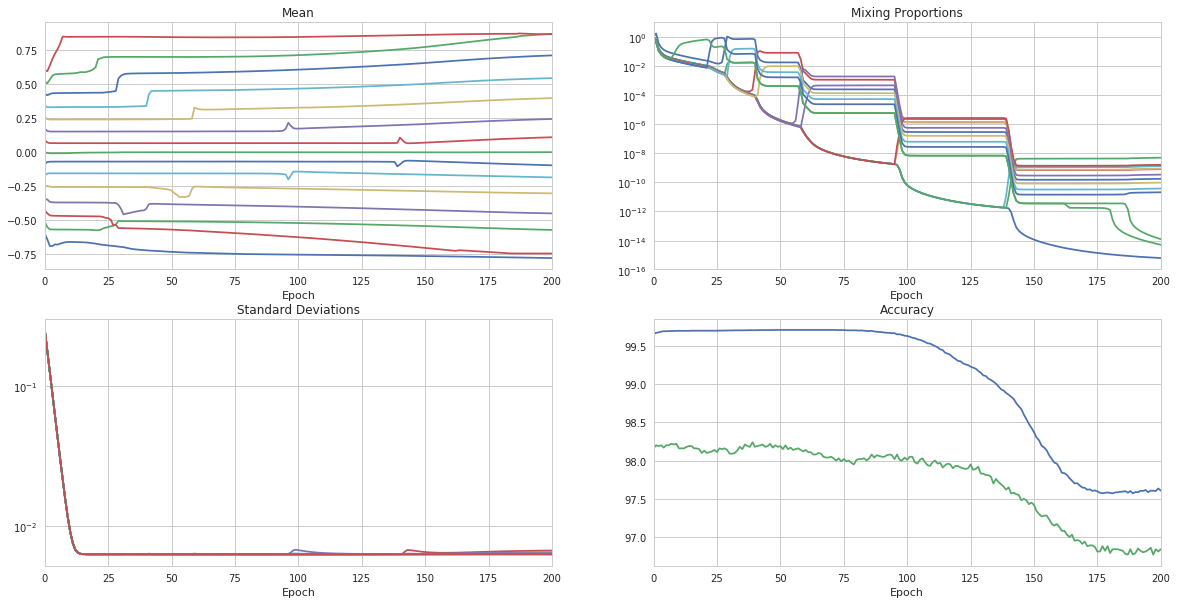

**Epoch: 1**

Layer Loss: 147291.625
Layer Loss: 165.992
Layer Loss: 21380.977
Layer Loss: 63.684
Layer Loss: 998.946
Layer Loss: 5.666
0-neglogprop Loss: -13828.171
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -1039439.125
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 2**

Layer Loss: 104479.430
Layer Loss: 94.820
Layer Loss: 18334.809
Layer Loss: 47.348
Layer Loss: 1148.407
Layer Loss: 3.417
0-neglogprop Loss: -16962.064
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -1303519.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 3**

Layer Loss: 87324.680
Layer Loss: 59.584
Layer Loss: 18751.447
Layer Loss: 43.218
Layer Loss: 1374.462
Layer Loss: 2.387
0-neglogprop Loss: -18910.607
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -1567214.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 4**

Layer Loss: 80845.195
Layer Loss: 47.533
Layer Loss: 19423.715
Layer Loss: 43.125
Layer Loss: 1494.721
Layer Loss: 2.068
0-neglogprop Loss: -19708.898
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -1830086.875
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 5**

Layer Loss: 76489.594
Layer Loss: 43.076
Layer Loss: 19563.373
Layer Loss: 43.144
Layer Loss: 1545.449
Layer Loss: 1.963
0-neglogprop Loss: -19997.664
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -2091169.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 6**

Layer Loss: 72584.031
Layer Loss: 40.271
Layer Loss: 19516.568
Layer Loss: 42.915
Layer Loss: 1586.591
Layer Loss: 1.900
0-neglogprop Loss: -20155.814
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -2348815.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 7**

Layer Loss: 68794.406
Layer Loss: 37.835
Layer Loss: 19403.951
Layer Loss: 42.571
Layer Loss: 1636.809
Layer Loss: 1.846
0-neglogprop Loss: -20283.543
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -2599766.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 8**

Layer Loss: 64953.125
Layer Loss: 35.368
Layer Loss: 19275.271
Layer Loss: 42.137
Layer Loss: 1672.418
Layer Loss: 1.785
0-neglogprop Loss: -20413.473
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -2837735.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 9**

Layer Loss: 61029.863
Layer Loss: 32.793
Layer Loss: 19123.303
Layer Loss: 41.636
Layer Loss: 1704.549
Layer Loss: 1.718
0-neglogprop Loss: -20551.262
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3051570.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 10**

Layer Loss: 56992.199
Layer Loss: 30.132
Layer Loss: 18930.693
Layer Loss: 41.127
Layer Loss: 1735.682
Layer Loss: 1.653
0-neglogprop Loss: -20695.807
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3224923.000
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 10. Training Accuracy: 99.70. Test Accuracy: 98.16
Means: [-0.662, -0.57, -0.47, -0.371, -0.257, -0.157, -0.07, -0.008, 0.065, 0.151, 0.24, 0.331, 0.435, 0.578, 0.854]
Mixing Proportions: [4.176, -2.903, -3.946, -3.937, -3.858, -3.766, -3.705, -3.69, -3.729, -3.821, -3.936, -3.99, -4.005, -4.009, -1.407]
Precisions: [4.197, 9.374, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391]


**Epoch: 11**

Layer Loss: 52824.320
Layer Loss: 27.328
Layer Loss: 18718.965
Layer Loss: 40.541
Layer Loss: 1764.107
Layer Loss: 1.585
0-neglogprop Loss: -20849.836
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3341513.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 12**

Layer Loss: 48584.164
Layer Loss: 24.475
Layer Loss: 18498.963
Layer Loss: 39.885
Layer Loss: 1789.680
Layer Loss: 1.509
0-neglogprop Loss: -21008.430
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3399329.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 13**

Layer Loss: 44287.789
Layer Loss: 21.508
Layer Loss: 18265.348
Layer Loss: 39.102
Layer Loss: 1813.921
Layer Loss: 1.427
0-neglogprop Loss: -21170.031
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3418086.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 14**

Layer Loss: 39938.672
Layer Loss: 18.423
Layer Loss: 18018.535
Layer Loss: 38.190
Layer Loss: 1842.083
Layer Loss: 1.338
0-neglogprop Loss: -21335.346
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3421830.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 15**

Layer Loss: 35531.672
Layer Loss: 15.239
Layer Loss: 17758.020
Layer Loss: 37.143
Layer Loss: 1874.968
Layer Loss: 1.242
0-neglogprop Loss: -21504.516
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422296.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 16**

Layer Loss: 31078.574
Layer Loss: 12.069
Layer Loss: 17492.027
Layer Loss: 36.005
Layer Loss: 1911.393
Layer Loss: 1.136
0-neglogprop Loss: -21677.012
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 17**

Layer Loss: 26567.318
Layer Loss: 8.809
Layer Loss: 17208.271
Layer Loss: 34.952
Layer Loss: 1950.090
Layer Loss: 1.039
0-neglogprop Loss: -21851.855
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 18**

Layer Loss: 21923.008
Layer Loss: 5.340
Layer Loss: 16918.223
Layer Loss: 33.731
Layer Loss: 1984.380
Layer Loss: 0.931
0-neglogprop Loss: -22033.184
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 19**

Layer Loss: 17125.113
Layer Loss: 1.813
Layer Loss: 16613.111
Layer Loss: 32.424
Layer Loss: 2025.903
Layer Loss: 0.821
0-neglogprop Loss: -22220.219
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 20**

Layer Loss: 12171.432
Layer Loss: -1.989
Layer Loss: 16278.852
Layer Loss: 31.002
Layer Loss: 2067.259
Layer Loss: 0.698
0-neglogprop Loss: -22415.527
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 20. Training Accuracy: 99.70. Test Accuracy: 98.11
Means: [-0.676, -0.576, -0.472, -0.371, -0.257, -0.157, -0.07, -0.004, 0.065, 0.151, 0.24, 0.331, 0.436, 0.617, 0.854]
Mixing Proportions: [4.902, -3.726, -4.768, -4.759, -4.68, -4.589, -4.528, -4.514, -4.552, -4.643, -4.757, -4.811, -4.826, -4.824, -0.475]
Precisions: [4.561, 10.131, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127]


**Epoch: 21**

Layer Loss: 7127.760
Layer Loss: -5.895
Layer Loss: 15901.801
Layer Loss: 29.434
Layer Loss: 2109.639
Layer Loss: 0.575
0-neglogprop Loss: -22611.418
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 22**

Layer Loss: 1994.737
Layer Loss: -10.092
Layer Loss: 15505.928
Layer Loss: 27.727
Layer Loss: 2159.224
Layer Loss: 0.437
0-neglogprop Loss: -22811.084
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 23**

Layer Loss: -3275.695
Layer Loss: -14.327
Layer Loss: 15111.097
Layer Loss: 25.932
Layer Loss: 2214.735
Layer Loss: 0.296
0-neglogprop Loss: -23017.926
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 24**

Layer Loss: -8651.347
Layer Loss: -18.717
Layer Loss: 14688.547
Layer Loss: 24.043
Layer Loss: 2275.287
Layer Loss: 0.145
0-neglogprop Loss: -23229.932
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 25**

Layer Loss: -14094.861
Layer Loss: -23.269
Layer Loss: 14259.251
Layer Loss: 22.050
Layer Loss: 2334.418
Layer Loss: -0.004
0-neglogprop Loss: -23436.523
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 26**

Layer Loss: -19614.635
Layer Loss: -27.948
Layer Loss: 13841.649
Layer Loss: 19.923
Layer Loss: 2396.428
Layer Loss: -0.165
0-neglogprop Loss: -23648.096
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 27**

Layer Loss: -25234.932
Layer Loss: -32.718
Layer Loss: 13421.511
Layer Loss: 17.828
Layer Loss: 2435.745
Layer Loss: -0.320
0-neglogprop Loss: -23864.381
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 28**

Layer Loss: -30986.941
Layer Loss: -37.697
Layer Loss: 13008.788
Layer Loss: 15.515
Layer Loss: 2477.798
Layer Loss: -0.500
0-neglogprop Loss: -24085.969
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 29**

Layer Loss: -36884.316
Layer Loss: -42.494
Layer Loss: 12602.785
Layer Loss: 13.474
Layer Loss: 2528.547
Layer Loss: -0.660
0-neglogprop Loss: -24325.672
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 30**

Layer Loss: -42880.141
Layer Loss: -47.357
Layer Loss: 12144.184
Layer Loss: 11.603
Layer Loss: 2531.240
Layer Loss: -0.804
0-neglogprop Loss: -24571.184
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 30. Training Accuracy: 99.70. Test Accuracy: 98.15
Means: [-0.698, -0.514, -0.473, -0.401, -0.257, -0.157, -0.07, -0.002, 0.065, 0.151, 0.24, 0.332, 0.564, 0.697, 0.854]
Mixing Proportions: [1.656, -0.106, -7.014, -7.121, -7.051, -6.966, -6.909, -6.896, -6.932, -7.017, -7.123, -7.173, -3.458, -2.263, -3.707]
Precisions: [5.021, 10.134, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.126, 10.127, 10.127]


**Epoch: 31**

Layer Loss: -48728.734
Layer Loss: -51.918
Layer Loss: 11658.995
Layer Loss: 9.505
Layer Loss: 2586.008
Layer Loss: -0.953
0-neglogprop Loss: -24798.795
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 32**

Layer Loss: -54578.203
Layer Loss: -56.297
Layer Loss: 11178.280
Layer Loss: 7.672
Layer Loss: 2643.128
Layer Loss: -1.080
0-neglogprop Loss: -25024.721
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 33**

Layer Loss: -60516.180
Layer Loss: -60.519
Layer Loss: 10748.773
Layer Loss: 5.834
Layer Loss: 2705.620
Layer Loss: -1.198
0-neglogprop Loss: -25251.650
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 34**

Layer Loss: -66444.586
Layer Loss: -64.641
Layer Loss: 10300.660
Layer Loss: 4.001
Layer Loss: 2779.042
Layer Loss: -1.310
0-neglogprop Loss: -25473.730
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 35**

Layer Loss: -72432.375
Layer Loss: -68.665
Layer Loss: 9860.864
Layer Loss: 2.183
Layer Loss: 2820.298
Layer Loss: -1.419
0-neglogprop Loss: -25702.166
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 36**

Layer Loss: -78334.516
Layer Loss: -72.811
Layer Loss: 9410.624
Layer Loss: 0.287
Layer Loss: 2870.893
Layer Loss: -1.533
0-neglogprop Loss: -25916.070
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 37**

Layer Loss: -84187.688
Layer Loss: -76.620
Layer Loss: 8987.772
Layer Loss: -1.476
Layer Loss: 2940.214
Layer Loss: -1.635
0-neglogprop Loss: -26130.186
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 38**

Layer Loss: -89930.875
Layer Loss: -80.279
Layer Loss: 8563.757
Layer Loss: -2.979
Layer Loss: 3017.371
Layer Loss: -1.705
0-neglogprop Loss: -26337.127
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 39**

Layer Loss: -95573.531
Layer Loss: -83.757
Layer Loss: 8138.327
Layer Loss: -4.652
Layer Loss: 3103.252
Layer Loss: -1.804
0-neglogprop Loss: -26542.125
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 40**

Layer Loss: -101309.516
Layer Loss: -87.079
Layer Loss: 7827.767
Layer Loss: -5.939
Layer Loss: 3183.571
Layer Loss: -1.873
0-neglogprop Loss: -26776.941
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 40. Training Accuracy: 99.71. Test Accuracy: 98.18
Means: [-0.724, -0.52, -0.375, -0.42, -0.26, -0.157, -0.07, -0.002, 0.065, 0.151, 0.24, 0.415, 0.581, 0.697, 0.854]
Mixing Proportions: [-1.779, -3.342, -2.28, -3.539, -10.304, -10.232, -10.182, -10.17, -10.201, -10.275, -10.366, -9.95, -4.542, -5.33, -6.856]
Precisions: [5.549, 10.131, 10.127, 10.114, 10.126, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127]


**Epoch: 41**

Layer Loss: -109671.359
Layer Loss: -88.433
Layer Loss: 7767.441
Layer Loss: -5.518
Layer Loss: 3060.747
Layer Loss: -1.816
0-neglogprop Loss: -27224.721
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 42**

Layer Loss: -116297.242
Layer Loss: -90.832
Layer Loss: 7163.175
Layer Loss: -6.254
Layer Loss: 3078.355
Layer Loss: -1.839
0-neglogprop Loss: -27494.963
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 43**

Layer Loss: -122273.898
Layer Loss: -93.493
Layer Loss: 6575.316
Layer Loss: -7.384
Layer Loss: 3123.160
Layer Loss: -1.875
0-neglogprop Loss: -27703.139
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 44**

Layer Loss: -128039.133
Layer Loss: -95.880
Layer Loss: 6095.606
Layer Loss: -8.366
Layer Loss: 3194.778
Layer Loss: -1.901
0-neglogprop Loss: -27903.969
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 45**

Layer Loss: -133657.906
Layer Loss: -98.197
Layer Loss: 5702.049
Layer Loss: -9.314
Layer Loss: 3279.050
Layer Loss: -1.933
0-neglogprop Loss: -28101.500
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 46**

Layer Loss: -139203.531
Layer Loss: -100.116
Layer Loss: 5310.619
Layer Loss: -10.025
Layer Loss: 3369.327
Layer Loss: -1.937
0-neglogprop Loss: -28294.975
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 47**

Layer Loss: -144649.031
Layer Loss: -101.981
Layer Loss: 4934.137
Layer Loss: -10.574
Layer Loss: 3461.501
Layer Loss: -1.934
0-neglogprop Loss: -28480.086
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 48**

Layer Loss: -149958.297
Layer Loss: -103.479
Layer Loss: 4576.820
Layer Loss: -11.194
Layer Loss: 3556.548
Layer Loss: -1.933
0-neglogprop Loss: -28659.418
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 49**

Layer Loss: -155218.625
Layer Loss: -104.834
Layer Loss: 4237.985
Layer Loss: -11.594
Layer Loss: 3656.471
Layer Loss: -1.909
0-neglogprop Loss: -28836.410
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 50**

Layer Loss: -160333.797
Layer Loss: -106.195
Layer Loss: 3899.203
Layer Loss: -11.998
Layer Loss: 3756.399
Layer Loss: -1.903
0-neglogprop Loss: -29005.135
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.000
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 50. Training Accuracy: 99.71. Test Accuracy: 98.16
Means: [-0.736, -0.523, -0.372, -0.423, -0.271, -0.157, -0.07, -0.001, 0.065, 0.151, 0.241, 0.454, 0.582, 0.696, 0.853]
Mixing Proportions: [-2.292, -4.124, -2.449, -4.018, -13.368, -13.307, -13.265, -13.255, -13.281, -13.344, -13.423, -4.615, -5.616, -6.427, -7.813]
Precisions: [5.997, 10.127, 10.128, 10.135, 10.128, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.128, 10.127, 10.127, 10.127]


**Epoch: 51**

Layer Loss: -165395.688
Layer Loss: -107.391
Layer Loss: 3593.593
Layer Loss: -12.316
Layer Loss: 3863.531
Layer Loss: -1.877
0-neglogprop Loss: -29174.568
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 52**

Layer Loss: -170304.281
Layer Loss: -108.255
Layer Loss: 3272.462
Layer Loss: -12.436
Layer Loss: 3968.185
Layer Loss: -1.841
0-neglogprop Loss: -29332.836
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 53**

Layer Loss: -175159.344
Layer Loss: -109.237
Layer Loss: 2980.179
Layer Loss: -12.533
Layer Loss: 4079.058
Layer Loss: -1.802
0-neglogprop Loss: -29490.820
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 54**

Layer Loss: -179937.359
Layer Loss: -110.119
Layer Loss: 2677.760
Layer Loss: -12.832
Layer Loss: 4190.170
Layer Loss: -1.783
0-neglogprop Loss: -29642.668
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 55**

Layer Loss: -184606.469
Layer Loss: -110.672
Layer Loss: 2390.107
Layer Loss: -12.606
Layer Loss: 4305.134
Layer Loss: -1.717
0-neglogprop Loss: -29791.303
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 56**

Layer Loss: -189172.297
Layer Loss: -111.209
Layer Loss: 2100.258
Layer Loss: -12.328
Layer Loss: 4420.234
Layer Loss: -1.650
0-neglogprop Loss: -29933.943
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 57**

Layer Loss: -193653.938
Layer Loss: -111.732
Layer Loss: 1808.849
Layer Loss: -12.155
Layer Loss: 4536.698
Layer Loss: -1.591
0-neglogprop Loss: -30071.857
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 58**

Layer Loss: -198075.422
Layer Loss: -112.055
Layer Loss: 1534.246
Layer Loss: -11.966
Layer Loss: 4658.351
Layer Loss: -1.530
0-neglogprop Loss: -30208.496
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 59**

Layer Loss: -202388.562
Layer Loss: -112.127
Layer Loss: 1262.978
Layer Loss: -11.569
Layer Loss: 4780.650
Layer Loss: -1.456
0-neglogprop Loss: -30339.795
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 60**

Layer Loss: -206635.484
Layer Loss: -112.351
Layer Loss: 996.468
Layer Loss: -11.210
Layer Loss: 4905.984
Layer Loss: -1.392
0-neglogprop Loss: -30468.090
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 60. Training Accuracy: 99.71. Test Accuracy: 98.11
Means: [-0.742, -0.526, -0.374, -0.427, -0.309, -0.156, -0.07, -0.001, 0.065, 0.151, 0.246, 0.455, 0.585, 0.696, 0.852]
Mixing Proportions: [-2.285, -4.119, -2.444, -4.013, -14.156, -14.447, -14.413, -14.405, -14.426, -14.477, -14.538, -4.609, -5.611, -6.422, -7.808]
Precisions: [6.348, 10.134, 10.128, 10.135, 10.128, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.128, 10.127, 10.127, 10.127]


**Epoch: 61**

Layer Loss: -210805.266
Layer Loss: -112.491
Layer Loss: 719.130
Layer Loss: -10.796
Layer Loss: 5031.375
Layer Loss: -1.299
0-neglogprop Loss: -30591.246
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 62**

Layer Loss: -214979.797
Layer Loss: -112.188
Layer Loss: 491.638
Layer Loss: -10.137
Layer Loss: 5169.021
Layer Loss: -1.213
0-neglogprop Loss: -30719.205
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 63**

Layer Loss: -219085.469
Layer Loss: -111.820
Layer Loss: 264.086
Layer Loss: -9.459
Layer Loss: 5292.763
Layer Loss: -1.129
0-neglogprop Loss: -30843.365
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 64**

Layer Loss: -224488.031
Layer Loss: -105.212
Layer Loss: 498.608
Layer Loss: -5.406
Layer Loss: 5486.998
Layer Loss: -0.692
0-neglogprop Loss: -31113.621
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 65**

Layer Loss: -232631.891
Layer Loss: -91.072
Layer Loss: 713.045
Layer Loss: 2.338
Layer Loss: 5908.959
Layer Loss: 0.127
0-neglogprop Loss: -31502.760
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422315.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 66**

Layer Loss: -237885.641
Layer Loss: -87.940
Layer Loss: -36.515
Layer Loss: 4.267
Layer Loss: 5948.597
Layer Loss: 0.368
0-neglogprop Loss: -31653.436
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422326.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 67**

Layer Loss: -242567.391
Layer Loss: -86.103
Layer Loss: -612.713
Layer Loss: 5.627
Layer Loss: 6000.384
Layer Loss: 0.543
0-neglogprop Loss: -31776.463
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422331.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 68**

Layer Loss: -247026.812
Layer Loss: -84.516
Layer Loss: -1019.812
Layer Loss: 7.060
Layer Loss: 6080.197
Layer Loss: 0.745
0-neglogprop Loss: -31892.234
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 69**

Layer Loss: -251341.391
Layer Loss: -82.763
Layer Loss: -1361.409
Layer Loss: 8.419
Layer Loss: 6165.743
Layer Loss: 0.915
0-neglogprop Loss: -32004.340
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 70**

Layer Loss: -255532.453
Layer Loss: -81.027
Layer Loss: -1661.070
Layer Loss: 10.128
Layer Loss: 6245.294
Layer Loss: 1.135
0-neglogprop Loss: -32112.447
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 70. Training Accuracy: 99.71. Test Accuracy: 98.01
Means: [-0.747, -0.529, -0.377, -0.43, -0.227, -0.158, -0.07, -0.001, 0.065, 0.151, 0.299, 0.457, 0.589, 0.696, 0.85]
Mixing Proportions: [-6.607, -8.445, -6.77, -8.338, -6.174, -17.945, -17.929, -17.925, -17.935, -17.958, -7.641, -8.935, -9.936, -10.747, -12.134]
Precisions: [6.805, 10.129, 10.128, 10.135, 10.128, 10.131, 10.127, 10.127, 10.127, 10.127, 10.127, 10.123, 10.128, 10.127, 10.127, 10.127]


**Epoch: 71**

Layer Loss: -259600.406
Layer Loss: -79.338
Layer Loss: -1963.286
Layer Loss: 11.431
Layer Loss: 6326.323
Layer Loss: 1.296
0-neglogprop Loss: -32213.916
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 72**

Layer Loss: -263685.125
Layer Loss: -76.962
Layer Loss: -2196.616
Layer Loss: 13.279
Layer Loss: 6422.680
Layer Loss: 1.525
0-neglogprop Loss: -32320.242
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 73**

Layer Loss: -267632.781
Layer Loss: -75.274
Layer Loss: -2487.954
Layer Loss: 14.822
Layer Loss: 6514.665
Layer Loss: 1.701
0-neglogprop Loss: -32414.939
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 74**

Layer Loss: -271453.812
Layer Loss: -73.435
Layer Loss: -2788.166
Layer Loss: 16.742
Layer Loss: 6616.597
Layer Loss: 1.938
0-neglogprop Loss: -32504.223
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 75**

Layer Loss: -275189.219
Layer Loss: -71.743
Layer Loss: -3082.264
Layer Loss: 18.362
Layer Loss: 6722.593
Layer Loss: 2.123
0-neglogprop Loss: -32590.229
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 76**

Layer Loss: -278832.344
Layer Loss: -69.822
Layer Loss: -3379.833
Layer Loss: 19.974
Layer Loss: 6833.031
Layer Loss: 2.322
0-neglogprop Loss: -32671.951
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 77**

Layer Loss: -282403.281
Layer Loss: -68.012
Layer Loss: -3665.420
Layer Loss: 21.765
Layer Loss: 6946.914
Layer Loss: 2.532
0-neglogprop Loss: -32751.367
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 78**

Layer Loss: -285938.625
Layer Loss: -66.476
Layer Loss: -3944.632
Layer Loss: 23.159
Layer Loss: 7060.418
Layer Loss: 2.694
0-neglogprop Loss: -32829.355
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 79**

Layer Loss: -289400.688
Layer Loss: -64.331
Layer Loss: -4220.234
Layer Loss: 25.131
Layer Loss: 7170.725
Layer Loss: 2.916
0-neglogprop Loss: -32904.188
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 80**

Layer Loss: -292798.688
Layer Loss: -62.426
Layer Loss: -4513.388
Layer Loss: 26.722
Layer Loss: 7270.500
Layer Loss: 3.093
0-neglogprop Loss: -32974.848
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 80. Training Accuracy: 99.70. Test Accuracy: 98.04
Means: [-0.751, -0.533, -0.379, -0.434, -0.231, -0.158, -0.07, -0.001, 0.065, 0.152, 0.302, 0.461, 0.594, 0.698, 0.85]
Mixing Proportions: [-6.611, -8.451, -6.776, -8.344, -6.165, -19.145, -19.138, -19.136, -19.143, -19.146, -7.637, -8.941, -9.943, -10.754, -12.14]
Precisions: [7.09, 10.128, 10.128, 10.134, 10.128, 10.136, 10.127, 10.127, 10.127, 10.127, 10.127, 10.126, 10.127, 10.127, 10.127, 10.127]


**Epoch: 81**

Layer Loss: -296147.469
Layer Loss: -60.463
Layer Loss: -4798.130
Layer Loss: 28.728
Layer Loss: 7379.795
Layer Loss: 3.307
0-neglogprop Loss: -33043.461
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 82**

Layer Loss: -299468.719
Layer Loss: -57.960
Layer Loss: -5073.245
Layer Loss: 30.544
Layer Loss: 7493.196
Layer Loss: 3.517
0-neglogprop Loss: -33110.918
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 83**

Layer Loss: -302725.438
Layer Loss: -56.478
Layer Loss: -5361.062
Layer Loss: 32.096
Layer Loss: 7602.661
Layer Loss: 3.667
0-neglogprop Loss: -33174.570
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 84**

Layer Loss: -305931.219
Layer Loss: -54.334
Layer Loss: -5651.547
Layer Loss: 33.992
Layer Loss: 7712.469
Layer Loss: 3.875
0-neglogprop Loss: -33235.566
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 85**

Layer Loss: -309099.438
Layer Loss: -52.628
Layer Loss: -5942.458
Layer Loss: 35.784
Layer Loss: 7825.402
Layer Loss: 4.054
0-neglogprop Loss: -33294.293
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 86**

Layer Loss: -312221.500
Layer Loss: -50.118
Layer Loss: -6242.307
Layer Loss: 37.662
Layer Loss: 7937.597
Layer Loss: 4.243
0-neglogprop Loss: -33350.359
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 87**

Layer Loss: -315303.594
Layer Loss: -47.970
Layer Loss: -6536.982
Layer Loss: 39.863
Layer Loss: 8057.306
Layer Loss: 4.454
0-neglogprop Loss: -33404.301
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 88**

Layer Loss: -318329.219
Layer Loss: -45.793
Layer Loss: -6827.589
Layer Loss: 41.555
Layer Loss: 8182.223
Layer Loss: 4.647
0-neglogprop Loss: -33456.023
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 89**

Layer Loss: -321326.188
Layer Loss: -43.819
Layer Loss: -7135.205
Layer Loss: 43.611
Layer Loss: 8307.296
Layer Loss: 4.843
0-neglogprop Loss: -33504.863
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 90**

Layer Loss: -324314.438
Layer Loss: -41.461
Layer Loss: -7421.818
Layer Loss: 45.308
Layer Loss: 8435.691
Layer Loss: 4.981
0-neglogprop Loss: -33553.402
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 90. Training Accuracy: 99.68. Test Accuracy: 98.08
Means: [-0.753, -0.537, -0.382, -0.438, -0.235, -0.16, -0.07, -0.001, 0.065, 0.155, 0.308, 0.464, 0.6, 0.702, 0.85]
Mixing Proportions: [-6.615, -8.456, -6.781, -8.349, -6.166, -19.828, -19.825, -19.823, -19.828, -19.829, -7.623, -8.946, -9.948, -10.759, -12.145]
Precisions: [7.334, 10.133, 10.128, 10.134, 10.128, 10.136, 10.127, 10.127, 10.127, 10.127, 10.127, 10.123, 10.128, 10.127, 10.127, 10.127]


**Epoch: 91**

Layer Loss: -327252.938
Layer Loss: -39.356
Layer Loss: -7716.332
Layer Loss: 47.497
Layer Loss: 8557.855
Layer Loss: 5.191
0-neglogprop Loss: -33599.016
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 92**

Layer Loss: -330132.594
Layer Loss: -36.853
Layer Loss: -8024.844
Layer Loss: 49.658
Layer Loss: 8680.952
Layer Loss: 5.413
0-neglogprop Loss: -33641.445
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 93**

Layer Loss: -332993.406
Layer Loss: -34.621
Layer Loss: -8335.317
Layer Loss: 51.672
Layer Loss: 8808.694
Layer Loss: 5.602
0-neglogprop Loss: -33682.176
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 94**

Layer Loss: -337376.938
Layer Loss: -17.766
Layer Loss: -7858.643
Layer Loss: 60.849
Layer Loss: 8609.767
Layer Loss: 6.507
0-neglogprop Loss: -33786.707
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422330.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 95**

Layer Loss: -342873.188
Layer Loss: -3.920
Layer Loss: -7869.229
Layer Loss: 73.326
Layer Loss: 8555.977
Layer Loss: 7.729
0-neglogprop Loss: -33892.070
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422299.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 96**

Layer Loss: -350395.750
Layer Loss: -33.553
Layer Loss: -8080.609
Layer Loss: 96.159
Layer Loss: 8613.255
Layer Loss: 10.059
0-neglogprop Loss: -34019.043
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422129.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 97**

Layer Loss: -355252.750
Layer Loss: -36.066
Layer Loss: -8443.053
Layer Loss: 106.466
Layer Loss: 8690.764
Layer Loss: 11.134
0-neglogprop Loss: -34063.754
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422093.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 98**

Layer Loss: -359399.781
Layer Loss: -35.308
Layer Loss: -8995.366
Layer Loss: 111.848
Layer Loss: 8637.046
Layer Loss: 11.679
0-neglogprop Loss: -34084.660
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422143.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 99**

Layer Loss: -363383.094
Layer Loss: -34.755
Layer Loss: -9595.171
Layer Loss: 116.388
Layer Loss: 8562.537
Layer Loss: 12.115
0-neglogprop Loss: -34098.426
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422192.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 100**

Layer Loss: -367283.719
Layer Loss: -34.372
Layer Loss: -10184.672
Layer Loss: 120.558
Layer Loss: 8487.840
Layer Loss: 12.523
0-neglogprop Loss: -34107.340
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422231.000
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 100. Training Accuracy: 99.61. Test Accuracy: 98.07
Means: [-0.754, -0.541, -0.386, -0.442, -0.238, -0.135, -0.07, -0.001, 0.066, 0.175, 0.311, 0.469, 0.606, 0.707, 0.851]
Mixing Proportions: [-13.017, -14.857, -13.182, -14.75, -12.567, -13.197, -24.016, -24.015, -24.016, -12.567, -14.008, -15.347, -16.349, -17.159, -18.546]
Precisions: [7.809, 10.134, 10.127, 10.134, 10.127, 10.138, 10.117, 10.127, 10.127, 10.127, 10.049, 10.122, 10.127, 10.127, 10.127, 10.127]


**Epoch: 101**

Layer Loss: -371164.812
Layer Loss: -32.823
Layer Loss: -10740.460
Layer Loss: 124.790
Layer Loss: 8424.229
Layer Loss: 12.959
0-neglogprop Loss: -34111.863
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422258.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 102**

Layer Loss: -374985.938
Layer Loss: -31.860
Layer Loss: -11267.256
Layer Loss: 129.149
Layer Loss: 8368.270
Layer Loss: 13.347
0-neglogprop Loss: -34111.793
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422277.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 103**

Layer Loss: -378727.219
Layer Loss: -29.973
Layer Loss: -11789.865
Layer Loss: 133.503
Layer Loss: 8321.457
Layer Loss: 13.758
0-neglogprop Loss: -34107.203
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422291.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 104**

Layer Loss: -382451.281
Layer Loss: -28.333
Layer Loss: -12296.302
Layer Loss: 138.237
Layer Loss: 8285.720
Layer Loss: 14.173
0-neglogprop Loss: -34097.988
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422302.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 105**

Layer Loss: -386181.656
Layer Loss: -26.718
Layer Loss: -12802.965
Layer Loss: 142.296
Layer Loss: 8259.787
Layer Loss: 14.585
0-neglogprop Loss: -34083.918
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422309.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 106**

Layer Loss: -389873.156
Layer Loss: -24.978
Layer Loss: -13307.002
Layer Loss: 146.694
Layer Loss: 8240.398
Layer Loss: 14.973
0-neglogprop Loss: -34065.289
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422314.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 107**

Layer Loss: -393546.625
Layer Loss: -22.846
Layer Loss: -13809.756
Layer Loss: 151.403
Layer Loss: 8230.112
Layer Loss: 15.397
0-neglogprop Loss: -34041.797
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422319.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 108**

Layer Loss: -397192.750
Layer Loss: -20.464
Layer Loss: -14306.270
Layer Loss: 156.148
Layer Loss: 8227.491
Layer Loss: 15.804
0-neglogprop Loss: -34013.293
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422322.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 109**

Layer Loss: -400864.281
Layer Loss: -18.064
Layer Loss: -14797.322
Layer Loss: 160.600
Layer Loss: 8233.167
Layer Loss: 16.180
0-neglogprop Loss: -33978.996
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422324.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 110**

Layer Loss: -404501.000
Layer Loss: -15.637
Layer Loss: -15301.303
Layer Loss: 165.465
Layer Loss: 8244.889
Layer Loss: 16.577
0-neglogprop Loss: -33940.141
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422326.250
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 110. Training Accuracy: 99.48. Test Accuracy: 98.02
Means: [-0.756, -0.546, -0.389, -0.447, -0.241, -0.139, -0.072, -0.001, 0.066, 0.181, 0.316, 0.474, 0.614, 0.715, 0.852]
Mixing Proportions: [-13.018, -14.859, -13.184, -14.752, -12.569, -13.177, -25.331, -25.331, -25.331, -12.567, -14.01, -15.349, -16.35, -17.161, -18.548]
Precisions: [8.105, 10.134, 10.127, 10.133, 10.127, 10.138, 10.129, 10.127, 10.127, 10.127, 10.108, 10.125, 10.127, 10.127, 10.127, 10.127]


**Epoch: 111**

Layer Loss: -408136.969
Layer Loss: -12.385
Layer Loss: -15801.829
Layer Loss: 170.602
Layer Loss: 8265.560
Layer Loss: 17.055
0-neglogprop Loss: -33895.598
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422327.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 112**

Layer Loss: -411793.438
Layer Loss: -10.012
Layer Loss: -16305.392
Layer Loss: 175.404
Layer Loss: 8291.798
Layer Loss: 17.431
0-neglogprop Loss: -33844.711
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422328.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 113**

Layer Loss: -415442.062
Layer Loss: -7.433
Layer Loss: -16819.078
Layer Loss: 179.989
Layer Loss: 8320.384
Layer Loss: 17.760
0-neglogprop Loss: -33788.918
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422329.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 114**

Layer Loss: -419094.938
Layer Loss: -2.957
Layer Loss: -17329.574
Layer Loss: 185.730
Layer Loss: 8355.786
Layer Loss: 18.260
0-neglogprop Loss: -33726.145
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422330.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 115**

Layer Loss: -422746.812
Layer Loss: -0.644
Layer Loss: -17853.941
Layer Loss: 190.661
Layer Loss: 8394.549
Layer Loss: 18.655
0-neglogprop Loss: -33657.668
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422330.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 116**

Layer Loss: -426418.562
Layer Loss: 2.852
Layer Loss: -18375.256
Layer Loss: 195.553
Layer Loss: 8438.398
Layer Loss: 19.003
0-neglogprop Loss: -33582.324
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422331.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 117**

Layer Loss: -430139.625
Layer Loss: 6.378
Layer Loss: -18904.936
Layer Loss: 200.832
Layer Loss: 8484.978
Layer Loss: 19.406
0-neglogprop Loss: -33499.562
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422331.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 118**

Layer Loss: -433884.812
Layer Loss: 9.899
Layer Loss: -19431.838
Layer Loss: 206.049
Layer Loss: 8537.124
Layer Loss: 19.773
0-neglogprop Loss: -33408.000
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422331.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 119**

Layer Loss: -437590.344
Layer Loss: 13.959
Layer Loss: -19962.520
Layer Loss: 211.877
Layer Loss: 8592.049
Layer Loss: 20.213
0-neglogprop Loss: -33309.797
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422331.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 120**

Layer Loss: -441320.438
Layer Loss: 17.392
Layer Loss: -20512.449
Layer Loss: 216.952
Layer Loss: 8644.966
Layer Loss: 20.502
0-neglogprop Loss: -33205.352
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.000
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 120. Training Accuracy: 99.29. Test Accuracy: 97.96
Means: [-0.757, -0.551, -0.393, -0.452, -0.244, -0.143, -0.072, -0.001, 0.066, 0.187, 0.322, 0.48, 0.622, 0.725, 0.854]
Mixing Proportions: [-13.018, -14.859, -13.184, -14.752, -12.569, -13.177, -26.083, -26.083, -26.086, -12.567, -14.009, -15.349, -16.35, -17.161, -18.547]
Precisions: [8.402, 10.133, 10.126, 10.132, 10.127, 10.137, 10.131, 10.127, 10.127, 10.127, 10.121, 10.125, 10.127, 10.127, 10.127, 10.127]


**Epoch: 121**

Layer Loss: -445091.562
Layer Loss: 21.700
Layer Loss: -21061.336
Layer Loss: 223.159
Layer Loss: 8705.037
Layer Loss: 20.972
0-neglogprop Loss: -33091.184
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 122**

Layer Loss: -448866.375
Layer Loss: 25.968
Layer Loss: -21610.012
Layer Loss: 228.559
Layer Loss: 8765.519
Layer Loss: 21.320
0-neglogprop Loss: -32967.938
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 123**

Layer Loss: -452664.344
Layer Loss: 29.878
Layer Loss: -22173.293
Layer Loss: 234.321
Layer Loss: 8827.456
Layer Loss: 21.696
0-neglogprop Loss: -32837.113
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 124**

Layer Loss: -456494.156
Layer Loss: 34.100
Layer Loss: -22738.264
Layer Loss: 239.957
Layer Loss: 8889.863
Layer Loss: 22.075
0-neglogprop Loss: -32695.717
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 125**

Layer Loss: -460304.094
Layer Loss: 39.214
Layer Loss: -23301.885
Layer Loss: 246.235
Layer Loss: 8951.551
Layer Loss: 22.427
0-neglogprop Loss: -32545.906
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 126**

Layer Loss: -464115.562
Layer Loss: 44.332
Layer Loss: -23867.812
Layer Loss: 252.573
Layer Loss: 9015.382
Layer Loss: 22.883
0-neglogprop Loss: -32385.891
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 127**

Layer Loss: -467985.000
Layer Loss: 48.623
Layer Loss: -24454.539
Layer Loss: 258.162
Layer Loss: 9079.042
Layer Loss: 23.116
0-neglogprop Loss: -32216.500
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 128**

Layer Loss: -471798.406
Layer Loss: 53.738
Layer Loss: -25034.914
Layer Loss: 264.693
Layer Loss: 9142.232
Layer Loss: 23.458
0-neglogprop Loss: -32039.137
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 129**

Layer Loss: -475725.719
Layer Loss: 58.208
Layer Loss: -25619.262
Layer Loss: 270.352
Layer Loss: 9210.325
Layer Loss: 23.717
0-neglogprop Loss: -31844.242
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 130**

Layer Loss: -479631.969
Layer Loss: 63.127
Layer Loss: -26208.949
Layer Loss: 276.538
Layer Loss: 9276.922
Layer Loss: 24.066
0-neglogprop Loss: -31640.449
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 130. Training Accuracy: 99.06. Test Accuracy: 97.84
Means: [-0.759, -0.557, -0.397, -0.457, -0.248, -0.147, -0.073, -0.001, 0.065, 0.193, 0.329, 0.487, 0.631, 0.736, 0.857]
Mixing Proportions: [-13.017, -14.858, -13.183, -14.751, -12.568, -13.176, -26.582, -26.581, -26.58, -12.565, -14.009, -15.348, -16.349, -17.16, -18.547]
Precisions: [8.708, 10.132, 10.126, 10.131, 10.126, 10.135, 10.13, 10.127, 10.127, 10.127, 10.123, 10.125, 10.127, 10.127, 10.127, 10.127]


**Epoch: 131**

Layer Loss: -483527.406
Layer Loss: 69.163
Layer Loss: -26803.270
Layer Loss: 282.859
Layer Loss: 9342.555
Layer Loss: 24.287
0-neglogprop Loss: -31427.699
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 132**

Layer Loss: -487469.438
Layer Loss: 74.122
Layer Loss: -27396.305
Layer Loss: 288.938
Layer Loss: 9409.293
Layer Loss: 24.598
0-neglogprop Loss: -31199.416
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 133**

Layer Loss: -491407.094
Layer Loss: 78.944
Layer Loss: -27998.812
Layer Loss: 295.517
Layer Loss: 9474.846
Layer Loss: 24.878
0-neglogprop Loss: -30961.920
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 134**

Layer Loss: -495348.688
Layer Loss: 84.370
Layer Loss: -28594.057
Layer Loss: 301.595
Layer Loss: 9541.341
Layer Loss: 25.088
0-neglogprop Loss: -30708.432
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 135**

Layer Loss: -499344.906
Layer Loss: 89.925
Layer Loss: -29202.914
Layer Loss: 307.502
Layer Loss: 9604.997
Layer Loss: 25.161
0-neglogprop Loss: -30441.672
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 136**

Layer Loss: -503312.031
Layer Loss: 95.343
Layer Loss: -29821.727
Layer Loss: 313.795
Layer Loss: 9665.576
Layer Loss: 25.361
0-neglogprop Loss: -30165.168
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 137**

Layer Loss: -508548.344
Layer Loss: 115.750
Layer Loss: -29956.221
Layer Loss: 324.243
Layer Loss: 9333.930
Layer Loss: 26.919
0-neglogprop Loss: -29572.902
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 138**

Layer Loss: -517014.469
Layer Loss: 116.839
Layer Loss: -29741.652
Layer Loss: 296.773
Layer Loss: 8823.487
Layer Loss: 24.858
0-neglogprop Loss: -28267.203
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422330.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 139**

Layer Loss: -533242.375
Layer Loss: 121.968
Layer Loss: -29803.633
Layer Loss: 297.009
Layer Loss: 8886.429
Layer Loss: 21.522
0-neglogprop Loss: -25229.447
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422229.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 140**

Layer Loss: -546142.750
Layer Loss: 116.314
Layer Loss: -30488.779
Layer Loss: 289.948
Layer Loss: 9188.367
Layer Loss: 21.025
0-neglogprop Loss: -22722.916
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422094.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 140. Training Accuracy: 98.71. Test Accuracy: 97.61
Means: [-0.761, -0.563, -0.402, -0.463, -0.251, -0.15, -0.063, -0.001, 0.065, 0.2, 0.337, 0.495, 0.642, 0.75, 0.859]
Mixing Proportions: [-20.403, -22.242, -20.568, -22.136, -19.953, -20.561, -20.538, -30.303, -18.881, -19.948, -21.39, -22.73, -23.729, -24.529, -25.824]
Precisions: [9.483, 10.131, 10.125, 10.13, 10.125, 10.133, 10.128, 10.115, 10.127, 9.993, 10.121, 10.123, 10.126, 10.127, 10.127, 10.127]


**Epoch: 141**

Layer Loss: -555504.688
Layer Loss: 111.589
Layer Loss: -31817.223
Layer Loss: 292.536
Layer Loss: 9172.602
Layer Loss: 21.320
0-neglogprop Loss: -21143.863
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422118.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 142**

Layer Loss: -564520.250
Layer Loss: 104.601
Layer Loss: -33370.422
Layer Loss: 294.385
Layer Loss: 9106.539
Layer Loss: 21.528
0-neglogprop Loss: -19594.070
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422157.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 143**

Layer Loss: -573743.750
Layer Loss: 94.091
Layer Loss: -35026.062
Layer Loss: 296.748
Layer Loss: 9031.908
Layer Loss: 21.627
0-neglogprop Loss: -17920.074
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422191.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 144**

Layer Loss: -582937.625
Layer Loss: 83.720
Layer Loss: -36737.008
Layer Loss: 298.208
Layer Loss: 8953.247
Layer Loss: 21.540
0-neglogprop Loss: -16141.369
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422220.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 145**

Layer Loss: -592242.438
Layer Loss: 71.016
Layer Loss: -38488.152
Layer Loss: 298.366
Layer Loss: 8876.577
Layer Loss: 21.314
0-neglogprop Loss: -14223.949
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422244.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 146**

Layer Loss: -601690.938
Layer Loss: 55.872
Layer Loss: -40297.441
Layer Loss: 297.795
Layer Loss: 8798.314
Layer Loss: 21.022
0-neglogprop Loss: -12151.953
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422261.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 147**

Layer Loss: -610983.062
Layer Loss: 42.738
Layer Loss: -42075.793
Layer Loss: 297.646
Layer Loss: 8724.097
Layer Loss: 20.577
0-neglogprop Loss: -9967.531
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422274.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 148**

Layer Loss: -620407.438
Layer Loss: 29.042
Layer Loss: -43901.773
Layer Loss: 297.881
Layer Loss: 8653.758
Layer Loss: 20.254
0-neglogprop Loss: -7597.348
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422283.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 149**

Layer Loss: -629656.000
Layer Loss: 15.683
Layer Loss: -45718.645
Layer Loss: 297.677
Layer Loss: 8587.332
Layer Loss: 19.539
0-neglogprop Loss: -5134.871
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422291.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 150**

Layer Loss: -638901.875
Layer Loss: 1.807
Layer Loss: -47555.773
Layer Loss: 297.354
Layer Loss: 8526.215
Layer Loss: 18.977
0-neglogprop Loss: -2527.043
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422296.500
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 150. Training Accuracy: 98.25. Test Accuracy: 97.28
Means: [-0.763, -0.57, -0.407, -0.468, -0.254, -0.155, -0.068, -0.002, 0.073, 0.208, 0.346, 0.504, 0.654, 0.769, 0.861]
Mixing Proportions: [-20.417, -22.258, -20.585, -22.14, -19.968, -20.576, -20.474, -32.236, -18.869, -19.965, -21.409, -22.748, -23.749, -24.56, -25.947]
Precisions: [10.144, 10.128, 10.123, 10.128, 10.124, 10.128, 10.125, 10.123, 10.127, 10.076, 10.111, 10.12, 10.125, 10.127, 10.127, 10.127]


**Epoch: 151**

Layer Loss: -647956.625
Layer Loss: -11.367
Layer Loss: -49358.469
Layer Loss: 296.214
Layer Loss: 8466.108
Layer Loss: 17.996
0-neglogprop Loss: 158.262
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422300.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 152**

Layer Loss: -657004.312
Layer Loss: -24.355
Layer Loss: -51168.266
Layer Loss: 295.782
Layer Loss: 8411.506
Layer Loss: 17.098
0-neglogprop Loss: 3031.426
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422301.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 153**

Layer Loss: -665572.125
Layer Loss: -36.341
Layer Loss: -52917.973
Layer Loss: 294.338
Layer Loss: 8361.381
Layer Loss: 16.097
0-neglogprop Loss: 5874.828
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422302.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 154**

Layer Loss: -674058.125
Layer Loss: -49.509
Layer Loss: -54642.441
Layer Loss: 291.579
Layer Loss: 8314.921
Layer Loss: 15.119
0-neglogprop Loss: 8802.871
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422302.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 155**

Layer Loss: -682089.500
Layer Loss: -59.526
Layer Loss: -56285.785
Layer Loss: 289.020
Layer Loss: 8269.930
Layer Loss: 13.953
0-neglogprop Loss: 11729.582
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422301.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 156**

Layer Loss: -689722.938
Layer Loss: -69.392
Layer Loss: -57865.648
Layer Loss: 285.657
Layer Loss: 8229.245
Layer Loss: 12.776
0-neglogprop Loss: 14614.996
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422299.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 157**

Layer Loss: -697020.750
Layer Loss: -79.622
Layer Loss: -59368.664
Layer Loss: 280.641
Layer Loss: 8193.471
Layer Loss: 11.551
0-neglogprop Loss: 17469.844
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422297.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 158**

Layer Loss: -704001.000
Layer Loss: -88.302
Layer Loss: -60781.887
Layer Loss: 275.691
Layer Loss: 8161.696
Layer Loss: 10.186
0-neglogprop Loss: 20311.820
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422294.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 159**

Layer Loss: -710197.562
Layer Loss: -94.639
Layer Loss: -62074.223
Layer Loss: 269.706
Layer Loss: 8134.530
Layer Loss: 9.016
0-neglogprop Loss: 22910.246
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422290.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 160**

Layer Loss: -716002.438
Layer Loss: -100.066
Layer Loss: -63254.645
Layer Loss: 263.766
Layer Loss: 8107.544
Layer Loss: 7.646
0-neglogprop Loss: 25417.918
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422286.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 160. Training Accuracy: 97.83. Test Accuracy: 96.93
Means: [-0.765, -0.577, -0.411, -0.475, -0.257, -0.159, -0.074, -0.002, 0.082, 0.217, 0.355, 0.515, 0.667, 0.79, 0.863]
Mixing Proportions: [-20.417, -22.258, -20.586, -22.14, -19.968, -20.576, -20.472, -33.15, -18.869, -19.965, -21.409, -22.748, -23.75, -24.561, -25.947]
Precisions: [10.608, 10.126, 10.122, 10.125, 10.123, 10.122, 10.119, 10.121, 10.127, 10.072, 10.095, 10.115, 10.124, 10.127, 10.127, 10.127]


**Epoch: 161**

Layer Loss: -721625.062
Layer Loss: -107.549
Layer Loss: -64373.793
Layer Loss: 256.223
Layer Loss: 8086.193
Layer Loss: 6.385
0-neglogprop Loss: 27894.051
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422282.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 162**

Layer Loss: -726427.000
Layer Loss: -112.064
Layer Loss: -65374.656
Layer Loss: 248.738
Layer Loss: 8065.910
Layer Loss: 5.221
0-neglogprop Loss: 30061.438
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422277.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 163**

Layer Loss: -731007.625
Layer Loss: -118.170
Layer Loss: -66299.117
Layer Loss: 240.517
Layer Loss: 8047.833
Layer Loss: 4.144
0-neglogprop Loss: 32178.961
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422272.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 164**

Layer Loss: -735066.688
Layer Loss: -121.652
Layer Loss: -67117.750
Layer Loss: 233.367
Layer Loss: 8033.559
Layer Loss: 3.204
0-neglogprop Loss: 34086.613
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422265.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 165**

Layer Loss: -738949.562
Layer Loss: -126.840
Layer Loss: -67892.898
Layer Loss: 224.984
Layer Loss: 8018.792
Layer Loss: 2.197
0-neglogprop Loss: 35947.480
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422259.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 166**

Layer Loss: -742253.375
Layer Loss: -131.346
Layer Loss: -68565.828
Layer Loss: 217.414
Layer Loss: 8007.500
Layer Loss: 1.236
0-neglogprop Loss: 37561.477
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422253.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 167**

Layer Loss: -745348.750
Layer Loss: -134.877
Layer Loss: -69203.711
Layer Loss: 209.879
Layer Loss: 7994.755
Layer Loss: 0.345
0-neglogprop Loss: 39076.559
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422247.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 168**

Layer Loss: -748214.750
Layer Loss: -139.797
Layer Loss: -69779.719
Layer Loss: 202.031
Layer Loss: 7985.824
Layer Loss: -0.359
0-neglogprop Loss: 40512.816
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422240.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 169**

Layer Loss: -750837.188
Layer Loss: -145.028
Layer Loss: -70309.836
Layer Loss: 194.889
Layer Loss: 7974.966
Layer Loss: -1.018
0-neglogprop Loss: 41846.438
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422234.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 170**

Layer Loss: -753025.688
Layer Loss: -148.222
Layer Loss: -70774.094
Layer Loss: 187.633
Layer Loss: 7968.514
Layer Loss: -1.753
0-neglogprop Loss: 42986.668
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422227.000
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 170. Training Accuracy: 97.64. Test Accuracy: 96.79
Means: [-0.768, -0.585, -0.416, -0.481, -0.259, -0.163, -0.081, -0.001, 0.091, 0.225, 0.364, 0.524, 0.678, 0.811, 0.865]
Mixing Proportions: [-20.417, -22.258, -20.586, -22.14, -19.968, -20.576, -20.472, -33.754, -18.869, -19.965, -21.409, -22.748, -23.75, -24.561, -25.947]
Precisions: [10.801, 10.124, 10.121, 10.123, 10.122, 10.118, 10.114, 10.118, 10.127, 10.045, 10.081, 10.112, 10.123, 10.127, 10.127, 10.127]


**Epoch: 171**

Layer Loss: -755213.938
Layer Loss: -152.052
Layer Loss: -71234.734
Layer Loss: 181.093
Layer Loss: 7957.850
Layer Loss: -2.313
0-neglogprop Loss: 44126.359
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422219.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 172**

Layer Loss: -757207.312
Layer Loss: -157.827
Layer Loss: -71652.633
Layer Loss: 174.020
Layer Loss: 7950.611
Layer Loss: -2.775
0-neglogprop Loss: 45170.727
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422213.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 173**

Layer Loss: -759008.875
Layer Loss: -160.636
Layer Loss: -72054.461
Layer Loss: 167.674
Layer Loss: 7941.146
Layer Loss: -3.163
0-neglogprop Loss: 46133.555
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422206.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 174**

Layer Loss: -760461.562
Layer Loss: -163.398
Layer Loss: -72376.531
Layer Loss: 161.939
Layer Loss: 7934.281
Layer Loss: -3.564
0-neglogprop Loss: 46905.723
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422200.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 175**

Layer Loss: -762132.875
Layer Loss: -169.172
Layer Loss: -72701.102
Layer Loss: 156.053
Layer Loss: 7928.171
Layer Loss: -3.851
0-neglogprop Loss: 47804.762
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422193.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 176**

Layer Loss: -763659.688
Layer Loss: -174.600
Layer Loss: -73043.367
Layer Loss: 149.639
Layer Loss: 7918.123
Layer Loss: -4.204
0-neglogprop Loss: 48635.512
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422187.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 177**

Layer Loss: -764887.062
Layer Loss: -177.247
Layer Loss: -73308.672
Layer Loss: 144.709
Layer Loss: 7911.322
Layer Loss: -4.348
0-neglogprop Loss: 49305.422
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422180.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 178**

Layer Loss: -766187.812
Layer Loss: -181.547
Layer Loss: -73588.414
Layer Loss: 139.429
Layer Loss: 7900.024
Layer Loss: -4.752
0-neglogprop Loss: 50026.457
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422175.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 179**

Layer Loss: -767083.688
Layer Loss: -183.350
Layer Loss: -73777.234
Layer Loss: 135.741
Layer Loss: 7897.366
Layer Loss: -4.751
0-neglogprop Loss: 50547.367
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422168.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 180**

Layer Loss: -768149.438
Layer Loss: -187.163
Layer Loss: -74029.164
Layer Loss: 130.633
Layer Loss: 7884.209
Layer Loss: -5.040
0-neglogprop Loss: 51128.715
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422163.250
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 180. Training Accuracy: 97.62. Test Accuracy: 96.79
Means: [-0.771, -0.592, -0.419, -0.486, -0.262, -0.166, -0.086, -0.001, 0.099, 0.232, 0.371, 0.531, 0.688, 0.831, 0.865]
Mixing Proportions: [-20.417, -22.258, -20.586, -22.14, -19.968, -20.574, -20.475, -34.161, -18.869, -19.965, -21.409, -22.748, -23.75, -24.561, -25.947]
Precisions: [10.879, 10.125, 10.121, 10.123, 10.122, 10.117, 10.112, 10.116, 10.127, 10.023, 10.072, 10.109, 10.123, 10.127, 10.127, 10.127]


**Epoch: 181**

Layer Loss: -769231.250
Layer Loss: -189.797
Layer Loss: -74247.156
Layer Loss: 126.827
Layer Loss: 7871.691
Layer Loss: -5.174
0-neglogprop Loss: 51717.574
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422158.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 182**

Layer Loss: -770141.312
Layer Loss: -193.408
Layer Loss: -74434.164
Layer Loss: 122.633
Layer Loss: 7859.882
Layer Loss: -5.303
0-neglogprop Loss: 52188.180
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422152.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 183**

Layer Loss: -771110.375
Layer Loss: -197.274
Layer Loss: -74648.172
Layer Loss: 118.276
Layer Loss: 7846.778
Layer Loss: -5.467
0-neglogprop Loss: 52751.281
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422147.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 184**

Layer Loss: -772016.312
Layer Loss: -199.956
Layer Loss: -74836.695
Layer Loss: 114.598
Layer Loss: 7832.379
Layer Loss: -5.512
0-neglogprop Loss: 53260.051
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422143.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 185**

Layer Loss: -772770.375
Layer Loss: -202.298
Layer Loss: -74990.781
Layer Loss: 111.551
Layer Loss: 7819.887
Layer Loss: -5.622
0-neglogprop Loss: 53681.402
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422138.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 186**

Layer Loss: -773515.000
Layer Loss: -205.148
Layer Loss: -75173.766
Layer Loss: 107.830
Layer Loss: 7806.254
Layer Loss: -5.789
0-neglogprop Loss: 54103.492
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422134.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 187**

Layer Loss: -774242.250
Layer Loss: -207.741
Layer Loss: -75320.297
Layer Loss: 104.813
Layer Loss: 7795.086
Layer Loss: -5.813
0-neglogprop Loss: 54502.781
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422130.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 188**

Layer Loss: -774893.938
Layer Loss: -210.773
Layer Loss: -75476.070
Layer Loss: 101.458
Layer Loss: 7780.987
Layer Loss: -5.964
0-neglogprop Loss: 54887.844
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422126.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 189**

Layer Loss: -775534.312
Layer Loss: -212.400
Layer Loss: -75612.977
Layer Loss: 98.999
Layer Loss: 7769.343
Layer Loss: -5.962
0-neglogprop Loss: 55238.918
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422123.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 190**

Layer Loss: -776176.375
Layer Loss: -215.423
Layer Loss: -75770.305
Layer Loss: 95.739
Layer Loss: 7754.814
Layer Loss: -5.996
0-neglogprop Loss: 55584.000
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422120.500
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 190. Training Accuracy: 97.63. Test Accuracy: 96.83
Means: [-0.774, -0.598, -0.423, -0.491, -0.264, -0.17, -0.092, -0.0, 0.105, 0.238, 0.377, 0.537, 0.696, 0.852, 0.862]
Mixing Proportions: [-20.332, -22.172, -20.5, -22.054, -19.882, -20.49, -20.387, -34.469, -18.783, -19.88, -21.323, -22.662, -23.664, -24.252, -29.884]
Precisions: [10.92, 10.126, 10.121, 10.123, 10.122, 10.117, 10.113, 10.114, 10.127, 10.009, 10.068, 10.108, 10.123, 10.127, 10.127, 10.127]


**Epoch: 191**

Layer Loss: -776742.000
Layer Loss: -217.986
Layer Loss: -75876.688
Layer Loss: 93.726
Layer Loss: 7744.191
Layer Loss: -6.021
0-neglogprop Loss: 55906.527
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422116.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 192**

Layer Loss: -777381.812
Layer Loss: -220.353
Layer Loss: -76014.734
Layer Loss: 90.968
Layer Loss: 7731.452
Layer Loss: -6.103
0-neglogprop Loss: 56287.957
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422113.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 193**

Layer Loss: -777899.312
Layer Loss: -222.647
Layer Loss: -76130.047
Layer Loss: 88.605
Layer Loss: 7717.429
Layer Loss: -6.125
0-neglogprop Loss: 56551.883
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422111.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 194**

Layer Loss: -778376.062
Layer Loss: -225.228
Layer Loss: -76250.359
Layer Loss: 86.088
Layer Loss: 7704.384
Layer Loss: -6.119
0-neglogprop Loss: 56820.859
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422109.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 195**

Layer Loss: -778947.188
Layer Loss: -226.947
Layer Loss: -76362.750
Layer Loss: 84.193
Layer Loss: 7691.483
Layer Loss: -6.090
0-neglogprop Loss: 57159.070
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422106.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 196**

Layer Loss: -779398.250
Layer Loss: -229.653
Layer Loss: -76460.578
Layer Loss: 82.000
Layer Loss: 7679.205
Layer Loss: -6.196
0-neglogprop Loss: 57399.129
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422104.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 197**

Layer Loss: -779834.125
Layer Loss: -231.778
Layer Loss: -76582.055
Layer Loss: 79.299
Layer Loss: 7663.034
Layer Loss: -6.285
0-neglogprop Loss: 57642.410
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422102.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 198**

Layer Loss: -780269.625
Layer Loss: -234.190
Layer Loss: -76675.094
Layer Loss: 77.378
Layer Loss: 7652.039
Layer Loss: -6.253
0-neglogprop Loss: 57879.504
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422100.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 199**

Layer Loss: -780650.000
Layer Loss: -234.830
Layer Loss: -76770.297
Layer Loss: 75.574
Layer Loss: 7638.848
Layer Loss: -6.276
0-neglogprop Loss: 58093.078
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422098.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 200**

Layer Loss: -781061.750
Layer Loss: -237.087
Layer Loss: -76851.945
Layer Loss: 74.118
Layer Loss: 7626.147
Layer Loss: -6.234
0-neglogprop Loss: 58334.719
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422097.000
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 200. Training Accuracy: 97.68. Test Accuracy: 96.8
Means: [-0.776, -0.604, -0.425, -0.495, -0.266, -0.173, -0.097, -0.0, 0.111, 0.243, 0.382, 0.541, 0.702, 0.864, 0.86]
Mixing Proportions: [-20.258, -22.099, -20.426, -21.981, -19.809, -20.417, -20.313, -34.703, -18.71, -19.806, -21.249, -22.589, -23.59, -24.178, -31.604]
Precisions: [10.944, 10.127, 10.122, 10.124, 10.123, 10.119, 10.114, 10.114, 10.127, 10.003, 10.066, 10.108, 10.123, 10.127, 10.127, 10.127]


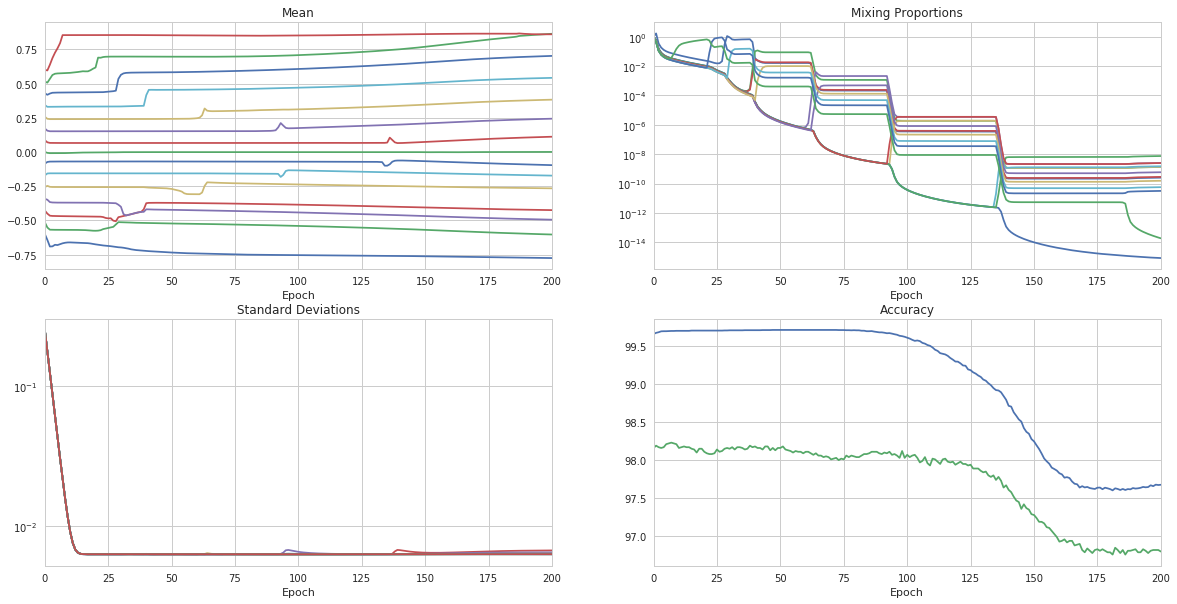

**Epoch: 1**

Layer Loss: 147291.625
Layer Loss: 165.992
Layer Loss: 21380.977
Layer Loss: 63.684
Layer Loss: 998.946
Layer Loss: 5.666
0-neglogprop Loss: -13828.171
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -1039439.125
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 2**

Layer Loss: 104514.047
Layer Loss: 94.931
Layer Loss: 18349.119
Layer Loss: 47.348
Layer Loss: 1148.595
Layer Loss: 3.420
0-neglogprop Loss: -16961.436
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -1303519.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 3**

Layer Loss: 87370.719
Layer Loss: 59.796
Layer Loss: 18769.742
Layer Loss: 43.202
Layer Loss: 1374.238
Layer Loss: 2.391
0-neglogprop Loss: -18908.949
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -1567214.125
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 4**

Layer Loss: 80834.148
Layer Loss: 47.739
Layer Loss: 19431.029
Layer Loss: 43.064
Layer Loss: 1494.178
Layer Loss: 2.072
0-neglogprop Loss: -19708.211
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -1830087.375
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 5**

Layer Loss: 76424.305
Layer Loss: 43.267
Layer Loss: 19567.027
Layer Loss: 43.003
Layer Loss: 1544.710
Layer Loss: 1.964
0-neglogprop Loss: -19999.455
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -2091170.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 6**

Layer Loss: 72487.133
Layer Loss: 40.428
Layer Loss: 19517.768
Layer Loss: 42.741
Layer Loss: 1585.590
Layer Loss: 1.898
0-neglogprop Loss: -20159.096
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -2348817.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 7**

Layer Loss: 68664.586
Layer Loss: 37.961
Layer Loss: 19402.590
Layer Loss: 42.356
Layer Loss: 1635.539
Layer Loss: 1.841
0-neglogprop Loss: -20288.545
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -2599765.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 8**

Layer Loss: 64779.492
Layer Loss: 35.443
Layer Loss: 19265.256
Layer Loss: 41.882
Layer Loss: 1670.477
Layer Loss: 1.778
0-neglogprop Loss: -20420.133
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -2837730.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 9**

Layer Loss: 60803.941
Layer Loss: 32.805
Layer Loss: 19102.105
Layer Loss: 41.312
Layer Loss: 1701.476
Layer Loss: 1.707
0-neglogprop Loss: -20559.672
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3051568.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 10**

Layer Loss: 56766.648
Layer Loss: 30.201
Layer Loss: 18918.973
Layer Loss: 40.860
Layer Loss: 1732.639
Layer Loss: 1.645
0-neglogprop Loss: -20704.771
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3224922.250
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 10. Training Accuracy: 99.70. Test Accuracy: 98.23
Means: [-0.662, -0.57, -0.47, -0.371, -0.257, -0.157, -0.07, -0.008, 0.065, 0.151, 0.24, 0.331, 0.435, 0.578, 0.85]
Mixing Proportions: [4.178, -2.903, -3.946, -3.937, -3.857, -3.766, -3.704, -3.69, -3.728, -3.82, -3.936, -3.99, -4.005, -4.009, -1.42]
Precisions: [4.199, 9.374, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391]


**Epoch: 11**

Layer Loss: 52601.367
Layer Loss: 27.408
Layer Loss: 18712.676
Layer Loss: 40.306
Layer Loss: 1760.363
Layer Loss: 1.573
0-neglogprop Loss: -20858.818
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3341511.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 12**

Layer Loss: 48328.867
Layer Loss: 24.509
Layer Loss: 18489.551
Layer Loss: 39.662
Layer Loss: 1785.452
Layer Loss: 1.495
0-neglogprop Loss: -21018.584
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3399326.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 13**

Layer Loss: 43987.184
Layer Loss: 21.517
Layer Loss: 18252.383
Layer Loss: 38.890
Layer Loss: 1811.090
Layer Loss: 1.411
0-neglogprop Loss: -21181.756
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3418085.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 14**

Layer Loss: 39594.750
Layer Loss: 18.398
Layer Loss: 18002.520
Layer Loss: 38.002
Layer Loss: 1840.864
Layer Loss: 1.321
0-neglogprop Loss: -21348.576
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3421830.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 15**

Layer Loss: 35134.039
Layer Loss: 15.184
Layer Loss: 17737.486
Layer Loss: 36.982
Layer Loss: 1874.930
Layer Loss: 1.224
0-neglogprop Loss: -21519.699
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422296.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 16**

Layer Loss: 30624.148
Layer Loss: 11.947
Layer Loss: 17468.912
Layer Loss: 35.926
Layer Loss: 1912.188
Layer Loss: 1.127
0-neglogprop Loss: -21693.908
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 17**

Layer Loss: 26033.234
Layer Loss: 8.606
Layer Loss: 17178.465
Layer Loss: 34.727
Layer Loss: 1951.993
Layer Loss: 1.018
0-neglogprop Loss: -21871.664
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 18**

Layer Loss: 21300.346
Layer Loss: 5.048
Layer Loss: 16874.010
Layer Loss: 33.444
Layer Loss: 1994.977
Layer Loss: 0.906
0-neglogprop Loss: -22056.523
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 19**

Layer Loss: 16426.221
Layer Loss: 1.371
Layer Loss: 16553.553
Layer Loss: 32.018
Layer Loss: 2032.281
Layer Loss: 0.786
0-neglogprop Loss: -22247.367
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 20**

Layer Loss: 11407.813
Layer Loss: -2.487
Layer Loss: 16205.709
Layer Loss: 30.503
Layer Loss: 2067.191
Layer Loss: 0.658
0-neglogprop Loss: -22444.592
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 20. Training Accuracy: 99.70. Test Accuracy: 98.13
Means: [-0.675, -0.572, -0.473, -0.371, -0.257, -0.157, -0.07, -0.004, 0.065, 0.151, 0.24, 0.331, 0.436, 0.612, 0.85]
Mixing Proportions: [4.902, -3.727, -4.767, -4.758, -4.679, -4.588, -4.527, -4.513, -4.551, -4.642, -4.757, -4.811, -4.825, -4.821, -0.474]
Precisions: [4.569, 10.13, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127]


**Epoch: 21**

Layer Loss: 6265.578
Layer Loss: -6.531
Layer Loss: 15832.197
Layer Loss: 28.853
Layer Loss: 2113.853
Layer Loss: 0.520
0-neglogprop Loss: -22645.955
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 22**

Layer Loss: 1043.115
Layer Loss: -10.774
Layer Loss: 15409.808
Layer Loss: 26.958
Layer Loss: 2164.743
Layer Loss: 0.365
0-neglogprop Loss: -22848.566
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 23**

Layer Loss: -4235.003
Layer Loss: -15.002
Layer Loss: 15019.996
Layer Loss: 25.228
Layer Loss: 2220.339
Layer Loss: 0.228
0-neglogprop Loss: -23054.049
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 24**

Layer Loss: -9569.120
Layer Loss: -19.171
Layer Loss: 14632.257
Layer Loss: 23.438
Layer Loss: 2277.383
Layer Loss: 0.096
0-neglogprop Loss: -23258.367
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 25**

Layer Loss: -14951.228
Layer Loss: -23.522
Layer Loss: 14245.027
Layer Loss: 21.600
Layer Loss: 2325.553
Layer Loss: -0.043
0-neglogprop Loss: -23463.973
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 26**

Layer Loss: -20383.209
Layer Loss: -27.933
Layer Loss: 13833.504
Layer Loss: 19.630
Layer Loss: 2380.168
Layer Loss: -0.185
0-neglogprop Loss: -23671.012
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 27**

Layer Loss: -25909.104
Layer Loss: -32.481
Layer Loss: 13429.723
Layer Loss: 17.617
Layer Loss: 2428.508
Layer Loss: -0.331
0-neglogprop Loss: -23882.879
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 28**

Layer Loss: -31589.871
Layer Loss: -37.094
Layer Loss: 13036.143
Layer Loss: 15.487
Layer Loss: 2491.102
Layer Loss: -0.489
0-neglogprop Loss: -24102.389
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 29**

Layer Loss: -37318.398
Layer Loss: -41.826
Layer Loss: 12618.929
Layer Loss: 13.396
Layer Loss: 2545.565
Layer Loss: -0.636
0-neglogprop Loss: -24319.768
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 30**

Layer Loss: -43044.871
Layer Loss: -46.286
Layer Loss: 12198.881
Layer Loss: 11.247
Layer Loss: 2609.249
Layer Loss: -0.784
0-neglogprop Loss: -24534.457
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 30. Training Accuracy: 99.70. Test Accuracy: 98.12
Means: [-0.698, -0.553, -0.521, -0.373, -0.257, -0.156, -0.07, -0.003, 0.065, 0.151, 0.24, 0.331, 0.442, 0.563, 0.851]
Mixing Proportions: [3.663, -1.168, -5.411, -5.536, -5.459, -5.371, -5.312, -5.299, -5.335, -5.424, -5.534, -5.586, -5.601, -1.688, -1.479]
Precisions: [5.013, 10.133, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.126, 10.127]


**Epoch: 31**

Layer Loss: -48719.492
Layer Loss: -50.589
Layer Loss: 11787.943
Layer Loss: 9.399
Layer Loss: 2670.678
Layer Loss: -0.913
0-neglogprop Loss: -24758.979
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 32**

Layer Loss: -54679.305
Layer Loss: -54.617
Layer Loss: 11294.694
Layer Loss: 8.021
Layer Loss: 2677.271
Layer Loss: -1.004
0-neglogprop Loss: -25029.938
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 33**

Layer Loss: -60604.766
Layer Loss: -58.621
Layer Loss: 10714.489
Layer Loss: 6.416
Layer Loss: 2752.415
Layer Loss: -1.106
0-neglogprop Loss: -25276.945
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 34**

Layer Loss: -66720.289
Layer Loss: -62.402
Layer Loss: 10274.650
Layer Loss: 4.976
Layer Loss: 2807.351
Layer Loss: -1.202
0-neglogprop Loss: -25553.768
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 35**

Layer Loss: -73818.633
Layer Loss: -66.056
Layer Loss: 9886.956
Layer Loss: 3.782
Layer Loss: 2778.915
Layer Loss: -1.281
0-neglogprop Loss: -25878.684
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 36**

Layer Loss: -80119.492
Layer Loss: -69.722
Layer Loss: 9358.113
Layer Loss: 2.086
Layer Loss: 2774.608
Layer Loss: -1.378
0-neglogprop Loss: -26110.547
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 37**

Layer Loss: -86269.102
Layer Loss: -73.495
Layer Loss: 8882.552
Layer Loss: 0.327
Layer Loss: 2798.753
Layer Loss: -1.472
0-neglogprop Loss: -26334.844
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 38**

Layer Loss: -92269.547
Layer Loss: -77.277
Layer Loss: 8398.384
Layer Loss: -1.351
Layer Loss: 2853.055
Layer Loss: -1.558
0-neglogprop Loss: -26553.400
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 39**

Layer Loss: -98120.766
Layer Loss: -80.391
Layer Loss: 7928.424
Layer Loss: -2.719
Layer Loss: 2912.307
Layer Loss: -1.619
0-neglogprop Loss: -26766.756
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 40**

Layer Loss: -103879.406
Layer Loss: -83.647
Layer Loss: 7496.355
Layer Loss: -4.283
Layer Loss: 2982.613
Layer Loss: -1.709
0-neglogprop Loss: -26975.213
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.500
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 40. Training Accuracy: 99.71. Test Accuracy: 98.16
Means: [-0.723, -0.505, -0.424, -0.452, -0.259, -0.157, -0.07, -0.002, 0.065, 0.151, 0.24, 0.424, 0.5, 0.604, 0.85]
Mixing Proportions: [-0.535, -2.193, -1.077, -10.521, -10.492, -10.417, -10.366, -10.354, -10.386, -10.462, -10.555, -5.84, -2.961, -3.443, -5.98]
Precisions: [5.543, 10.131, 10.128, 10.132, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.126, 10.127, 10.127, 10.127]


**Epoch: 41**

Layer Loss: -109678.703
Layer Loss: -86.265
Layer Loss: 7090.290
Layer Loss: -5.403
Layer Loss: 3072.944
Layer Loss: -1.743
0-neglogprop Loss: -27198.129
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 42**

Layer Loss: -115486.648
Layer Loss: -88.954
Layer Loss: 6552.712
Layer Loss: -6.468
Layer Loss: 3175.312
Layer Loss: -1.784
0-neglogprop Loss: -27418.463
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 43**

Layer Loss: -121116.703
Layer Loss: -91.559
Layer Loss: 6102.784
Layer Loss: -7.654
Layer Loss: 3266.638
Layer Loss: -1.824
0-neglogprop Loss: -27617.697
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 44**

Layer Loss: -126676.484
Layer Loss: -93.914
Layer Loss: 5670.445
Layer Loss: -8.680
Layer Loss: 3352.683
Layer Loss: -1.864
0-neglogprop Loss: -27817.248
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 45**

Layer Loss: -132143.344
Layer Loss: -96.249
Layer Loss: 5258.930
Layer Loss: -9.546
Layer Loss: 3436.750
Layer Loss: -1.881
0-neglogprop Loss: -28007.387
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 46**

Layer Loss: -137536.781
Layer Loss: -98.285
Layer Loss: 4867.546
Layer Loss: -10.293
Layer Loss: 3534.066
Layer Loss: -1.889
0-neglogprop Loss: -28196.400
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 47**

Layer Loss: -142856.312
Layer Loss: -99.979
Layer Loss: 4491.672
Layer Loss: -10.976
Layer Loss: 3636.202
Layer Loss: -1.889
0-neglogprop Loss: -28380.164
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 48**

Layer Loss: -148063.828
Layer Loss: -101.785
Layer Loss: 4119.079
Layer Loss: -11.581
Layer Loss: 3740.192
Layer Loss: -1.886
0-neglogprop Loss: -28556.256
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 49**

Layer Loss: -153190.594
Layer Loss: -103.171
Layer Loss: 3773.128
Layer Loss: -12.045
Layer Loss: 3850.212
Layer Loss: -1.872
0-neglogprop Loss: -28730.084
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 50**

Layer Loss: -158237.250
Layer Loss: -104.423
Layer Loss: 3414.750
Layer Loss: -12.585
Layer Loss: 3960.391
Layer Loss: -1.860
0-neglogprop Loss: -28896.697
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 50. Training Accuracy: 99.71. Test Accuracy: 98.2
Means: [-0.734, -0.51, -0.425, -0.452, -0.262, -0.157, -0.07, -0.002, 0.065, 0.151, 0.241, 0.406, 0.501, 0.607, 0.848]
Mixing Proportions: [-1.197, -2.879, -1.777, -12.526, -12.483, -12.418, -12.373, -12.363, -12.391, -12.457, -12.54, -3.268, -3.698, -4.153, -6.718]
Precisions: [5.97, 10.131, 10.128, 10.132, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.128, 10.127, 10.127, 10.127]


**Epoch: 51**

Layer Loss: -163187.625
Layer Loss: -105.682
Layer Loss: 3077.068
Layer Loss: -12.716
Layer Loss: 4075.708
Layer Loss: -1.821
0-neglogprop Loss: -29060.582
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 52**

Layer Loss: -168097.719
Layer Loss: -106.673
Layer Loss: 2768.836
Layer Loss: -13.018
Layer Loss: 4198.139
Layer Loss: -1.789
0-neglogprop Loss: -29224.344
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 53**

Layer Loss: -172861.047
Layer Loss: -107.578
Layer Loss: 2457.435
Layer Loss: -13.104
Layer Loss: 4319.355
Layer Loss: -1.748
0-neglogprop Loss: -29379.256
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 54**

Layer Loss: -177589.219
Layer Loss: -108.379
Layer Loss: 2150.883
Layer Loss: -13.227
Layer Loss: 4443.854
Layer Loss: -1.714
0-neglogprop Loss: -29530.600
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 55**

Layer Loss: -182203.344
Layer Loss: -109.076
Layer Loss: 1842.392
Layer Loss: -13.166
Layer Loss: 4568.729
Layer Loss: -1.663
0-neglogprop Loss: -29675.963
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 56**

Layer Loss: -186720.266
Layer Loss: -109.744
Layer Loss: 1543.280
Layer Loss: -12.990
Layer Loss: 4696.687
Layer Loss: -1.606
0-neglogprop Loss: -29817.791
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 57**

Layer Loss: -191180.828
Layer Loss: -110.164
Layer Loss: 1258.908
Layer Loss: -12.807
Layer Loss: 4829.263
Layer Loss: -1.535
0-neglogprop Loss: -29958.996
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 58**

Layer Loss: -195616.094
Layer Loss: -110.138
Layer Loss: 1033.627
Layer Loss: -12.441
Layer Loss: 4897.104
Layer Loss: -1.464
0-neglogprop Loss: -30107.721
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 59**

Layer Loss: -200613.969
Layer Loss: -107.967
Layer Loss: 954.297
Layer Loss: -10.757
Layer Loss: 5065.357
Layer Loss: -1.263
0-neglogprop Loss: -30317.877
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 60**

Layer Loss: -209093.594
Layer Loss: -97.273
Layer Loss: 1274.908
Layer Loss: -4.946
Layer Loss: 5438.566
Layer Loss: -0.639
0-neglogprop Loss: -30734.506
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422321.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 60. Training Accuracy: 99.71. Test Accuracy: 98.15
Means: [-0.741, -0.512, -0.427, -0.452, -0.26, -0.157, -0.07, -0.002, 0.065, 0.151, 0.295, 0.407, 0.503, 0.609, 0.846]
Mixing Proportions: [-6.022, -7.661, -6.554, -15.604, -5.732, -15.541, -15.515, -15.509, -15.526, -15.564, -9.161, -7.941, -8.41, -8.91, -11.395]
Precisions: [6.438, 10.126, 10.128, 10.132, 10.127, 10.113, 10.127, 10.127, 10.127, 10.127, 10.127, 10.113, 10.128, 10.127, 10.127, 10.127]


**Epoch: 61**

Layer Loss: -214714.250
Layer Loss: -94.248
Layer Loss: 753.364
Layer Loss: -3.066
Layer Loss: 5524.067
Layer Loss: -0.391
0-neglogprop Loss: -30933.752
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422329.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 62**

Layer Loss: -219892.109
Layer Loss: -92.027
Layer Loss: 65.132
Layer Loss: -1.497
Layer Loss: 5585.772
Layer Loss: -0.193
0-neglogprop Loss: -31094.828
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422331.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 63**

Layer Loss: -224720.016
Layer Loss: -90.321
Layer Loss: -367.102
Layer Loss: -0.217
Layer Loss: 5671.761
Layer Loss: 0.014
0-neglogprop Loss: -31239.027
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 64**

Layer Loss: -229346.359
Layer Loss: -89.164
Layer Loss: -740.676
Layer Loss: 1.033
Layer Loss: 5753.308
Layer Loss: 0.197
0-neglogprop Loss: -31369.184
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 65**

Layer Loss: -233850.531
Layer Loss: -87.488
Layer Loss: -1049.258
Layer Loss: 2.203
Layer Loss: 5843.565
Layer Loss: 0.351
0-neglogprop Loss: -31498.084
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 66**

Layer Loss: -238241.859
Layer Loss: -86.097
Layer Loss: -1357.190
Layer Loss: 3.380
Layer Loss: 5921.351
Layer Loss: 0.515
0-neglogprop Loss: -31618.393
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 67**

Layer Loss: -242485.438
Layer Loss: -84.826
Layer Loss: -1661.666
Layer Loss: 4.501
Layer Loss: 6003.119
Layer Loss: 0.674
0-neglogprop Loss: -31731.996
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 68**

Layer Loss: -246623.469
Layer Loss: -83.620
Layer Loss: -1958.031
Layer Loss: 5.656
Layer Loss: 6085.188
Layer Loss: 0.826
0-neglogprop Loss: -31841.469
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 69**

Layer Loss: -250641.219
Layer Loss: -82.299
Layer Loss: -2255.912
Layer Loss: 7.015
Layer Loss: 6181.175
Layer Loss: 1.026
0-neglogprop Loss: -31945.086
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 70**

Layer Loss: -254586.047
Layer Loss: -81.003
Layer Loss: -2548.065
Layer Loss: 8.252
Layer Loss: 6282.375
Layer Loss: 1.197
0-neglogprop Loss: -32046.010
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 70. Training Accuracy: 99.71. Test Accuracy: 98.07
Means: [-0.746, -0.515, -0.429, -0.452, -0.266, -0.157, -0.07, -0.002, 0.065, 0.151, 0.289, 0.407, 0.506, 0.611, 0.845]
Mixing Proportions: [-6.715, -8.405, -7.303, -18.378, -6.448, -18.323, -18.304, -18.299, -18.311, -18.34, -7.502, -8.778, -9.224, -9.679, -12.244]
Precisions: [6.784, 10.129, 10.128, 10.132, 10.127, 10.132, 10.127, 10.127, 10.127, 10.127, 10.127, 10.128, 10.127, 10.127, 10.127, 10.127]


**Epoch: 71**

Layer Loss: -258474.734
Layer Loss: -79.320
Layer Loss: -2806.925
Layer Loss: 9.678
Layer Loss: 6368.207
Layer Loss: 1.386
0-neglogprop Loss: -32147.252
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 72**

Layer Loss: -262343.281
Layer Loss: -77.347
Layer Loss: -3020.109
Layer Loss: 11.381
Layer Loss: 6464.189
Layer Loss: 1.582
0-neglogprop Loss: -32251.006
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 73**

Layer Loss: -266162.750
Layer Loss: -75.761
Layer Loss: -3285.947
Layer Loss: 12.871
Layer Loss: 6547.812
Layer Loss: 1.764
0-neglogprop Loss: -32344.727
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 74**

Layer Loss: -269881.250
Layer Loss: -74.065
Layer Loss: -3565.224
Layer Loss: 14.224
Layer Loss: 6625.335
Layer Loss: 1.954
0-neglogprop Loss: -32433.539
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 75**

Layer Loss: -273535.188
Layer Loss: -72.427
Layer Loss: -3821.584
Layer Loss: 16.203
Layer Loss: 6703.127
Layer Loss: 2.188
0-neglogprop Loss: -32521.150
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 76**

Layer Loss: -277102.844
Layer Loss: -70.854
Layer Loss: -4106.930
Layer Loss: 17.728
Layer Loss: 6778.347
Layer Loss: 2.384
0-neglogprop Loss: -32602.564
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 77**

Layer Loss: -280645.375
Layer Loss: -68.970
Layer Loss: -4358.436
Layer Loss: 19.382
Layer Loss: 6860.723
Layer Loss: 2.581
0-neglogprop Loss: -32685.375
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 78**

Layer Loss: -284108.406
Layer Loss: -67.297
Layer Loss: -4618.355
Layer Loss: 21.066
Layer Loss: 6927.200
Layer Loss: 2.773
0-neglogprop Loss: -32763.906
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 79**

Layer Loss: -287507.219
Layer Loss: -65.255
Layer Loss: -4897.940
Layer Loss: 22.687
Layer Loss: 6997.558
Layer Loss: 2.988
0-neglogprop Loss: -32837.848
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 80**

Layer Loss: -290834.188
Layer Loss: -63.843
Layer Loss: -5190.396
Layer Loss: 24.171
Layer Loss: 7077.375
Layer Loss: 3.165
0-neglogprop Loss: -32907.703
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.500
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 80. Training Accuracy: 99.70. Test Accuracy: 98.05
Means: [-0.75, -0.518, -0.431, -0.452, -0.273, -0.157, -0.07, -0.002, 0.065, 0.15, 0.292, 0.409, 0.509, 0.615, 0.844]
Mixing Proportions: [-6.721, -8.413, -7.311, -19.373, -6.439, -19.334, -19.32, -19.316, -19.325, -19.347, -7.495, -8.787, -9.232, -9.688, -12.253]
Precisions: [7.064, 10.128, 10.128, 10.132, 10.127, 10.131, 10.127, 10.127, 10.127, 10.127, 10.127, 10.129, 10.128, 10.127, 10.127, 10.127]


**Epoch: 81**

Layer Loss: -294108.281
Layer Loss: -62.170
Layer Loss: -5468.032
Layer Loss: 25.937
Layer Loss: 7172.131
Layer Loss: 3.378
0-neglogprop Loss: -32975.883
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 82**

Layer Loss: -297320.375
Layer Loss: -60.512
Layer Loss: -5768.897
Layer Loss: 27.062
Layer Loss: 7270.992
Layer Loss: 3.521
0-neglogprop Loss: -33040.090
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 83**

Layer Loss: -300524.688
Layer Loss: -58.465
Layer Loss: -6028.744
Layer Loss: 29.292
Layer Loss: 7384.213
Layer Loss: 3.759
0-neglogprop Loss: -33105.520
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 84**

Layer Loss: -303679.969
Layer Loss: -57.014
Layer Loss: -6323.448
Layer Loss: 30.857
Layer Loss: 7496.278
Layer Loss: 3.958
0-neglogprop Loss: -33166.406
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 85**

Layer Loss: -306796.344
Layer Loss: -54.893
Layer Loss: -6609.356
Layer Loss: 32.246
Layer Loss: 7614.864
Layer Loss: 4.131
0-neglogprop Loss: -33225.965
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 86**

Layer Loss: -309867.062
Layer Loss: -53.391
Layer Loss: -6893.832
Layer Loss: 34.101
Layer Loss: 7738.548
Layer Loss: 4.331
0-neglogprop Loss: -33282.961
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 87**

Layer Loss: -312877.094
Layer Loss: -52.111
Layer Loss: -7191.338
Layer Loss: 35.803
Layer Loss: 7858.802
Layer Loss: 4.522
0-neglogprop Loss: -33336.508
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 88**

Layer Loss: -315891.344
Layer Loss: -49.931
Layer Loss: -7471.155
Layer Loss: 37.388
Layer Loss: 7986.913
Layer Loss: 4.708
0-neglogprop Loss: -33390.312
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 89**

Layer Loss: -318825.219
Layer Loss: -48.470
Layer Loss: -7771.716
Layer Loss: 39.311
Layer Loss: 8111.547
Layer Loss: 4.921
0-neglogprop Loss: -33439.672
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 90**

Layer Loss: -321743.594
Layer Loss: -46.502
Layer Loss: -8063.139
Layer Loss: 40.943
Layer Loss: 8242.380
Layer Loss: 5.086
0-neglogprop Loss: -33488.078
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 90. Training Accuracy: 99.68. Test Accuracy: 98.02
Means: [-0.752, -0.522, -0.434, -0.452, -0.277, -0.159, -0.07, -0.002, 0.065, 0.151, 0.294, 0.413, 0.514, 0.62, 0.842]
Mixing Proportions: [-6.722, -8.414, -7.312, -19.981, -6.439, -19.979, -19.969, -19.967, -19.973, -19.981, -7.483, -8.788, -9.233, -9.688, -12.253]
Precisions: [7.301, 10.133, 10.128, 10.131, 10.127, 10.136, 10.127, 10.127, 10.127, 10.127, 10.127, 10.128, 10.128, 10.127, 10.127, 10.127]


**Epoch: 91**

Layer Loss: -324630.438
Layer Loss: -44.348
Layer Loss: -8358.771
Layer Loss: 42.867
Layer Loss: 8376.293
Layer Loss: 5.308
0-neglogprop Loss: -33534.473
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 92**

Layer Loss: -327498.375
Layer Loss: -42.671
Layer Loss: -8661.827
Layer Loss: 44.446
Layer Loss: 8511.514
Layer Loss: 5.475
0-neglogprop Loss: -33578.809
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 93**

Layer Loss: -330339.000
Layer Loss: -40.814
Layer Loss: -8953.329
Layer Loss: 46.106
Layer Loss: 8654.341
Layer Loss: 5.676
0-neglogprop Loss: -33622.031
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 94**

Layer Loss: -333121.531
Layer Loss: -39.187
Layer Loss: -9266.540
Layer Loss: 47.887
Layer Loss: 8791.591
Layer Loss: 5.870
0-neglogprop Loss: -33661.777
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 95**

Layer Loss: -335891.312
Layer Loss: -36.940
Layer Loss: -9560.150
Layer Loss: 49.905
Layer Loss: 8937.332
Layer Loss: 6.093
0-neglogprop Loss: -33700.898
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 96**

Layer Loss: -339155.750
Layer Loss: -28.584
Layer Loss: -9458.847
Layer Loss: 54.959
Layer Loss: 8927.965
Layer Loss: 6.613
0-neglogprop Loss: -33766.293
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 97**

Layer Loss: -343540.656
Layer Loss: -15.194
Layer Loss: -9067.564
Layer Loss: 65.202
Layer Loss: 8618.631
Layer Loss: 7.708
0-neglogprop Loss: -33861.305
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422327.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 98**

Layer Loss: -352868.781
Layer Loss: -36.545
Layer Loss: -8544.887
Layer Loss: 95.012
Layer Loss: 9143.661
Layer Loss: 10.886
0-neglogprop Loss: -34030.359
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422223.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 99**

Layer Loss: -358483.469
Layer Loss: -42.875
Layer Loss: -9176.705
Layer Loss: 102.460
Layer Loss: 9145.531
Layer Loss: 12.287
0-neglogprop Loss: -34078.484
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422109.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 100**

Layer Loss: -362803.000
Layer Loss: -40.794
Layer Loss: -9720.170
Layer Loss: 100.655
Layer Loss: 9091.029
Layer Loss: 13.043
0-neglogprop Loss: -34097.012
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422127.250
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 100. Training Accuracy: 99.63. Test Accuracy: 98.01
Means: [-0.753, -0.526, -0.437, -0.451, -0.281, -0.142, -0.07, -0.002, 0.066, 0.161, 0.295, 0.417, 0.519, 0.625, 0.842]
Mixing Proportions: [-13.476, -15.168, -14.065, -23.793, -13.191, -13.413, -23.792, -23.791, -23.793, -12.936, -14.196, -15.541, -15.986, -16.442, -18.994]
Precisions: [7.778, 10.135, 10.128, 10.131, 10.127, 10.136, 10.105, 10.127, 10.127, 10.127, 10.013, 10.117, 10.127, 10.127, 10.127, 10.127]


**Epoch: 101**

Layer Loss: -366920.719
Layer Loss: -39.712
Layer Loss: -10315.850
Layer Loss: 100.991
Layer Loss: 8989.269
Layer Loss: 13.546
0-neglogprop Loss: -34107.281
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422171.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 102**

Layer Loss: -370960.938
Layer Loss: -39.495
Layer Loss: -10913.984
Layer Loss: 101.712
Layer Loss: 8880.440
Layer Loss: 14.030
0-neglogprop Loss: -34111.957
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422211.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 103**

Layer Loss: -374901.844
Layer Loss: -38.350
Layer Loss: -11480.047
Layer Loss: 103.501
Layer Loss: 8767.954
Layer Loss: 14.494
0-neglogprop Loss: -34111.594
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422242.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 104**

Layer Loss: -378807.906
Layer Loss: -36.324
Layer Loss: -12031.900
Layer Loss: 105.305
Layer Loss: 8663.677
Layer Loss: 14.976
0-neglogprop Loss: -34106.281
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422266.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 105**

Layer Loss: -382658.969
Layer Loss: -35.471
Layer Loss: -12582.672
Layer Loss: 107.548
Layer Loss: 8574.905
Layer Loss: 15.466
0-neglogprop Loss: -34096.262
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422283.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 106**

Layer Loss: -386468.156
Layer Loss: -33.834
Layer Loss: -13108.844
Layer Loss: 109.948
Layer Loss: 8498.153
Layer Loss: 15.984
0-neglogprop Loss: -34081.223
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422296.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 107**

Layer Loss: -390299.312
Layer Loss: -32.422
Layer Loss: -13627.994
Layer Loss: 111.944
Layer Loss: 8432.835
Layer Loss: 16.365
0-neglogprop Loss: -34060.602
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422305.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 108**

Layer Loss: -394076.750
Layer Loss: -30.955
Layer Loss: -14160.579
Layer Loss: 114.532
Layer Loss: 8380.004
Layer Loss: 16.849
0-neglogprop Loss: -34035.562
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422312.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 109**

Layer Loss: -397840.250
Layer Loss: -29.163
Layer Loss: -14674.516
Layer Loss: 117.109
Layer Loss: 8341.360
Layer Loss: 17.213
0-neglogprop Loss: -34004.750
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422317.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 110**

Layer Loss: -401605.344
Layer Loss: -26.573
Layer Loss: -15195.359
Layer Loss: 120.212
Layer Loss: 8313.262
Layer Loss: 17.700
0-neglogprop Loss: -33968.484
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422321.500
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 110. Training Accuracy: 99.50. Test Accuracy: 97.97
Means: [-0.755, -0.531, -0.44, -0.451, -0.284, -0.147, -0.071, -0.002, 0.066, 0.167, 0.298, 0.422, 0.526, 0.633, 0.841]
Mixing Proportions: [-13.482, -15.174, -14.072, -25.486, -13.198, -13.393, -25.484, -25.483, -25.485, -12.933, -14.201, -15.548, -15.993, -16.448, -19.013]
Precisions: [8.084, 10.134, 10.127, 10.13, 10.127, 10.136, 10.125, 10.127, 10.127, 10.127, 10.1, 10.123, 10.127, 10.127, 10.127, 10.127]


**Epoch: 111**

Layer Loss: -405343.469
Layer Loss: -25.172
Layer Loss: -15723.281
Layer Loss: 122.991
Layer Loss: 8294.249
Layer Loss: 18.122
0-neglogprop Loss: -33927.289
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422324.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 112**

Layer Loss: -409127.344
Layer Loss: -22.452
Layer Loss: -16234.786
Layer Loss: 126.482
Layer Loss: 8288.751
Layer Loss: 18.662
0-neglogprop Loss: -33878.199
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422326.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 113**

Layer Loss: -412875.812
Layer Loss: -19.732
Layer Loss: -16751.580
Layer Loss: 130.272
Layer Loss: 8286.356
Layer Loss: 19.137
0-neglogprop Loss: -33824.059
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422327.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 114**

Layer Loss: -416636.656
Layer Loss: -17.725
Layer Loss: -17281.604
Layer Loss: 133.568
Layer Loss: 8292.083
Layer Loss: 19.567
0-neglogprop Loss: -33763.711
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422328.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 115**

Layer Loss: -420427.625
Layer Loss: -15.426
Layer Loss: -17806.795
Layer Loss: 136.993
Layer Loss: 8306.149
Layer Loss: 19.978
0-neglogprop Loss: -33695.648
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422330.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 116**

Layer Loss: -424208.625
Layer Loss: -12.392
Layer Loss: -18349.535
Layer Loss: 140.962
Layer Loss: 8325.420
Layer Loss: 20.471
0-neglogprop Loss: -33621.758
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422330.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 117**

Layer Loss: -428010.875
Layer Loss: -9.605
Layer Loss: -18887.326
Layer Loss: 144.921
Layer Loss: 8350.600
Layer Loss: 20.911
0-neglogprop Loss: -33539.809
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422331.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 118**

Layer Loss: -431882.438
Layer Loss: -7.573
Layer Loss: -19439.531
Layer Loss: 148.275
Layer Loss: 8381.680
Layer Loss: 21.290
0-neglogprop Loss: -33449.332
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422331.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 119**

Layer Loss: -435748.375
Layer Loss: -4.335
Layer Loss: -19982.727
Layer Loss: 152.360
Layer Loss: 8413.197
Layer Loss: 21.688
0-neglogprop Loss: -33349.938
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 120**

Layer Loss: -439583.094
Layer Loss: -0.849
Layer Loss: -20540.695
Layer Loss: 157.146
Layer Loss: 8444.858
Layer Loss: 22.185
0-neglogprop Loss: -33244.891
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.000
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 120. Training Accuracy: 99.28. Test Accuracy: 97.91
Means: [-0.756, -0.535, -0.444, -0.451, -0.288, -0.151, -0.071, -0.002, 0.066, 0.173, 0.303, 0.428, 0.533, 0.641, 0.841]
Mixing Proportions: [-13.483, -15.175, -14.072, -26.345, -13.198, -13.394, -26.345, -26.345, -26.347, -12.931, -14.202, -15.548, -15.994, -16.449, -19.014]
Precisions: [8.392, 10.133, 10.126, 10.129, 10.127, 10.135, 10.13, 10.127, 10.127, 10.127, 10.118, 10.125, 10.127, 10.127, 10.127, 10.127]


**Epoch: 121**

Layer Loss: -443477.188
Layer Loss: 1.949
Layer Loss: -21105.953
Layer Loss: 161.042
Layer Loss: 8484.502
Layer Loss: 22.633
0-neglogprop Loss: -33130.246
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 122**

Layer Loss: -447381.438
Layer Loss: 5.923
Layer Loss: -21667.252
Layer Loss: 165.723
Layer Loss: 8527.395
Layer Loss: 23.124
0-neglogprop Loss: -33005.020
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 123**

Layer Loss: -451299.875
Layer Loss: 8.965
Layer Loss: -22253.893
Layer Loss: 169.982
Layer Loss: 8569.416
Layer Loss: 23.475
0-neglogprop Loss: -32873.164
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 124**

Layer Loss: -455241.750
Layer Loss: 12.389
Layer Loss: -22823.352
Layer Loss: 174.497
Layer Loss: 8620.139
Layer Loss: 23.874
0-neglogprop Loss: -32728.471
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 125**

Layer Loss: -459251.219
Layer Loss: 15.120
Layer Loss: -23405.758
Layer Loss: 178.999
Layer Loss: 8670.477
Layer Loss: 24.287
0-neglogprop Loss: -32572.100
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 126**

Layer Loss: -463258.562
Layer Loss: 18.941
Layer Loss: -24006.086
Layer Loss: 183.634
Layer Loss: 8719.996
Layer Loss: 24.731
0-neglogprop Loss: -32407.545
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 127**

Layer Loss: -467263.469
Layer Loss: 22.738
Layer Loss: -24608.064
Layer Loss: 188.424
Layer Loss: 8773.142
Layer Loss: 25.158
0-neglogprop Loss: -32231.760
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 128**

Layer Loss: -471327.344
Layer Loss: 26.857
Layer Loss: -25228.285
Layer Loss: 193.414
Layer Loss: 8826.223
Layer Loss: 25.597
0-neglogprop Loss: -32042.543
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 129**

Layer Loss: -475390.062
Layer Loss: 31.064
Layer Loss: -25820.809
Layer Loss: 198.446
Layer Loss: 8882.550
Layer Loss: 25.955
0-neglogprop Loss: -31839.488
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 130**

Layer Loss: -479470.438
Layer Loss: 34.950
Layer Loss: -26452.078
Layer Loss: 203.773
Layer Loss: 8936.012
Layer Loss: 26.412
0-neglogprop Loss: -31628.193
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 130. Training Accuracy: 99.07. Test Accuracy: 97.73
Means: [-0.758, -0.541, -0.448, -0.451, -0.293, -0.155, -0.071, -0.002, 0.067, 0.178, 0.309, 0.434, 0.541, 0.65, 0.842]
Mixing Proportions: [-13.481, -15.173, -14.071, -26.906, -13.197, -13.39, -26.906, -26.906, -26.906, -12.929, -14.2, -15.547, -15.992, -16.448, -19.013]
Precisions: [8.712, 10.132, 10.126, 10.129, 10.127, 10.133, 10.13, 10.127, 10.127, 10.127, 10.123, 10.125, 10.126, 10.127, 10.127, 10.126]


**Epoch: 131**

Layer Loss: -483611.406
Layer Loss: 38.634
Layer Loss: -27072.207
Layer Loss: 208.764
Layer Loss: 8994.355
Layer Loss: 26.751
0-neglogprop Loss: -31399.383
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 132**

Layer Loss: -487805.406
Layer Loss: 42.105
Layer Loss: -27704.188
Layer Loss: 213.659
Layer Loss: 9054.848
Layer Loss: 27.092
0-neglogprop Loss: -31154.078
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 133**

Layer Loss: -491905.438
Layer Loss: 46.330
Layer Loss: -28340.926
Layer Loss: 219.282
Layer Loss: 9107.692
Layer Loss: 27.388
0-neglogprop Loss: -30904.482
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 134**

Layer Loss: -496147.125
Layer Loss: 49.917
Layer Loss: -28996.973
Layer Loss: 223.727
Layer Loss: 9168.185
Layer Loss: 27.692
0-neglogprop Loss: -30631.078
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 135**

Layer Loss: -500307.594
Layer Loss: 54.426
Layer Loss: -29641.350
Layer Loss: 229.303
Layer Loss: 9224.590
Layer Loss: 27.979
0-neglogprop Loss: -30346.141
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 136**

Layer Loss: -504936.000
Layer Loss: 64.161
Layer Loss: -30104.492
Layer Loss: 238.847
Layer Loss: 9167.813
Layer Loss: 28.734
0-neglogprop Loss: -29944.836
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 137**

Layer Loss: -511446.344
Layer Loss: 65.403
Layer Loss: -30217.719
Layer Loss: 239.138
Layer Loss: 8758.070
Layer Loss: 31.376
0-neglogprop Loss: -29114.324
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422333.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 138**

Layer Loss: -528144.375
Layer Loss: 79.762
Layer Loss: -29444.107
Layer Loss: 252.072
Layer Loss: 8677.762
Layer Loss: 23.652
0-neglogprop Loss: -25867.629
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422287.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 139**

Layer Loss: -542147.750
Layer Loss: 71.139
Layer Loss: -30017.125
Layer Loss: 257.639
Layer Loss: 9005.137
Layer Loss: 22.205
0-neglogprop Loss: -23099.494
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422187.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 140**

Layer Loss: -551973.062
Layer Loss: 64.818
Layer Loss: -31344.113
Layer Loss: 264.826
Layer Loss: 9008.064
Layer Loss: 21.929
0-neglogprop Loss: -21398.508
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422196.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 140. Training Accuracy: 98.73. Test Accuracy: 97.47
Means: [-0.759, -0.547, -0.452, -0.451, -0.297, -0.159, -0.062, -0.001, 0.063, 0.184, 0.316, 0.44, 0.551, 0.661, 0.843]
Mixing Proportions: [-20.409, -22.101, -20.998, -30.679, -20.124, -20.318, -20.171, -30.678, -18.854, -19.856, -21.127, -22.474, -22.919, -23.374, -25.922]
Precisions: [9.548, 10.131, 10.125, 10.127, 10.127, 10.131, 10.129, 10.111, 10.127, 10.031, 10.122, 10.123, 10.126, 10.127, 10.127, 10.127]


**Epoch: 141**

Layer Loss: -561744.875
Layer Loss: 54.507
Layer Loss: -32968.633
Layer Loss: 268.942
Layer Loss: 8953.796
Layer Loss: 21.696
0-neglogprop Loss: -19700.758
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422220.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 142**

Layer Loss: -571587.062
Layer Loss: 41.334
Layer Loss: -34735.004
Layer Loss: 270.702
Layer Loss: 8884.551
Layer Loss: 21.468
0-neglogprop Loss: -17909.217
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422244.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 143**

Layer Loss: -581437.438
Layer Loss: 30.504
Layer Loss: -36559.430
Layer Loss: 270.927
Layer Loss: 8811.543
Layer Loss: 21.191
0-neglogprop Loss: -15998.604
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422265.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 144**

Layer Loss: -591558.688
Layer Loss: 17.497
Layer Loss: -38460.535
Layer Loss: 270.156
Layer Loss: 8738.111
Layer Loss: 20.967
0-neglogprop Loss: -13892.703
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422281.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 145**

Layer Loss: -601691.938
Layer Loss: 4.408
Layer Loss: -40378.801
Layer Loss: 269.998
Layer Loss: 8666.106
Layer Loss: 20.622
0-neglogprop Loss: -11631.945
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422293.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 146**

Layer Loss: -611871.125
Layer Loss: -8.762
Layer Loss: -42349.086
Layer Loss: 269.481
Layer Loss: 8600.232
Layer Loss: 20.368
0-neglogprop Loss: -9188.391
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422301.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 147**

Layer Loss: -622126.750
Layer Loss: -21.658
Layer Loss: -44348.211
Layer Loss: 269.353
Layer Loss: 8535.188
Layer Loss: 20.005
0-neglogprop Loss: -6561.875
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422307.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 148**

Layer Loss: -632451.375
Layer Loss: -39.004
Layer Loss: -46359.000
Layer Loss: 268.278
Layer Loss: 8476.919
Layer Loss: 19.568
0-neglogprop Loss: -3741.855
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422312.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 149**

Layer Loss: -642469.125
Layer Loss: -57.634
Layer Loss: -48374.766
Layer Loss: 267.104
Layer Loss: 8418.815
Layer Loss: 19.308
0-neglogprop Loss: -823.348
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422314.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 150**

Layer Loss: -652639.250
Layer Loss: -76.930
Layer Loss: -50371.602
Layer Loss: 265.260
Layer Loss: 8367.911
Layer Loss: 18.855
0-neglogprop Loss: 2329.500
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422316.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 150. Training Accuracy: 98.16. Test Accuracy: 97.2
Means: [-0.762, -0.553, -0.456, -0.451, -0.301, -0.164, -0.068, -0.002, 0.071, 0.192, 0.324, 0.448, 0.563, 0.675, 0.843]
Mixing Proportions: [-20.418, -22.11, -21.008, -32.378, -20.134, -20.327, -20.161, -32.376, -18.844, -19.866, -21.137, -22.484, -22.929, -23.384, -25.949]
Precisions: [10.254, 10.128, 10.123, 10.125, 10.127, 10.126, 10.124, 10.122, 10.127, 10.094, 10.111, 10.119, 10.124, 10.127, 10.127, 10.127]


**Epoch: 151**

Layer Loss: -662392.000
Layer Loss: -93.294
Layer Loss: -52315.488
Layer Loss: 262.727
Layer Loss: 8320.970
Layer Loss: 18.321
0-neglogprop Loss: 5519.488
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422317.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 152**

Layer Loss: -671956.750
Layer Loss: -109.593
Layer Loss: -54245.180
Layer Loss: 259.120
Layer Loss: 8276.606
Layer Loss: 17.922
0-neglogprop Loss: 8821.988
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422317.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 153**

Layer Loss: -681033.000
Layer Loss: -122.596
Layer Loss: -56064.863
Layer Loss: 255.237
Layer Loss: 8237.345
Layer Loss: 17.295
0-neglogprop Loss: 12110.297
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422316.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 154**

Layer Loss: -689741.250
Layer Loss: -136.029
Layer Loss: -57824.512
Layer Loss: 250.110
Layer Loss: 8201.026
Layer Loss: 16.814
0-neglogprop Loss: 15411.219
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422315.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 155**

Layer Loss: -697989.875
Layer Loss: -147.462
Layer Loss: -59460.824
Layer Loss: 244.364
Layer Loss: 8169.827
Layer Loss: 16.218
0-neglogprop Loss: 18673.742
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422313.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 156**

Layer Loss: -705744.250
Layer Loss: -157.873
Layer Loss: -61015.379
Layer Loss: 237.214
Layer Loss: 8139.509
Layer Loss: 15.592
0-neglogprop Loss: 21841.918
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422311.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 157**

Layer Loss: -712754.375
Layer Loss: -165.890
Layer Loss: -62399.008
Layer Loss: 230.249
Layer Loss: 8114.776
Layer Loss: 15.036
0-neglogprop Loss: 24828.516
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422308.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 158**

Layer Loss: -719288.500
Layer Loss: -173.856
Layer Loss: -63684.832
Layer Loss: 222.600
Layer Loss: 8093.431
Layer Loss: 14.410
0-neglogprop Loss: 27677.297
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422304.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 159**

Layer Loss: -725264.500
Layer Loss: -182.118
Layer Loss: -64853.633
Layer Loss: 213.990
Layer Loss: 8075.087
Layer Loss: 13.696
0-neglogprop Loss: 30344.449
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422301.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 160**

Layer Loss: -730775.438
Layer Loss: -190.158
Layer Loss: -65931.578
Layer Loss: 205.419
Layer Loss: 8058.204
Layer Loss: 13.087
0-neglogprop Loss: 32844.508
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422297.000
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 160. Training Accuracy: 97.77. Test Accuracy: 96.96
Means: [-0.764, -0.56, -0.46, -0.451, -0.305, -0.168, -0.074, -0.002, 0.08, 0.2, 0.333, 0.456, 0.575, 0.689, 0.842]
Mixing Proportions: [-20.418, -22.11, -21.008, -33.252, -20.134, -20.327, -20.161, -33.248, -18.844, -19.866, -21.137, -22.484, -22.929, -23.384, -25.949]
Precisions: [10.699, 10.126, 10.121, 10.123, 10.127, 10.12, 10.117, 10.118, 10.127, 10.082, 10.095, 10.113, 10.123, 10.126, 10.127, 10.127]


**Epoch: 161**

Layer Loss: -735681.562
Layer Loss: -196.613
Layer Loss: -66868.547
Layer Loss: 197.658
Layer Loss: 8044.476
Layer Loss: 12.548
0-neglogprop Loss: 35156.953
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422292.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 162**

Layer Loss: -740112.938
Layer Loss: -202.858
Layer Loss: -67725.094
Layer Loss: 189.367
Layer Loss: 8032.950
Layer Loss: 11.980
0-neglogprop Loss: 37288.883
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422288.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 163**

Layer Loss: -744114.875
Layer Loss: -209.712
Layer Loss: -68500.789
Layer Loss: 180.974
Layer Loss: 8023.093
Layer Loss: 11.410
0-neglogprop Loss: 39215.570
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422283.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 164**

Layer Loss: -747593.562
Layer Loss: -215.274
Layer Loss: -69185.492
Layer Loss: 173.317
Layer Loss: 8014.279
Layer Loss: 11.008
0-neglogprop Loss: 40971.680
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422277.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 165**

Layer Loss: -750686.562
Layer Loss: -220.639
Layer Loss: -69783.172
Layer Loss: 166.177
Layer Loss: 8006.364
Layer Loss: 10.636
0-neglogprop Loss: 42516.848
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422272.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 166**

Layer Loss: -753637.562
Layer Loss: -226.071
Layer Loss: -70372.922
Layer Loss: 158.629
Layer Loss: 7999.578
Layer Loss: 10.103
0-neglogprop Loss: 44013.566
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422266.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 167**

Layer Loss: -756112.625
Layer Loss: -231.001
Layer Loss: -70846.328
Layer Loss: 152.258
Layer Loss: 7995.366
Layer Loss: 9.862
0-neglogprop Loss: 45315.875
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422260.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 168**

Layer Loss: -758335.062
Layer Loss: -236.173
Layer Loss: -71301.281
Layer Loss: 145.589
Layer Loss: 7988.179
Layer Loss: 9.489
0-neglogprop Loss: 46463.391
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422255.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 169**

Layer Loss: -760448.312
Layer Loss: -240.482
Layer Loss: -71720.984
Layer Loss: 139.706
Layer Loss: 7984.543
Layer Loss: 9.163
0-neglogprop Loss: 47587.734
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422248.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 170**

Layer Loss: -762486.188
Layer Loss: -246.169
Layer Loss: -72108.383
Layer Loss: 133.862
Layer Loss: 7978.702
Layer Loss: 8.949
0-neglogprop Loss: 48673.785
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422243.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 170. Training Accuracy: 97.67. Test Accuracy: 96.89
Means: [-0.767, -0.566, -0.464, -0.451, -0.309, -0.172, -0.08, -0.002, 0.088, 0.207, 0.34, 0.463, 0.586, 0.702, 0.841]
Mixing Proportions: [-20.418, -22.11, -21.008, -33.818, -20.134, -20.327, -20.161, -33.82, -18.844, -19.866, -21.137, -22.484, -22.929, -23.384, -25.949]
Precisions: [10.857, 10.125, 10.12, 10.122, 10.127, 10.116, 10.112, 10.113, 10.127, 10.056, 10.081, 10.108, 10.122, 10.126, 10.126, 10.127]


**Epoch: 171**

Layer Loss: -764023.312
Layer Loss: -249.531
Layer Loss: -72412.922
Layer Loss: 129.263
Layer Loss: 7974.464
Layer Loss: 8.802
0-neglogprop Loss: 49502.941
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422237.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 172**

Layer Loss: -765692.312
Layer Loss: -253.780
Layer Loss: -72753.484
Layer Loss: 123.733
Layer Loss: 7964.966
Layer Loss: 8.556
0-neglogprop Loss: 50411.926
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422232.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 173**

Layer Loss: -766990.188
Layer Loss: -257.510
Layer Loss: -73006.484
Layer Loss: 119.259
Layer Loss: 7961.442
Layer Loss: 8.355
0-neglogprop Loss: 51110.988
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422226.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 174**

Layer Loss: -768195.062
Layer Loss: -259.186
Layer Loss: -73231.773
Layer Loss: 115.866
Layer Loss: 7955.967
Layer Loss: 8.282
0-neglogprop Loss: 51803.426
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422220.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 175**

Layer Loss: -769685.312
Layer Loss: -265.449
Layer Loss: -73527.086
Layer Loss: 110.491
Layer Loss: 7946.324
Layer Loss: 7.944
0-neglogprop Loss: 52598.988
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422216.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 176**

Layer Loss: -770686.062
Layer Loss: -267.696
Layer Loss: -73720.383
Layer Loss: 107.417
Layer Loss: 7939.140
Layer Loss: 7.914
0-neglogprop Loss: 53152.453
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422210.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 177**

Layer Loss: -771812.875
Layer Loss: -270.490
Layer Loss: -73944.180
Layer Loss: 103.590
Layer Loss: 7929.245
Layer Loss: 7.821
0-neglogprop Loss: 53780.137
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422206.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 178**

Layer Loss: -772589.562
Layer Loss: -272.151
Layer Loss: -74095.984
Layer Loss: 100.875
Layer Loss: 7923.210
Layer Loss: 7.758
0-neglogprop Loss: 54255.172
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422201.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 179**

Layer Loss: -773685.438
Layer Loss: -275.519
Layer Loss: -74303.469
Layer Loss: 97.490
Layer Loss: 7911.865
Layer Loss: 7.634
0-neglogprop Loss: 54808.898
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422197.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 180**

Layer Loss: -774400.188
Layer Loss: -277.641
Layer Loss: -74435.305
Layer Loss: 95.113
Layer Loss: 7906.463
Layer Loss: 7.558
0-neglogprop Loss: 55230.016
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422191.750
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 180. Training Accuracy: 97.66. Test Accuracy: 96.89
Means: [-0.769, -0.572, -0.467, -0.451, -0.313, -0.176, -0.086, -0.001, 0.095, 0.213, 0.347, 0.469, 0.596, 0.713, 0.839]
Mixing Proportions: [-20.418, -22.11, -21.007, -34.213, -20.133, -20.327, -20.161, -34.213, -18.844, -19.866, -21.137, -22.483, -22.929, -23.384, -25.949]
Precisions: [10.917, 10.125, 10.121, 10.122, 10.127, 10.115, 10.111, 10.109, 10.127, 10.037, 10.073, 10.106, 10.122, 10.126, 10.126, 10.127]


**Epoch: 181**

Layer Loss: -775148.188
Layer Loss: -279.845
Layer Loss: -74597.672
Layer Loss: 92.412
Layer Loss: 7896.104
Layer Loss: 7.493
0-neglogprop Loss: 55660.648
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422188.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 182**

Layer Loss: -776035.375
Layer Loss: -281.828
Layer Loss: -74769.141
Layer Loss: 89.592
Layer Loss: 7884.898
Layer Loss: 7.409
0-neglogprop Loss: 56147.477
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422185.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 183**

Layer Loss: -776595.125
Layer Loss: -283.268
Layer Loss: -74895.609
Layer Loss: 87.522
Layer Loss: 7873.073
Layer Loss: 7.354
0-neglogprop Loss: 56475.562
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422180.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 184**

Layer Loss: -777243.125
Layer Loss: -285.233
Layer Loss: -75028.477
Layer Loss: 85.141
Layer Loss: 7864.604
Layer Loss: 7.245
0-neglogprop Loss: 56854.152
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422177.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 185**

Layer Loss: -777856.438
Layer Loss: -287.096
Layer Loss: -75151.156
Layer Loss: 83.030
Layer Loss: 7853.023
Layer Loss: 7.235
0-neglogprop Loss: 57171.402
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422174.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 186**

Layer Loss: -778359.625
Layer Loss: -287.373
Layer Loss: -75235.391
Layer Loss: 82.255
Layer Loss: 7843.186
Layer Loss: 7.258
0-neglogprop Loss: 57471.539
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422170.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 187**

Layer Loss: -779107.250
Layer Loss: -290.600
Layer Loss: -75382.906
Layer Loss: 79.624
Layer Loss: 7830.602
Layer Loss: 7.182
0-neglogprop Loss: 57866.379
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422168.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 188**

Layer Loss: -779415.312
Layer Loss: -290.847
Layer Loss: -75462.539
Layer Loss: 78.198
Layer Loss: 7819.538
Layer Loss: 7.192
0-neglogprop Loss: 58052.387
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422165.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 189**

Layer Loss: -780067.125
Layer Loss: -292.779
Layer Loss: -75598.070
Layer Loss: 76.029
Layer Loss: 7806.611
Layer Loss: 7.089
0-neglogprop Loss: 58436.566
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422164.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 190**

Layer Loss: -780513.375
Layer Loss: -294.162
Layer Loss: -75707.258
Layer Loss: 73.792
Layer Loss: 7795.197
Layer Loss: 6.939
0-neglogprop Loss: 58702.688
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422162.250
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 190. Training Accuracy: 97.66. Test Accuracy: 96.9
Means: [-0.771, -0.577, -0.47, -0.45, -0.316, -0.179, -0.091, 0.0, 0.101, 0.218, 0.353, 0.473, 0.604, 0.723, 0.836]
Mixing Proportions: [-20.416, -22.108, -21.006, -34.503, -20.132, -20.325, -20.159, -34.507, -18.842, -19.864, -21.135, -22.481, -22.927, -23.382, -25.947]
Precisions: [10.948, 10.126, 10.121, 10.123, 10.127, 10.117, 10.112, 10.109, 10.127, 10.027, 10.069, 10.104, 10.122, 10.126, 10.126, 10.127]


**Epoch: 191**

Layer Loss: -781070.375
Layer Loss: -296.387
Layer Loss: -75801.586
Layer Loss: 72.348
Layer Loss: 7783.217
Layer Loss: 6.980
0-neglogprop Loss: 58999.340
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422160.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 192**

Layer Loss: -781567.188
Layer Loss: -297.836
Layer Loss: -75906.711
Layer Loss: 70.706
Layer Loss: 7769.715
Layer Loss: 6.909
0-neglogprop Loss: 59238.527
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422158.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 193**

Layer Loss: -781890.250
Layer Loss: -297.594
Layer Loss: -75976.148
Layer Loss: 70.155
Layer Loss: 7758.787
Layer Loss: 6.941
0-neglogprop Loss: 59463.270
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422156.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 194**

Layer Loss: -782224.062
Layer Loss: -297.661
Layer Loss: -76049.289
Layer Loss: 69.213
Layer Loss: 7745.084
Layer Loss: 6.978
0-neglogprop Loss: 59653.109
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422155.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 195**

Layer Loss: -782530.625
Layer Loss: -299.754
Layer Loss: -76119.164
Layer Loss: 67.716
Layer Loss: 7735.621
Layer Loss: 6.849
0-neglogprop Loss: 59812.668
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422153.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 196**

Layer Loss: -783150.125
Layer Loss: -301.910
Layer Loss: -76250.664
Layer Loss: 65.987
Layer Loss: 7718.814
Layer Loss: 6.832
0-neglogprop Loss: 60157.266
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422153.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 197**

Layer Loss: -783440.562
Layer Loss: -302.036
Layer Loss: -76319.383
Layer Loss: 65.085
Layer Loss: 7706.638
Layer Loss: 6.804
0-neglogprop Loss: 60324.637
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422152.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 198**

Layer Loss: -783713.875
Layer Loss: -303.019
Layer Loss: -76371.828
Layer Loss: 64.286
Layer Loss: 7695.660
Layer Loss: 6.802
0-neglogprop Loss: 60474.391
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422150.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 199**

Layer Loss: -784075.312
Layer Loss: -304.908
Layer Loss: -76460.812
Layer Loss: 62.619
Layer Loss: 7682.277
Layer Loss: 6.770
0-neglogprop Loss: 60656.051
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422149.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 200**

Layer Loss: -784301.188
Layer Loss: -305.199
Layer Loss: -76502.023
Layer Loss: 62.413
Layer Loss: 7673.841
Layer Loss: 6.753
0-neglogprop Loss: 60797.738
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422148.250
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 200. Training Accuracy: 97.70. Test Accuracy: 96.89
Means: [-0.774, -0.581, -0.472, -0.449, -0.319, -0.183, -0.096, 0.0, 0.106, 0.222, 0.358, 0.476, 0.61, 0.731, 0.833]
Mixing Proportions: [-20.411, -22.103, -21.001, -34.731, -20.127, -20.321, -20.154, -34.725, -18.838, -19.859, -21.131, -22.477, -22.922, -23.378, -25.943]
Precisions: [10.966, 10.128, 10.122, 10.123, 10.127, 10.119, 10.113, 10.109, 10.127, 10.022, 10.069, 10.104, 10.122, 10.126, 10.126, 10.127]


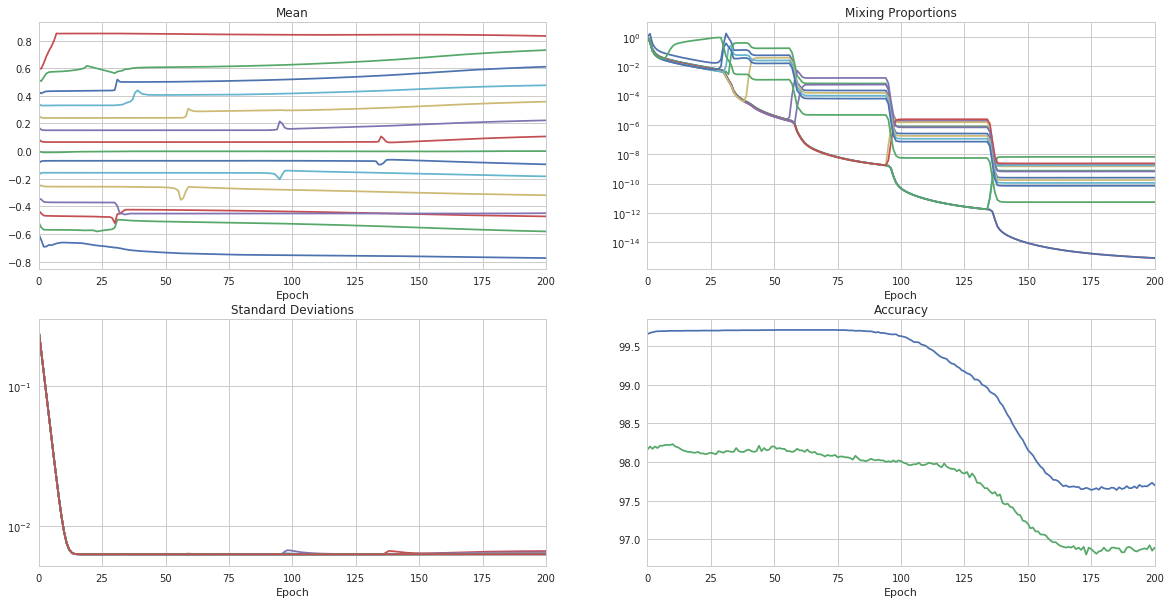

**Epoch: 1**

Layer Loss: 147291.625
Layer Loss: 165.992
Layer Loss: 21380.977
Layer Loss: 63.684
Layer Loss: 998.946
Layer Loss: 5.666
0-neglogprop Loss: -13828.171
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -1039439.125
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 2**

Layer Loss: 104356.500
Layer Loss: 94.593
Layer Loss: 18295.801
Layer Loss: 47.243
Layer Loss: 1147.634
Layer Loss: 3.415
0-neglogprop Loss: -16963.529
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -1303519.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 3**

Layer Loss: 87129.664
Layer Loss: 59.195
Layer Loss: 18698.480
Layer Loss: 43.064
Layer Loss: 1373.579
Layer Loss: 2.382
0-neglogprop Loss: -18916.180
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -1567214.125
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 4**

Layer Loss: 80601.719
Layer Loss: 47.051
Layer Loss: 19363.537
Layer Loss: 42.962
Layer Loss: 1494.178
Layer Loss: 2.063
0-neglogprop Loss: -19718.617
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -1830087.125
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 5**

Layer Loss: 76190.688
Layer Loss: 42.527
Layer Loss: 19498.977
Layer Loss: 42.915
Layer Loss: 1545.055
Layer Loss: 1.954
0-neglogprop Loss: -20010.627
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -2091169.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 6**

Layer Loss: 72262.633
Layer Loss: 39.733
Layer Loss: 19456.568
Layer Loss: 42.680
Layer Loss: 1586.514
Layer Loss: 1.892
0-neglogprop Loss: -20170.400
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -2348813.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 7**

Layer Loss: 68458.133
Layer Loss: 37.297
Layer Loss: 19346.799
Layer Loss: 42.326
Layer Loss: 1636.724
Layer Loss: 1.836
0-neglogprop Loss: -20298.479
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -2599762.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 8**

Layer Loss: 64606.348
Layer Loss: 34.832
Layer Loss: 19217.365
Layer Loss: 41.880
Layer Loss: 1672.385
Layer Loss: 1.774
0-neglogprop Loss: -20428.660
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -2837725.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 9**

Layer Loss: 60671.656
Layer Loss: 32.269
Layer Loss: 19061.219
Layer Loss: 41.365
Layer Loss: 1704.089
Layer Loss: 1.706
0-neglogprop Loss: -20565.564
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3051567.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 10**

Layer Loss: 56614.699
Layer Loss: 29.575
Layer Loss: 18869.043
Layer Loss: 40.839
Layer Loss: 1735.572
Layer Loss: 1.639
0-neglogprop Loss: -20711.496
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3224919.250
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 10. Training Accuracy: 99.70. Test Accuracy: 98.16
Means: [-0.662, -0.57, -0.47, -0.371, -0.257, -0.157, -0.07, -0.008, 0.065, 0.151, 0.24, 0.331, 0.435, 0.579, 0.853]
Mixing Proportions: [4.175, -2.903, -3.946, -3.937, -3.857, -3.766, -3.704, -3.69, -3.728, -3.82, -3.936, -3.99, -4.005, -4.009, -1.367]
Precisions: [4.201, 9.374, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391, 9.391]


**Epoch: 11**

Layer Loss: 52444.941
Layer Loss: 26.790
Layer Loss: 18658.828
Layer Loss: 40.271
Layer Loss: 1764.218
Layer Loss: 1.572
0-neglogprop Loss: -20864.910
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3341510.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 12**

Layer Loss: 48198.719
Layer Loss: 23.914
Layer Loss: 18437.006
Layer Loss: 39.602
Layer Loss: 1790.664
Layer Loss: 1.496
0-neglogprop Loss: -21022.930
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3399329.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 13**

Layer Loss: 43882.461
Layer Loss: 20.936
Layer Loss: 18204.510
Layer Loss: 38.815
Layer Loss: 1818.606
Layer Loss: 1.413
0-neglogprop Loss: -21185.596
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3418087.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 14**

Layer Loss: 39506.371
Layer Loss: 17.831
Layer Loss: 17957.951
Layer Loss: 37.905
Layer Loss: 1850.259
Layer Loss: 1.325
0-neglogprop Loss: -21351.975
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3421830.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 15**

Layer Loss: 35074.684
Layer Loss: 14.635
Layer Loss: 17700.020
Layer Loss: 36.877
Layer Loss: 1884.740
Layer Loss: 1.229
0-neglogprop Loss: -21522.686
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422296.250
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 16**

Layer Loss: 30538.654
Layer Loss: 11.305
Layer Loss: 17418.010
Layer Loss: 35.715
Layer Loss: 1916.248
Layer Loss: 1.126
0-neglogprop Loss: -21698.285
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422332.500
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 17**

Layer Loss: 25886.803
Layer Loss: 7.796
Layer Loss: 17119.203
Layer Loss: 34.402
Layer Loss: 1947.835
Layer Loss: 1.014
0-neglogprop Loss: -21879.816
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 18**

Layer Loss: 21104.783
Layer Loss: 4.103
Layer Loss: 16804.998
Layer Loss: 33.003
Layer Loss: 1986.183
Layer Loss: 0.896
0-neglogprop Loss: -22065.885
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 19**

Layer Loss: 16178.137
Layer Loss: 0.228
Layer Loss: 16462.395
Layer Loss: 31.404
Layer Loss: 2031.044
Layer Loss: 0.763
0-neglogprop Loss: -22259.787
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 20**

Layer Loss: 11096.178
Layer Loss: -3.899
Layer Loss: 16094.716
Layer Loss: 29.698
Layer Loss: 2068.763
Layer Loss: 0.622
0-neglogprop Loss: -22458.078
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0
Tau:5e-07
Epoch: 20. Training Accuracy: 99.70. Test Accuracy: 98.15
Means: [-0.677, -0.578, -0.473, -0.371, -0.257, -0.157, -0.07, -0.004, 0.065, 0.151, 0.24, 0.331, 0.436, 0.613, 0.853]
Mixing Proportions: [4.899, -3.719, -4.763, -4.754, -4.674, -4.584, -4.523, -4.509, -4.547, -4.638, -4.752, -4.806, -4.821, -4.82, -0.469]
Precisions: [4.572, 10.13, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127, 10.127]


**Epoch: 21**

Layer Loss: 5896.375
Layer Loss: -8.183
Layer Loss: 15690.802
Layer Loss: 27.866
Layer Loss: 2117.432
Layer Loss: 0.475
0-neglogprop Loss: -22662.615
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 22**

Layer Loss: 563.552
Layer Loss: -12.680
Layer Loss: 15275.227
Layer Loss: 25.969
Layer Loss: 2171.344
Layer Loss: 0.323
0-neglogprop Loss: -22870.932
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode=L size=1x1 at 0x7F7C92E29EF0>>
Traceback (most recent call last):
  File "/anaconda/envs/py35/lib/python3.5/site-packages/PIL/Image.py", line 587, in __del__
    if (hasattr(self, 'fp') and hasattr(self, '_exclusive_fp')
KeyboardInterrupt


**Epoch: 23**

Layer Loss: -4903.160
Layer Loss: -17.325
Layer Loss: 14853.326
Layer Loss: 23.924
Layer Loss: 2230.461
Layer Loss: 0.154
0-neglogprop Loss: -23086.566
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422335.000
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 24**

Layer Loss: -10428.685
Layer Loss: -22.073
Layer Loss: 14397.414
Layer Loss: 21.796
Layer Loss: 2290.039
Layer Loss: -0.016
0-neglogprop Loss: -23299.713
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 25**

Layer Loss: -16030.720
Layer Loss: -26.951
Layer Loss: 13960.194
Layer Loss: 19.609
Layer Loss: 2352.925
Layer Loss: -0.186
0-neglogprop Loss: -23515.588
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


**Epoch: 26**

Layer Loss: -21740.658
Layer Loss: -31.984
Layer Loss: 13519.101
Layer Loss: 17.367
Layer Loss: 2391.238
Layer Loss: -0.366
0-neglogprop Loss: -23735.883
0-component Mean: 2500.0 Variance: 1250.0
Remaining-neglogprop Loss: -3422334.750
Non-zero component Mean: 25000.0 Variance: 25000.0


In [ ]:
%%notify
#model = models.LeNet_300_100().cuda()
#print_dims(model)
for alpha in [2500, 25000, 250000]:
    for beta in [0.1, 1, 10, 100]:
        model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, 100)).cuda()
        gmp = GaussianMixturePrior(16, [x for x in model.parameters()], 0.99, ab = (alpha, beta))

        test_acc = test_accuracy(test_data_full, test_labels_full, model)
        train_acc = test_accuracy(train_data_full, train_labels_full, model)
        acc_history = np.array([train_acc[0], test_acc[0]])
        stddev_history = np.sqrt(1. / gmp.gammas.exp().data.clone().cpu().numpy())
        mean_history = gmp.means.data.clone().cpu().numpy()
        mixprop_history = gmp.rhos.exp().data.clone().cpu().numpy()

        sws_param1 = [gmp.means]
        sws_param2 = [gmp.gammas, gmp.rhos]
        #ipd.display(ipd.Markdown("**Default Training**"))

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
        optimizer_gmp = torch.optim.Adam(sws_param1, lr=1e-4)
        optimizer_gmp2 = torch.optim.Adam(sws_param2, lr=3e-3)
        graph_title='original_model/'

        retraining_epochs = 200
        decay = np.linspace(5e-7, 5e-6, retraining_epochs)
        #decay = 5e-7 * np.power(10, decay)
        #decay = 5e-5 * (1 - 1 / np.power(10, decay))

        exp_name = "{}_{}".format(alpha, beta)

        for epoch in range(retraining_epochs):
            ipd.display(ipd.Markdown("**Epoch: {}**".format(epoch+1)))
            #tau = float(decay[epoch])
            tau=5e-7
            model, loss = retrain_sws_epoch(model, gmp, optimizer, optimizer_gmp, optimizer_gmp2, criterion, train_loader, tau)

            test_acc = test_accuracy(test_data_full, test_labels_full, model)
            train_acc = test_accuracy(train_data_full, train_labels_full, model)
            weight_penalty = get_weight_penalty(model)

            stddev_history = np.vstack((stddev_history,  np.sqrt(1. / gmp.gammas.exp().data.clone().cpu().numpy()) ))
            mean_history = np.vstack((mean_history, gmp.means.data.clone().cpu().numpy() ))
            mixprop_history = np.vstack((mixprop_history, gmp.rhos.exp().data.clone().cpu().numpy() ))
            acc_history = np.vstack(( acc_history, np.array([train_acc[0], test_acc[0]]) ))

            if(writeTensorboard):
                writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
                writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
                writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
                for name, param in model.named_parameters():
                    writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
            if (trueAfterN(epoch, 10)):
                print ('Tau:{}'.format(tau))
                print('Epoch: {}. Training Accuracy: {:.2f}. Test Accuracy: {}'.format(epoch+1, train_acc[0], test_acc[0]))
                print ( "Means: {}".format(list(np.around(gmp.means.data.clone().cpu().numpy(),3))) )
                print ( "Mixing Proportions: {}".format(list(np.around(gmp.rhos.data.clone().cpu().numpy(),3))) )
                print ( "Precisions: {}".format(list(np.around(gmp.gammas.data.clone().cpu().numpy(),3))) )
            show_sws_weights(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch, accuracy = test_acc[0], savefile = exp_name)
                #show_all_weights(model)

        draw_sws_graphs(mean_history, stddev_history, mixprop_history, acc_history, exp_name)
        images = []
        filenames = ["figs/{}_{}.png".format(exp_name, x) for x in range(1,retraining_epochs+1)]
        for filename in filenames:
            images.append(imageio.imread(filename))
        imageio.mimsave('./exp/{}.gif'.format(exp_name), images)
#torch.save(model, model_dir + 'mnist_{}_{}.m'.format(model.name, training_epochs))

In [8]:
ipd.HTML('<img src="./exp/{}.gif">'.format(exp_name))

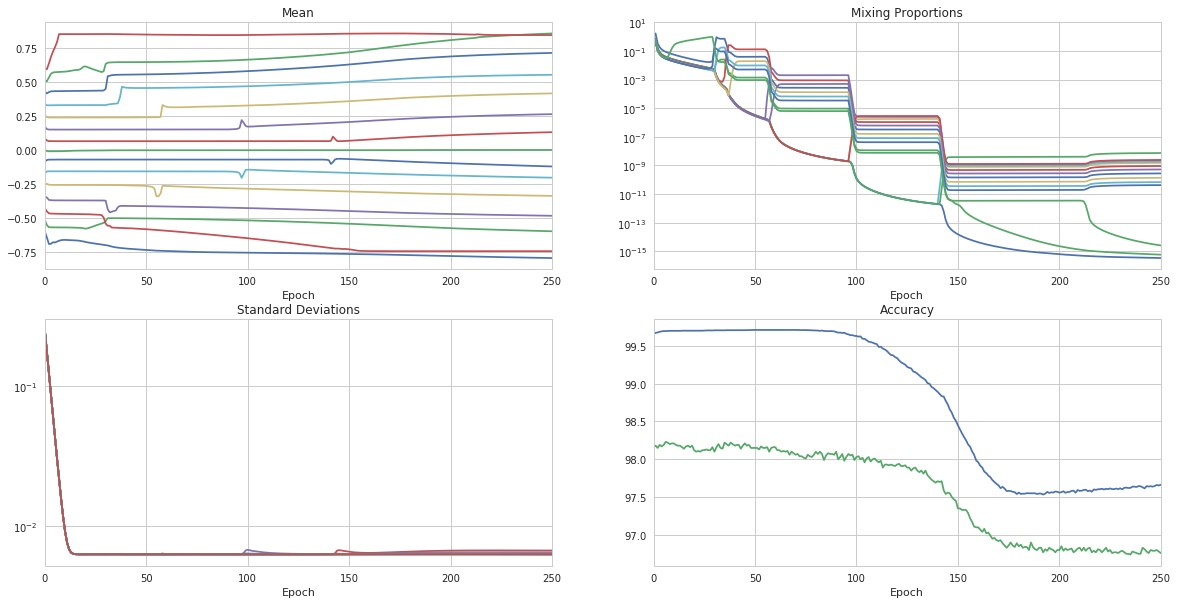

In [7]:
draw_sws_graphs(mean_history, stddev_history, mixprop_history, acc_history, exp_name)
images = []
filenames = ["figs/{}_{}.png".format(exp_name, x) for x in range(1,retraining_epochs+1)]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./exp/{}.gif'.format(exp_name), images)
ipd.HTML('<img src="./exp/{}.gif">'.format(exp_name))

### Post-Processing

In [218]:
def special_flatten(state_dict):
    return torch.cat (([state_dict[x].view(-1) for x in state_dict]), 0)

def reshape_like(in_array, shaped_array):
    "Inverts special_flatten"
    flattened_array = list(in_array)
    out = np.copy(shaped_array)
    for i, array in enumerate(shaped_array):
        num_samples = array.size
        dummy = flattened_array[:num_samples]
        del flattened_array[:num_samples]
        out[i] = np.asarray(dummy).reshape(array.shape)
    return out

def KL(means, logprecisions):
    """Compute the KL-divergence between 2 Gaussian Components."""
    precisions = np.exp(logprecisions)
    return 0.5 * (logprecisions[0] - logprecisions[1]) + precisions[1] / 2. * (
    1. / precisions[0] + (means[0] - means[1]) ** 2) - 0.5

def merger(inputs):
    """Comparing and merging components."""
    for _ in range(3):
        lists = []
        for inpud in inputs:
            for i in inpud:
                tmp = 1
                for l in lists:
                    if i in l:
                        for j in inpud:
                            l.append(j)
                        tmp = 0
                if tmp is 1:
                    lists.append(list(inpud))
        lists = [np.unique(l) for l in lists]
        inputs = lists
    return lists

def compute_responsibilies(xs, mus, logprecisions, pis):
    "Computing the unnormalized responsibilities."
    xs = xs.flatten()
    K = len(pis)
    W = len(xs)
    responsibilies = np.zeros((K, len(xs)))
    for k in range(K):
        # Not normalized!!!
        responsibilies[k] = pis[k] * np.exp(0.5 * logprecisions[k]) * np.exp(
            - np.exp(logprecisions[k]) / 2 * (xs - mus[k]) ** 2)
    return np.argmax(responsibilies, axis=0)

pi_zero = 0.99
weights = special_flatten(model.state_dict()).clone().cpu().numpy()
means = np.concatenate([np.zeros(1), gmp.means.clone().data.cpu().numpy()])
logprecisions = gmp.gammas.clone().data.cpu().numpy()
logpis = np.concatenate([np.log(pi_zero) * np.ones(1), gmp.rhos.clone().data.cpu().numpy()])

# classes K
J = len(logprecisions)
# compute KL-divergence
K = np.zeros((J, J))
L = np.zeros((J, J))

for i, (m1, pr1, pi1) in enumerate(zip(means, logprecisions, logpis)):
    for j, (m2, pr2, pi2) in enumerate(zip(means, logprecisions, logpis)):
        K[i, j] = KL([m1, m2], [pr1, pr2])
        L[i, j] = np.exp(pi1) * (pi1 - pi2 + K[i, j])
        
# merge -- KL divergence not low enough
"""
idx, idy = np.where(K < 1e-4)
print (K)
print (idx,idy)
lists = merger(np.asarray(zip(idx, idy)))
# compute merged components
# print lists
new_means, new_logprecisions, new_logpis = [], [], []

for l in lists:
    new_logpis.append(logsumexp(logpis[l]))
    new_means.append(
        np.sum(means[l] * np.exp(logpis[l] - np.min(logpis[l]))) / np.sum(np.exp(logpis[l] - np.min(logpis[l]))))
    new_logprecisions.append(np.log(
        np.sum(np.exp(logprecisions[l]) * np.exp(logpis[l] - np.min(logpis[l]))) / np.sum(
            np.exp(logpis[l] - np.min(logpis[l])))))

new_means[np.argmin(np.abs(new_means))] = 0.0
"""
# compute responsibilities
#argmax_responsibilities = compute_responsibilies(weights, new_means, new_logprecisions, np.exp(new_logpis))
argmax_responsibilities = compute_responsibilies(weights, means, logprecisions, np.exp(logpis))
out = [means[i] for i in argmax_responsibilities]

### 2. Re-train Model

**Temperature = 1**

Epoch: 20. Train CE Loss: 1.513, Train Accuracy: 99.037, Test CE Loss: 1.519, Test Accuracy: 97.990, Model L2: 18.815
Epoch: 40. Train CE Loss: 1.512, Train Accuracy: 99.055, Test CE Loss: 1.517, Test Accuracy: 98.040, Model L2: 18.733


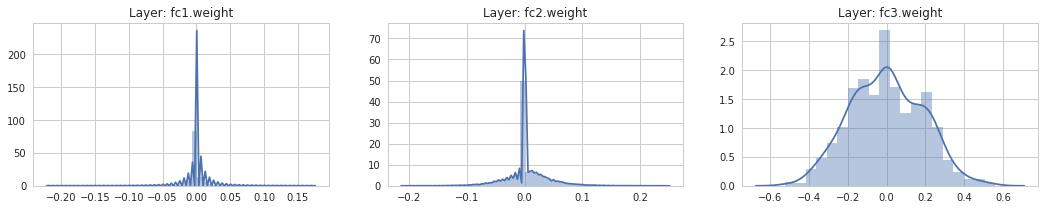

**Temperature = 5**

Epoch: 20. Train CE Loss: 1.516, Train Accuracy: 98.848, Test CE Loss: 1.522, Test Accuracy: 97.810, Model L2: 18.595
Epoch: 40. Train CE Loss: 1.514, Train Accuracy: 98.950, Test CE Loss: 1.520, Test Accuracy: 98.010, Model L2: 18.491


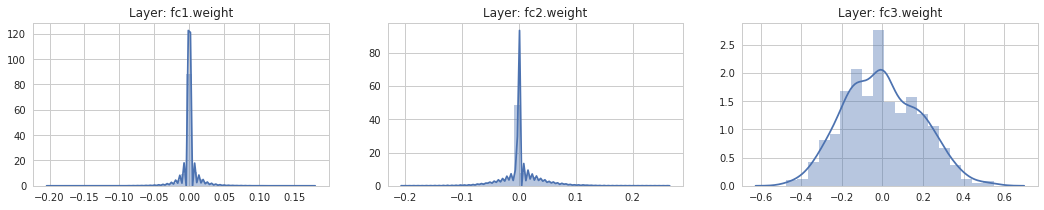

**Temperature = 10**

Epoch: 20. Train CE Loss: 1.531, Train Accuracy: 98.688, Test CE Loss: 1.534, Test Accuracy: 97.950, Model L2: 17.576
Epoch: 40. Train CE Loss: 1.529, Train Accuracy: 98.710, Test CE Loss: 1.532, Test Accuracy: 97.850, Model L2: 17.509


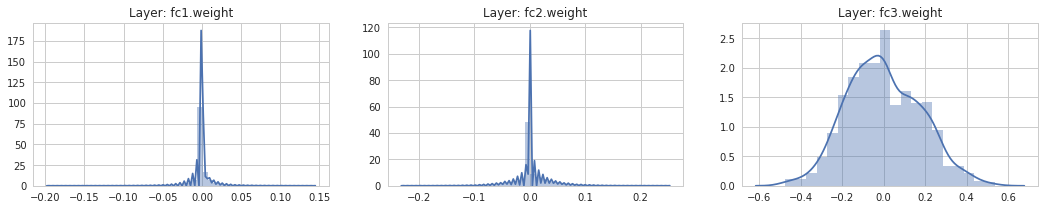

**Temperature = 15**

Epoch: 20. Train CE Loss: 1.576, Train Accuracy: 98.330, Test CE Loss: 1.575, Test Accuracy: 97.680, Model L2: 16.114
Epoch: 40. Train CE Loss: 1.575, Train Accuracy: 98.407, Test CE Loss: 1.575, Test Accuracy: 97.670, Model L2: 16.017


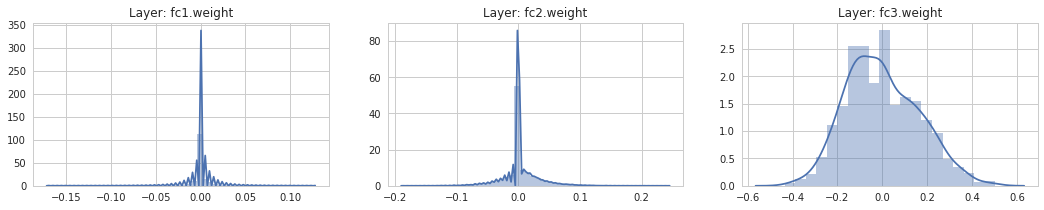

**Temperature = 20**

Epoch: 20. Train CE Loss: 1.648, Train Accuracy: 97.995, Test CE Loss: 1.645, Test Accuracy: 97.490, Model L2: 14.677
Epoch: 40. Train CE Loss: 1.648, Train Accuracy: 98.038, Test CE Loss: 1.644, Test Accuracy: 97.480, Model L2: 14.611


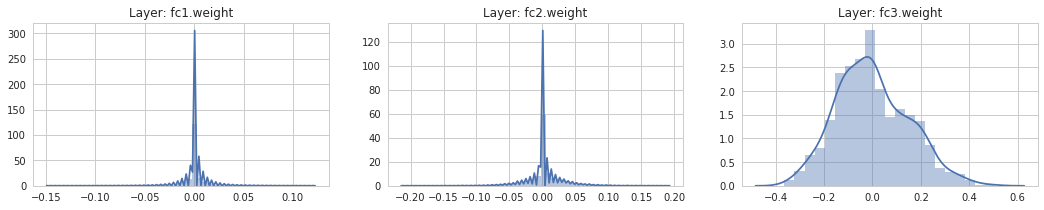

**Temperature = 25**

Epoch: 20. Train CE Loss: 1.729, Train Accuracy: 97.690, Test CE Loss: 1.724, Test Accuracy: 97.310, Model L2: 13.517
Epoch: 40. Train CE Loss: 1.727, Train Accuracy: 97.895, Test CE Loss: 1.722, Test Accuracy: 97.500, Model L2: 13.511


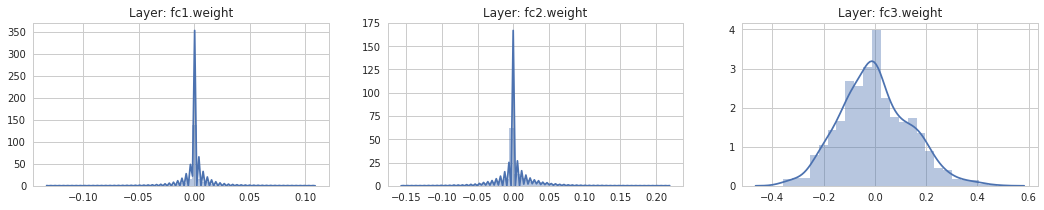

**Temperature = 30**

Epoch: 20. Train CE Loss: 1.806, Train Accuracy: 97.617, Test CE Loss: 1.800, Test Accuracy: 97.280, Model L2: 12.557
Epoch: 40. Train CE Loss: 1.806, Train Accuracy: 97.635, Test CE Loss: 1.801, Test Accuracy: 97.220, Model L2: 12.561


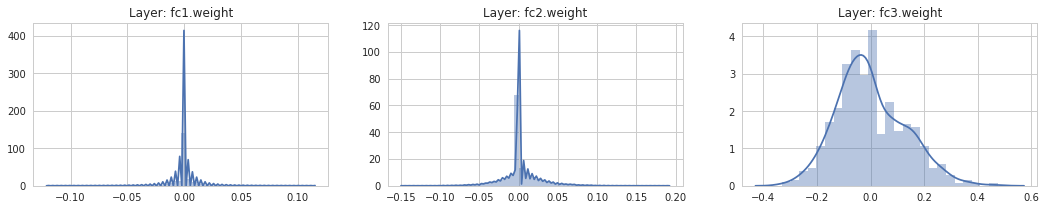

In [3]:
#Get KD Targets   
for temp in temp_list:
    ipd.display(ipd.Markdown("**Temperature = {}**".format(temp)))
    model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, training_epochs)).cuda()
    kd_outputs = model.kd_targets(train_data_full,T=temp)
    kd_dataset = torch.utils.data.TensorDataset(train_data_full.data, kd_outputs.data)#.data turns variable -> tensor
    train_kd_loader = torch.utils.data.DataLoader(dataset=kd_dataset, batch_size=batch_size, shuffle=True)

    #Load model
    model_kd = models.LeNet_300_100().cuda()
    model_kd.load_state_dict(model.state_dict())

    #Set up Optimisers and loss
    criterion_kd = nn.MSELoss()
    learning_rate_kd = 0.0005
    wd_kd = 0.0001
    optimizer_kd_1 = torch.optim.Adam(model_kd.fc1.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
    optimizer_kd_2 = torch.optim.Adam(model_kd.fc2.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
    optimizer_kd_3 = torch.optim.Adam(model_kd.fc3.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)

    graph_title = "compressed_model_T_{}/".format(temp)

    for epoch in range(retraining_epochs):
        model_kd, loss = train_epoch(model_kd, optimizer_kd_3, criterion_kd, train_kd_loader)
        model_kd, loss = train_epoch(model_kd, optimizer_kd_2, criterion_kd, train_kd_loader)
        model_kd, loss = train_epoch(model_kd, optimizer_kd_1, criterion_kd, train_kd_loader)
        test_acc = test_accuracy(test_data_full, test_labels_full, model_kd)
        train_acc = test_accuracy(train_data_full, train_labels_full, model_kd)
        weight_penalty = get_weight_penalty(model_kd)

        writer.add_scalars(graph_title + 'train_CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
        writer.add_scalars(graph_title + 'train_Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
        writer.add_scalars(graph_title + 'train_L2', {'L2' : weight_penalty}, epoch+1)
        for name, param in model.named_parameters():
            writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
        if (epoch%20==19):
            print('Epoch: {}. Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}'.format(epoch+1, train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty))
    torch.save(model_kd, model_dir + 'mnist_{}_kd_t{}_e{}.m'.format(model_kd.name, temp, retraining_epochs))
    show_weights(model_kd)

### 3. Prune Model

**Temperature = 1**

Train CE Loss: 1.862, Train Accuracy: 89.627, Test CE Loss: 1.857, Test Accuracy: 88.930, Model L2: 16.345, Parameters Pruned: 235301/266610 - 88.257%
Train CE Loss: 1.929, Train Accuracy: 85.725, Test CE Loss: 1.924, Test Accuracy: 84.600, Model L2: 16.124, Parameters Pruned: 226270/266610 - 84.869%


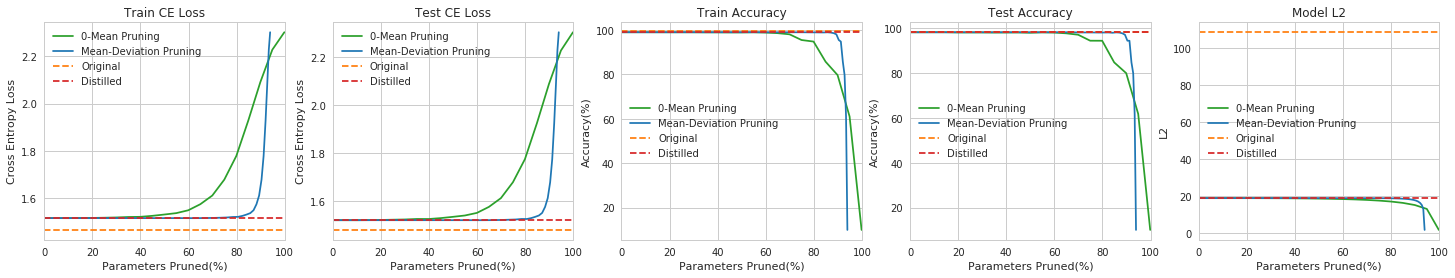

**Temperature = 5**

Train CE Loss: 1.848, Train Accuracy: 84.250, Test CE Loss: 1.844, Test Accuracy: 83.450, Model L2: 16.239, Parameters Pruned: 235622/266610 - 88.377%
Train CE Loss: 1.897, Train Accuracy: 82.622, Test CE Loss: 1.894, Test Accuracy: 81.950, Model L2: 15.949, Parameters Pruned: 226270/266610 - 84.869%


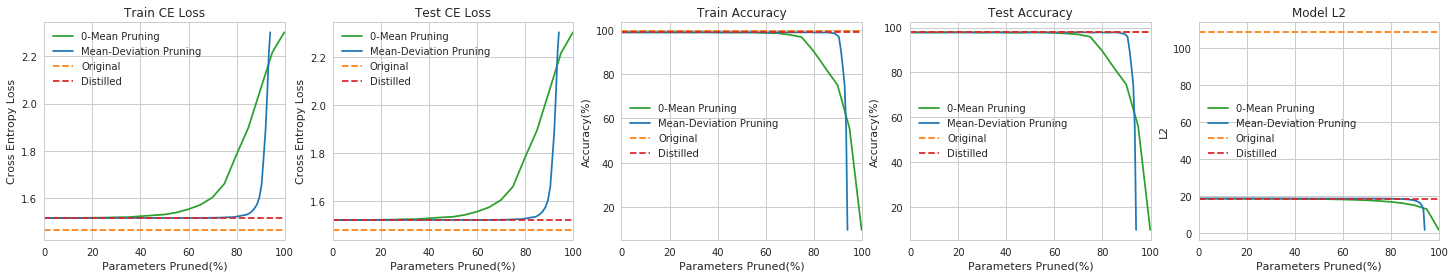

**Temperature = 10**

Train CE Loss: 1.869, Train Accuracy: 90.467, Test CE Loss: 1.861, Test Accuracy: 89.800, Model L2: 15.362, Parameters Pruned: 235608/266610 - 88.372%
Train CE Loss: 1.926, Train Accuracy: 92.660, Test CE Loss: 1.919, Test Accuracy: 91.990, Model L2: 15.180, Parameters Pruned: 226270/266610 - 84.869%


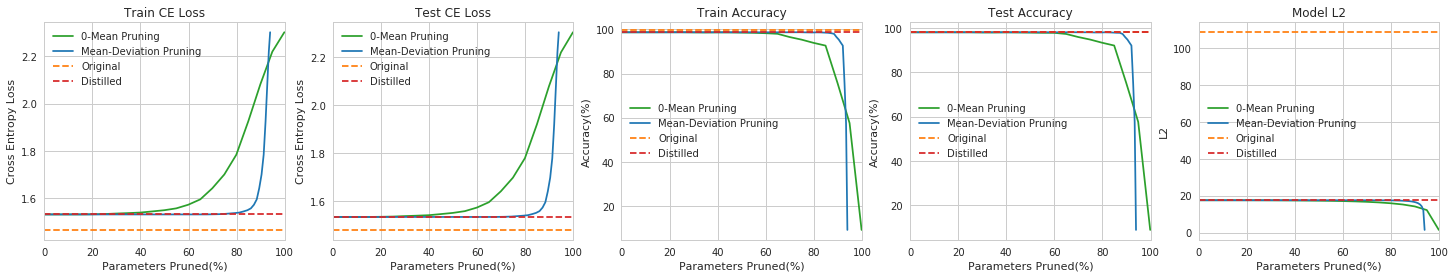

**Temperature = 15**

Train CE Loss: 1.928, Train Accuracy: 90.552, Test CE Loss: 1.922, Test Accuracy: 90.050, Model L2: 14.014, Parameters Pruned: 236170/266610 - 88.583%
Train CE Loss: 1.983, Train Accuracy: 84.900, Test CE Loss: 1.978, Test Accuracy: 84.110, Model L2: 13.849, Parameters Pruned: 226270/266610 - 84.869%


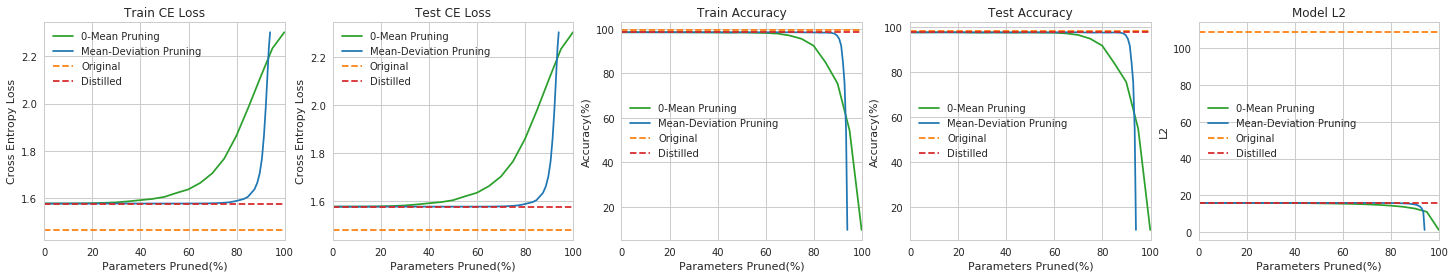

**Temperature = 20**

Train CE Loss: 1.981, Train Accuracy: 88.742, Test CE Loss: 1.975, Test Accuracy: 88.460, Model L2: 12.907, Parameters Pruned: 235772/266610 - 88.433%
Train CE Loss: 2.024, Train Accuracy: 87.882, Test CE Loss: 2.019, Test Accuracy: 87.350, Model L2: 12.730, Parameters Pruned: 226270/266610 - 84.869%


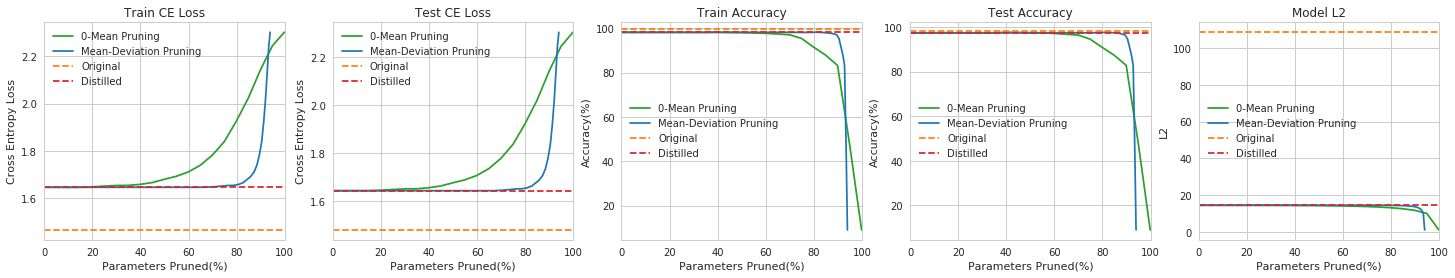

**Temperature = 25**

Train CE Loss: 2.031, Train Accuracy: 86.620, Test CE Loss: 2.025, Test Accuracy: 86.660, Model L2: 11.936, Parameters Pruned: 234994/266610 - 88.141%
Train CE Loss: 2.072, Train Accuracy: 83.885, Test CE Loss: 2.066, Test Accuracy: 83.910, Model L2: 11.764, Parameters Pruned: 226270/266610 - 84.869%


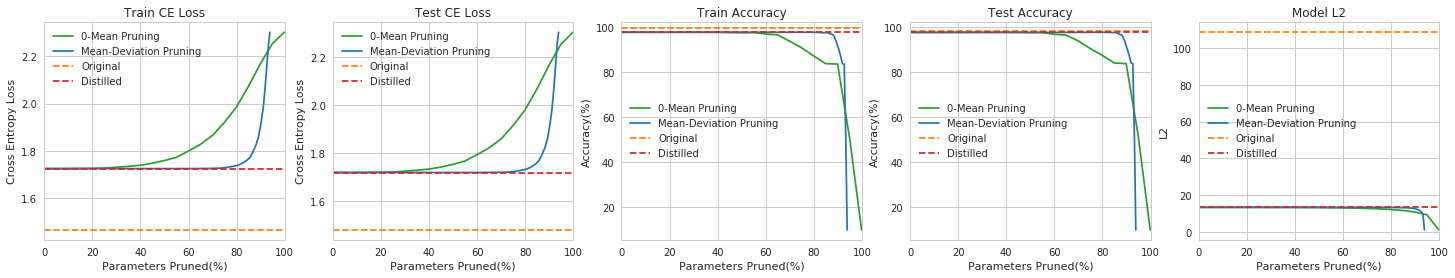

**Temperature = 30**

Train CE Loss: 2.100, Train Accuracy: 94.078, Test CE Loss: 2.096, Test Accuracy: 93.550, Model L2: 11.047, Parameters Pruned: 234621/266610 - 88.002%
Train CE Loss: 2.117, Train Accuracy: 88.603, Test CE Loss: 2.114, Test Accuracy: 88.120, Model L2: 10.959, Parameters Pruned: 226270/266610 - 84.869%


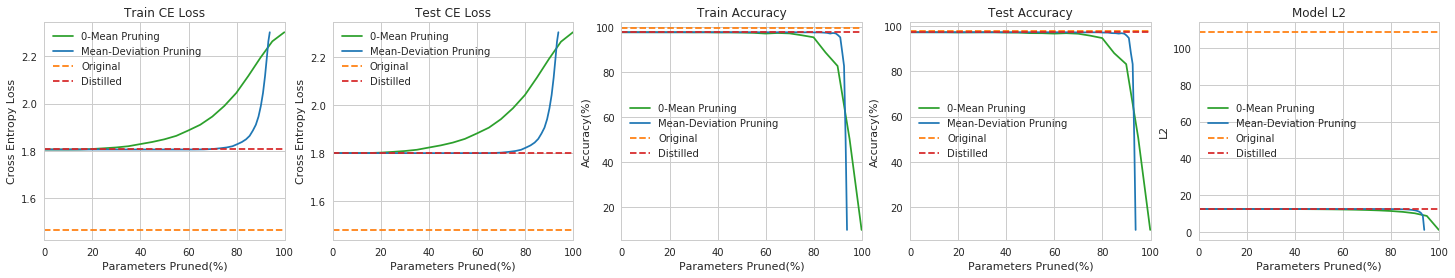

In [4]:
#Original Model
model = torch.load(model_dir + 'mnist_LeNet_300_100_100.m').cuda()
test_acc_o = test_accuracy(test_data_full, test_labels_full, model)
train_acc_o = test_accuracy(train_data_full, train_labels_full, model)
weight_penalty_o = get_weight_penalty(model)
compress_res = {}

for temp in temp_list:
    ipd.display(ipd.Markdown("**Temperature = {}**".format(temp)))
    graph_title = "compressed_model_T_{}/".format(temp)
    #Retrained Model
    model_kd = torch.load(model_dir + 'mnist_LeNet_300_100_kd_t{}_e50.m'.format(temp)).cuda()
    test_acc_kd = test_accuracy(test_data_full, test_labels_full, model_kd)
    train_acc_kd = test_accuracy(train_data_full, train_labels_full, model_kd)
    weight_penalty_kd = get_weight_penalty(model_kd)
    
    #writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Distilled Test': test_acc_kd[1], 'Distilled Train': train_acc_kd[1], 'Original Test': test_acc_o[1], 'Original Train': train_acc_o[1]}, 0)
    #writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Distilled Test': test_acc_kd[1], 'Distilled Train': train_acc_kd[1], 'Original Test': test_acc_o[1], 'Original Train': train_acc_o[1]}, 100)
    #writer.add_scalars(graph_title + 'Accuracy', {'Distilled Test': test_acc_kd[0], 'Distilled Train': train_acc_kd[0], 'Original Test': test_acc_o[0], 'Original Train': train_acc_o[0]}, 0)
    #writer.add_scalars(graph_title + 'Accuracy', {'Distilled Test': test_acc_kd[0], 'Distilled Train': train_acc_kd[0], 'Original Test': test_acc_o[0], 'Original Train': train_acc_o[0]}, 100)
    #writer.add_scalars(graph_title + 'L2', {'Distilled' : weight_penalty_kd, 'Original' : weight_penalty_o}, 0)
    #writer.add_scalars(graph_title + 'L2', {'Distilled' : weight_penalty_kd, 'Original' : weight_penalty_o}, 100)
    
    model_c = models.LeNet_300_100().cuda()
    pruner = model_prune(model_kd.state_dict())
    deviation_list = [x/10.0 for x in range(0,21)]
    percentile_list = range(0,101,5)
    
    
    dev_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : []}
    for i,lim in enumerate(deviation_list):
        model_c.load_state_dict(pruner.deviation_prune(lim))
        test_acc = test_accuracy(test_data_full, test_labels_full, model_c)
        train_acc = test_accuracy(train_data_full, train_labels_full, model_c)
        weight_penalty = get_weight_penalty(model_c)

        dev_res['train ce'].append(train_acc[1])
        dev_res['test ce'].append(test_acc[1])
        dev_res['train acc'].append(train_acc[0])
        dev_res['test acc'].append(test_acc[0])
        dev_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)
        dev_res['L2'].append(weight_penalty)

        writer.add_scalars(graph_title + 'prune_CrossEntropyLoss', {'Deviation Test': test_acc[1], 'Deviation Train': train_acc[1]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'prune_Accuracy', {'Deviation Test': test_acc[0], 'Deviation Train': train_acc[0]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'prune_L2', {'Deviation': weight_penalty}, 100.0 * pruner.num_pruned/pruner.total_weights)

        if(i==13):
            print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
              .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))
    
    perc_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : [],} 
    for i,lim in enumerate(percentile_list):
        model_c.load_state_dict(pruner.percentile_prune(lim))

        test_acc = test_accuracy(test_data_full, test_labels_full, model_c)
        train_acc = test_accuracy(train_data_full, train_labels_full, model_c)
        weight_penalty = get_weight_penalty(model_c)
        perc_res['train ce'].append(train_acc[1])
        perc_res['test ce'].append(test_acc[1])
        perc_res['train acc'].append(train_acc[0])
        perc_res['test acc'].append(test_acc[0])
        perc_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)
        perc_res['L2'].append(weight_penalty)

        writer.add_scalars(graph_title + 'prune_CrossEntropyLoss', {'Percentile Test': test_acc[1], 'Percentile Train': train_acc[1]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'prune_Accuracy', {'Percentile Test': test_acc[0], 'Percentile Train': train_acc[0]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'prune_L2', {'Percentile': weight_penalty}, 100.0 * pruner.num_pruned/pruner.total_weights)
        
        if(i==17):
            print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
              .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))
            
    prune_plot(temp, dev_res, perc_res, test_acc_o, train_acc_o, weight_penalty_o, test_acc_kd, train_acc_kd, weight_penalty_kd)
    #t_res={} 
    #t_res['dev']=dev_res
    #t_res['perc']=perc_res
    #compress_res[temp]=t_res